<a href="https://colab.research.google.com/github/adinsegall/dl4am-cvae-bilstm/blob/main/DL4AM_Coursework_Segall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL4AM Coursework: Combining Loop Candidacy Detection and Source Separation Models

Author: Adin Segall

This notebook contains the code, results, and analysis for the DL4AM coursework project focused on applying deep learning techniques to musical audio processing tasks. The goal is to implement and combine two distinct models:

1. A BiLSTM-based binary classifier to predict the "loopability" of short music segments (i.e. their suitability for seamless repetition). This model will learn on mel spectrogram input representations.  

2. A convolutional variational autoencoder (CVAE) to perform source separation on mixed audio signals, isolating individual instrumental elements. The CVAE will operate on magnitude spectrogram inputs and produce time-frequency masks to extract sources.

Both models will be trained and evaluated independently on the Free Music Archive (FMA) dataset, which provides source audio files, and optionally the Groove MIDI dataset for more granular rhythm pattern analysis. Key evaluation metrics will include accuracy and F1-score for the loop classifier, and signal-to-distortion ratio (SDR) and related source separation metrics for the CVAE.  

After developing the standalone models, different strategies for joint optimization and transfer learning will be explored to assess potential performance gains from shared feature extraction and end-to-end training.

The notebook is organized as follows:
1. Setup
   1.1 Imports
   1.2 Logging
   1.3 Device Configuration
2. Dataset Loading and Preprocessing
   2.1 FMA Dataset
   2.2 Groove MIDI Dataset
3. Model Implementations
4. Training Procedures
5. Evaluation and Results
6. Model Combination Strategies
7. Discussion and Interpretation
8. Conclusion and Future Directions

Code and analysis will be presented with the goal of academic rigor, suitable for conference submission in applied machine learning for audio. All key modeling choices and training details will be justified according to best practices established in the DL4AM module and relevant literature.

# 1. Setup

In [1]:
!pip install pretty_midi

In [2]:
#@title 1.1 Imports

import os
import random
import time
import logging
import zipfile
from os import listdir
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchaudio
from torchaudio.transforms import MelSpectrogram

import torchvision
from torchvision import transforms

import librosa
import librosa.display
import pretty_midi

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
#@title 1.2 Logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
#@title 1.3 Device Configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#2. Datasets

In [5]:
#@title 2.0 Dataset Download and Setup

# Path to dataset storage inside Google Drive
drive_root = '/content/drive/MyDrive/DL4AM_datasets'

# Make sure the directory exists
os.makedirs(drive_root, exist_ok=True)

# Paths inside Google Drive
fma_small_zip = os.path.join(drive_root, 'fma_small.zip')
fma_small_folder = os.path.join(drive_root, 'fma_small')
fma_small_url = 'https://os.unil.cloud.switch.ch/fma/fma_small.zip'

fma_metadata_zip = os.path.join(drive_root, 'fma_metadata.zip')
fma_metadata_folder = os.path.join(drive_root, 'fma_metadata')
fma_metadata_url = 'https://os.unil.cloud.switch.ch/fma/fma_metadata.zip'

egmd_zip = os.path.join(drive_root, 'e-gmd-v1.0.0-midi.zip')
egmd_folder = os.path.join(drive_root, 'e-gmd-v1.0.0-midi')
egmd_url = 'https://storage.googleapis.com/magentadata/datasets/e-gmd/v1.0.0/e-gmd-v1.0.0-midi.zip'

# --- FMA Small ---
if not os.path.exists(fma_small_folder):
    print(f"Downloading FMA Small to {fma_small_zip}...")
    !wget -O "$fma_small_zip" "$fma_small_url"

    print(f"Extracting to {fma_small_folder}...")
    !unzip -q "$fma_small_zip" -d "$drive_root"
    os.remove(fma_small_zip)
else:
    print(f"FMA Small already exists at {fma_small_folder}")

# --- FMA Metadata ---
if not os.path.exists(fma_metadata_folder):
    print(f"Downloading FMA Metadata to {fma_metadata_zip}...")
    !wget -O "$fma_metadata_zip" "$fma_metadata_url"

    print(f"Extracting to {fma_metadata_folder}...")
    !unzip -q "$fma_metadata_zip" -d "$drive_root"
    os.remove(fma_metadata_zip)
else:
    print(f"FMA Metadata already exists at {fma_metadata_folder}")

# --- E-GMD MIDI ---
if not os.path.exists(egmd_folder):
    print(f"Downloading E-GMD MIDI to {egmd_zip}...")
    !wget -O "$egmd_zip" "$egmd_url"

    print(f"Extracting to {egmd_folder}...")
    with zipfile.ZipFile(egmd_zip, 'r') as zip_ref:
        zip_ref.extractall(drive_root)
    os.remove(egmd_zip)
else:
    print(f"E-GMD MIDI already exists at {egmd_folder}")

print("Dataset setup complete.")


FMA Small already exists at /content/drive/MyDrive/DL4AM_datasets/fma_small
FMA Metadata already exists at /content/drive/MyDrive/DL4AM_datasets/fma_metadata
E-GMD MIDI already exists at /content/drive/MyDrive/DL4AM_datasets/e-gmd-v1.0.0-midi
Dataset setup complete.


In [6]:
#@title 2.1 FMA Dataset

class FMADataset(Dataset):
    """Free Music Archive audio dataset (log-mel spectrograms + genre labels)."""
    def __init__(self, root_dir, metadata_file, transform=None,
                 n_mels=128, hop_length=512, sample_rate=22050, n_frames=860):
        """
        Args:
            root_dir (str): Path to FMA root directory (e.g., 'fma_small').
            metadata_file (str): Path to metadata CSV file (e.g., 'tracks.csv').
            transform (callable, optional): Optional transform to apply to each sample.
            n_mels (int): Number of mel bins.
            hop_length (int): Hop length for mel spectrogram.
            sample_rate (int): Target sample rate.
            n_frames (int): Target number of spectrogram frames (for trimming/padding).
        """
        self.root_dir = root_dir
        self.transform = transform
        self.n_mels = n_mels
        self.hop_length = hop_length
        self.sample_rate = sample_rate
        self.n_frames = n_frames
        # Calculate the mean and standard deviation of the training data
        self.data_mean = None
        self.data_std = None

        # Load metadata and filter valid tracks
        logger.info(f"Loading metadata from {metadata_file}")
        self.tracks = self._load_metadata(metadata_file)
        logger.info(f"Loaded metadata for {len(self.tracks)} tracks")

        # Find all MP3 files recursively in the root directory
        self.file_paths = self._find_mp3_files(root_dir)
        logger.info(f"Found {len(self.file_paths)} MP3 files in {root_dir}")

        # Match files to metadata and keep only valid tracks
        self._match_files_to_metadata()
        logger.info(f"Dataset contains {len(self.valid_indices)} valid tracks with metadata")

        # Create label encoder for genres
        self._create_label_encoder()

    def _load_metadata(self, metadata_file):
        """Load and parse the tracks metadata file"""
        metadata = pd.read_csv(metadata_file, index_col=0, header=[0, 1])

        # Keep only the tracks with a valid genre
        metadata = metadata[metadata['track', 'genre_top'].notna()]

        # Convert multi-level columns to single level for easier access
        metadata.columns = [f"{col[0]}_{col[1]}" for col in metadata.columns]

        return metadata

    def _find_mp3_files(self, root_dir):
        """Recursively find all MP3 files in the root directory"""
        file_paths = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith('.mp3'):
                    file_paths.append(os.path.join(root, file))
        return file_paths

    def _match_files_to_metadata(self):
        """Match MP3 files to metadata entries"""
        self.valid_indices = []
        self.track_ids = []
        self.valid_file_paths = []

        for i, file_path in enumerate(self.file_paths):
            # Extract track ID from filename (remove .mp3 extension)
            filename = os.path.basename(file_path)
            try:
                track_id = int(filename.split('.')[0])

                # Check if track exists in metadata
                if track_id in self.tracks.index:
                    self.valid_indices.append(i)
                    self.track_ids.append(track_id)
                    self.valid_file_paths.append(file_path)
            except:
                # Skip files with invalid names
                continue

    def _create_label_encoder(self):
        """Create a label encoder for genre labels"""
        genres = [self.tracks.loc[track_id, 'track_genre_top'] for track_id in self.track_ids]
        self.encoder = LabelEncoder()
        self.encoder.fit(genres)
        self.num_classes = len(self.encoder.classes_)
        logger.info(f"Found {self.num_classes} unique genre classes")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Get file path and track ID
        file_path = self.valid_file_paths[idx]
        track_id = self.track_ids[idx]

        try:
            # Load audio file
            waveform, sr = torchaudio.load(file_path)

            # Convert to mono if stereo
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            # Resample if necessary
            if sr != self.sample_rate:
                waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)

            # Convert to numpy for librosa processing
            waveform_np = waveform.numpy().squeeze()

            # Compute mel spectrogram
            mel_spec = librosa.feature.melspectrogram(
                y=waveform_np,
                sr=self.sample_rate,
                n_mels=self.n_mels,
                hop_length=self.hop_length
            )
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Normalize the log-mel spectrogram using the mean and standard deviation
            if self.data_mean is not None and self.data_std is not None:
                log_mel_spec = (log_mel_spec - self.data_mean) / (self.data_std + 1e-8)
            else:
                # If mean and std are not provided, standardize the data
                log_mel_spec = (log_mel_spec - log_mel_spec.mean()) / (log_mel_spec.std() + 1e-8)

            # Pad or trim to fixed frame length
            if log_mel_spec.shape[1] < self.n_frames:
                pad_width = self.n_frames - log_mel_spec.shape[1]
                log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant')
            else:
                log_mel_spec = log_mel_spec[:, :self.n_frames]

            # Add channel dimension
            log_mel_spec = log_mel_spec[np.newaxis, :, :]

            # Get genre label
            genre = self.tracks.loc[track_id, 'track_genre_top']
            label = self.encoder.transform([genre])[0]

            sample = {
                'spectrogram': torch.tensor(log_mel_spec, dtype=torch.float32),
                'class_label': label,
                'track_id': track_id
            }

            if self.transform:
                sample = self.transform(sample)

            return sample

        except Exception as e:
            logger.warning(f"Error processing {file_path}: {e}")
            # Return a dummy sample as fallback (you might want to handle this differently)
            return {
                'spectrogram': torch.zeros((1, self.n_mels, self.n_frames), dtype=torch.float32),
                'class_label': 0,
                'track_id': track_id
            }

    def get_train_val_indices(self, val_size=0.2, random_state=42):
        """Create random train/validation split indices"""
        indices = list(range(len(self.valid_indices)))
        n_val = int(len(indices) * val_size)

        # Shuffle indices
        np.random.seed(random_state)
        np.random.shuffle(indices)

        # Split indices
        train_indices = indices[n_val:]
        val_indices = indices[:n_val]

        return train_indices, val_indices

In [7]:
#@title 2.2 Groove MIDI Dataset

class GrooveMIDIDataset(Dataset):
    def __init__(self, root_dir, max_files=50, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.max_files = max_files

        # Get list of MIDI files
        self.midi_files = [os.path.join(root_dir, 'midi', f) for f in os.listdir(os.path.join(root_dir, 'midi'))]

        # Randomly select a subset of MIDI files
        if len(self.midi_files) > max_files:
            self.midi_files = random.sample(self.midi_files, max_files)

        logger.info(f'Loaded {len(self.midi_files)} MIDI files from {root_dir}')

    def __len__(self):
        return len(self.midi_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        midi_path = self.midi_files[idx]

        try:
            # Load MIDI file
            midi_data = pretty_midi.PrettyMIDI(midi_path)

            # Extract features
            onsets = []
            velocities = []
            durations = []
            microtimings = []

            for instrument in midi_data.instruments:
                if not instrument.is_drum:
                    for note in instrument.notes:
                        onsets.append(midi_data.time_to_tick(note.start) / midi_data.resolution)
                        velocities.append(note.velocity)
                        durations.append(midi_data.time_to_tick(note.end - note.start) / midi_data.resolution)
                        microtimings.append((note.start - midi_data.tick_to_time(midi_data.time_to_tick(note.start))) * midi_data.resolution)

            # Create feature matrix
            n_frames = 128  # Adjust as needed
            onset_frame = np.zeros((n_frames,))
            velocity_frame = np.zeros((n_frames,))
            duration_frame = np.zeros((n_frames,))
            microtiming_frame = np.zeros((n_frames,))

            for onset, velocity, duration, microtiming in zip(onsets, velocities, durations, microtimings):
                onset_idx = int(onset * (n_frames - 1))
                onset_frame[onset_idx] = 1
                velocity_frame[onset_idx] = velocity
                duration_frame[onset_idx] = duration
                microtiming_frame[onset_idx] = microtiming

            # Stack features into a matrix
            feature_matrix = np.stack((onset_frame, velocity_frame, duration_frame, microtiming_frame))

            # Normalize feature matrix
            mean = feature_matrix.mean()
            std = feature_matrix.std()
            feature_matrix = (feature_matrix - mean) / std

            # Add channel dimension
            feature_matrix = feature_matrix[np.newaxis, :, :]

            # Create sample dictionary
            sample = {'feature_matrix': feature_matrix,
                      'midi_path': midi_path}

            if self.transform:
                sample = self.transform(sample)

            return sample

        except Exception as e:
            logger.warning(f'Failed to load {midi_path}. Error: {e}')
            return self.__getitem__(random.randint(0, self.__len__() - 1))

In [8]:
#@title 2.3 Dataset Instantiation and DataLoaders
# Define paths to your data and metadata
fma_small_dir = "/content/drive/MyDrive/DL4AM_datasets/fma_small"
fma_metadata_file = "/content/drive/MyDrive/DL4AM_datasets/fma_metadata/tracks.csv"

# Create dataset instance
logger.info("Creating FMA dataset instance...")
fma_dataset = FMADataset(
    root_dir=fma_small_dir,
    metadata_file=fma_metadata_file,
    transform=None,  # No transform needed since we handle tensor conversion in __getitem__
    n_mels=128,
    hop_length=512,
    sample_rate=22050,
    n_frames=860
)
# Create random train/validation split indices (80% train, 20% validation)
train_indices, val_indices = fma_dataset.get_train_val_indices(val_size=0.2, random_state=42)
logger.info(f"Train set: {len(train_indices)} samples, Validation set: {len(val_indices)} samples")

# Calculate the mean and standard deviation of the training data
if len(train_indices) > 0:
    train_data = torch.stack([fma_dataset[i]['spectrogram'] for i in train_indices])
    fma_dataset.data_mean = train_data.mean()
    fma_dataset.data_std = train_data.std()
else:
    logger.warning("No training data found. Skipping mean and standard deviation calculation.")



# Create data loaders for CVAE model
cvae_train_loader = DataLoader(
    dataset=fma_dataset,
    batch_size=4,
    sampler=SubsetRandomSampler(train_indices),
    num_workers=4,
    pin_memory=True
)

cvae_val_loader = DataLoader(
    dataset=fma_dataset,
    batch_size=4,
    sampler=SubsetRandomSampler(val_indices),
    num_workers=4,
    pin_memory=True
)

# Create data loaders for BiLSTM model (using the same dataset and split)
bilstm_train_loader = DataLoader(
    dataset=fma_dataset,
    batch_size=4,
    sampler=SubsetRandomSampler(train_indices),
    num_workers=4,
    pin_memory=True
)

bilstm_val_loader = DataLoader(
    dataset=fma_dataset,
    batch_size=4,
    sampler=SubsetRandomSampler(val_indices),
    num_workers=4,
    pin_memory=True
)

# Test the data loader
logger.info("Testing data loader...")
try:
    sample_batch = next(iter(cvae_train_loader))
    logger.info(f"Sample batch spectrogram shape: {sample_batch['spectrogram'].shape}")
    logger.info(f"Sample batch class labels: {sample_batch['class_label'][:5]}")  # Show first 5 labels
except Exception as e:
    logger.error(f"Error testing data loader: {e}")

Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x79bfa736c1b6 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x79bfa7315a76 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42034 (0x79bfa72a8034 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std::map<std::string, std::string, std::less<std::string>, std::allocator<std::pair<std::string const, std::string> > > > const&) + 0x14 (0x79bfa72aaa34 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #4: <un

#3 Models

In [9]:
#@title 3.1 CVAE Source Separator

#helper function
def compute_conv_output_shape(input_dim, n_frames, layers, kernel_sizes, strides, padding=1):
    h, w = input_dim, n_frames
    for kernel_size, stride in zip(kernel_sizes, strides):
        h = (h + 2*padding - kernel_size) // stride + 1
        w = (w + 2*padding - kernel_size) // stride + 1
    return h, w

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_frames=860, kernel_sizes=[3, 3, 3], strides=[2, 2, 2]):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_sizes[0], stride=strides[0], padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_sizes[1], stride=strides[1], padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=kernel_sizes[2], stride=strides[2], padding=1)
        h, w = compute_conv_output_shape(input_dim, n_frames, len(kernel_sizes), kernel_sizes, strides)
        self.flatten_size = 128 * h * w

        self.fc1 = nn.Linear(self.flatten_size, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, n_frames=860, kernel_sizes=[3, 3, 3], strides=[2, 2, 2]):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.n_frames = n_frames

        h, w = compute_conv_output_shape(output_dim, n_frames, len(kernel_sizes), kernel_sizes, strides)
        self.encoded_channels = 128
        self.encoded_height = h
        self.encoded_width = w
        self.flatten_size = self.encoded_channels * self.encoded_height * self.encoded_width

        self.fc2 = nn.Linear(hidden_dim, self.flatten_size)

        # Transposed convolutions for upsampling
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=kernel_sizes[2], stride=strides[2], padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=kernel_sizes[1], stride=strides[1], padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=kernel_sizes[0], stride=strides[0], padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(x.shape[0], self.encoded_channels, self.encoded_height, self.encoded_width)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)

        # Ensure the output has the exact same dimensions as the input
        x = F.interpolate(x, size=(128, self.n_frames), mode='bilinear', align_corners=False)

        reconstruction = torch.sigmoid(x)
        return reconstruction

# CVAE class with initialize_model method
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_frames=860, kernel_sizes=[3, 3, 3], strides=[2, 2, 2]):
        super(CVAE, self).__init__()

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=kernel_sizes[0], stride=strides[0], padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=kernel_sizes[1], stride=strides[1], padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=kernel_sizes[2], stride=strides[2], padding=1),
            nn.ReLU(),
        )

        # Calculate flattened size using the updated compute_conv_output_shape function
        h, w = compute_conv_output_shape(input_dim, n_frames, len(kernel_sizes), kernel_sizes, strides)
        self.flatten_size = 128 * h * w

        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, self.flatten_size)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=kernel_sizes[2], stride=strides[2], padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=kernel_sizes[1], stride=strides[1], padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=kernel_sizes[0], stride=strides[0], padding=1, output_padding=1),
            nn.Sigmoid()
        )

        self.input_dim = input_dim
        self.n_frames = n_frames

    def initialize_model(self, device):
        self.apply(self._init_weights)
        self.to(device)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)

    def encode(self, x):
        print(f"Encoder input shape: {x.shape}")
        x = self.encoder_conv(x)
        print(f"Encoder output shape: {x.shape}")
        x = x.view(x.size(0), -1)
        print(f"Flattened encoder output shape: {x.shape}")
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        print(f"Mu shape: {mu.shape}")
        print(f"Log_var shape: {log_var.shape}")
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        print(f"Decoder input shape: {z.shape}")
        x = self.fc_decoder(z)
        print(f"Decoder FC output shape: {x.shape}")
        conv_layers = [layer for layer in self.encoder_conv if isinstance(layer, nn.Conv2d)]
        h, w = compute_conv_output_shape(self.input_dim, self.n_frames, len(conv_layers), [layer.kernel_size[0] for layer in conv_layers], [layer.stride[0] for layer in conv_layers])
        x = x.view(x.size(0), 128, h, w)
        print(f"Reshaped decoder output shape: {x.shape}")
        x = self.decoder_conv(x)
        print(f"Decoder conv output shape: {x.shape}")
        if x.shape[2:] != (self.input_dim, self.n_frames):
            x = F.interpolate(x, size=(self.input_dim, self.n_frames), mode='bilinear', align_corners=False)
        print(f"Final decoder output shape: {x.shape}")
        return x

    def forward(self, x):
        print(f"Model input shape: {x.shape}")
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        print(f"Latent vector shape: {z.shape}")
        recon_x = self.decode(z)
        print(f"Model output shape: {recon_x.shape}")
        return recon_x, mu, log_var

In [10]:
#@title 3.2 BiLSTM Loop Candidacy Classifier

class BiLSTMLoopClassifier(nn.Module):
    """
    Bidirectional LSTM-based binary classifier for predicting loop candidacy.
    Takes mel spectrograms as input and outputs binary classification.
    """
    def __init__(self, input_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        """
        Args:
            input_dim (int): Number of input features (mel bins)
            hidden_dim (int): Hidden dimension of the LSTM
            num_layers (int): Number of LSTM layers
            dropout (float): Dropout probability (applied between LSTM layers and before final classification)
        """
        super(BiLSTMLoopClassifier, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_prob = dropout

        # Bidirectional LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Feature extraction from the LSTM output
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)

        # Final classification layer
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        """
        Forward pass through the BiLSTM classifier.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, 1, mel_bins, time_frames]

        Returns:
            torch.Tensor: Probability score for loop candidacy
        """
        batch_size = x.shape[0]

        # Reshape from [batch_size, 1, mel_bins, time_frames] to [batch_size, time_frames, mel_bins]
        # by removing channel dimension and transposing
        x = x.squeeze(1).transpose(1, 2)

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  # [batch_size, time_frames, hidden_dim*2]

        # Extract features from the last time step
        # Alternative: Use attention mechanism over all time steps
        last_hidden = lstm_out[:, -1, :]  # [batch_size, hidden_dim*2]

        # Feature processing
        x = F.relu(self.fc1(last_hidden))
        x = self.dropout(x)

        # Final classification
        logits = self.fc2(x)

        # Return sigmoid output for binary classification
        # return torch.sigmoid(logits).squeeze(-1)
        # Return raw logits for BCEWithLogitsLoss
        return logits.squeeze(-1)

class LSTMWithAttention(nn.Module):
    """
    Variation of the loop classifier that incorporates an attention mechanism
    over the LSTM outputs to better focus on parts of the sequence that
    are most relevant for loop candidacy prediction.
    """
    def __init__(self, input_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super(LSTMWithAttention, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_prob = dropout

        # BiLSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # Output layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Reshape from [batch_size, 1, mel_bins, time_frames] to [batch_size, time_frames, mel_bins]
        x = x.squeeze(1).transpose(1, 2)

        # Pass through BiLSTM
        lstm_out, _ = self.lstm(x)  # [batch_size, time_frames, hidden_dim*2]

        # Calculate attention weights
        attention_weights = F.softmax(self.attention(lstm_out), dim=1)

        # Apply attention weights to get context vector
        context = torch.sum(attention_weights * lstm_out, dim=1)

        # Process context vector
        x = F.relu(self.fc1(context))
        x = self.dropout(x)
        logits = self.fc2(x)

        # Return sigmoid output
        # return torch.sigmoid(logits).squeeze(-1)
        # Return raw logits for BCEWithLogitsLoss
        return logits.squeeze(-1)

class RhythmicFeatureExtractor(nn.Module):
    """
    Specialized convolutional module for extracting rhythmic features
    from spectrograms before passing to BiLSTM. This can help detect
    patterns that are important for loop candidacy.
    """
    def __init__(self, in_channels=1, out_channels=16):
        super(RhythmicFeatureExtractor, self).__init__()

        # Horizontal convolutions to capture time patterns
        self.time_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(1, 7), padding=(0, 3)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2))
        )

        # Vertical convolutions to capture frequency patterns
        self.freq_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(7, 1), padding=(3, 0)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1))
        )

    def forward(self, x):
        # Apply time and frequency convolutions
        time_features = self.time_conv(x)  # Captures rhythm patterns
        freq_features = self.freq_conv(x)  # Captures tonal patterns

        # Concatenate features along the channel dimension
        return torch.cat([time_features, freq_features], dim=1)

class HybridLoopClassifier(nn.Module):
    """
    A hybrid model combining convolutional feature extraction with BiLSTM
    for loop candidacy classification. This architecture first extracts
    rhythmic and tonal patterns from the spectrogram using CNNs and then
    analyzes the temporal dependencies using a BiLSTM.
    """
    def __init__(self, input_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super(HybridLoopClassifier, self).__init__()

        # Feature extractor
        self.feature_extractor = RhythmicFeatureExtractor(in_channels=1, out_channels=16)

        # Adapting dimensions for LSTM
        self.conv_adapt = nn.Conv2d(32, 1, kernel_size=1)

        # BiLSTM for sequence modeling (input dim is halved due to pooling)
        self.lstm = nn.LSTM(
            input_size=input_dim // 2,  # Reduced by frequency pooling
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Output layers
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Extract rhythmic features with CNN
        x = self.feature_extractor(x)  # [batch_size, 32, mel_bins/2, time_frames/2]

        # Adapt channels for LSTM
        x = self.conv_adapt(x)  # [batch_size, 1, mel_bins/2, time_frames/2]

        # Reshape for LSTM: [batch_size, time_frames/2, mel_bins/2]
        x = x.squeeze(1).transpose(1, 2)

        # Process with BiLSTM
        lstm_out, _ = self.lstm(x)

        # Global pooling across time
        x = lstm_out.transpose(1, 2)  # [batch_size, hidden_dim*2, time_frames/2]
        x = self.global_pool(x).squeeze(-1)  # [batch_size, hidden_dim*2]

        # Final classification
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)

        # return torch.sigmoid(logits).squeeze(-1)

        # Return raw logits for BCEWithLogitsLoss
        return logits.squeeze(-1)

#4 Training Procedures

In [11]:
#@title 4.1 CVAE Training Loop

def loss_function(recon_x, x, mu, log_var, beta=0.001):
    """
    Compute the CVAE loss function.

    Args:
        recon_x (torch.Tensor): The reconstructed spectrogram
        x (torch.Tensor): The original spectrogram
        mu (torch.Tensor): The mean of the latent Gaussian
        log_var (torch.Tensor): The log variance of the latent Gaussian
        beta (float): The weight for the KL divergence term

    Returns:
        tuple: (total_loss, reconstruction_loss, kl_divergence)
    """
    print(f"Reconstructed output shape: {recon_x.shape}")
    print(f"Input data shape: {x.shape}")
    print(f"Reconstructed output min/max: {recon_x.min().item()}/{recon_x.max().item()}")
    print(f"Input data min/max: {x.min().item()}/{x.max().item()}")

    # Initially, we used binary cross-entropy (BCE) loss for reconstruction
    # However, BCE loss is typically used for binary classification problems
    # where the target values are either 0 or 1. In our case, the input data
    # is normalized to have zero mean and unit variance, which means the target
    # values can be negative or greater than 1. Therefore, we switched to using
    # mean squared error (MSE) loss, which is more suitable for regression tasks
    # and reconstruction problems where the aim is to minimize the squared
    # difference between the predicted and target values.

    # MSE loss for reconstruction
    reconstruction_loss = F.mse_loss(recon_x, x, reduction='mean')

    # KL divergence: -0.5 * sum(1 + log_var - mu^2 - exp(log_var))
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss is reconstruction loss plus weighted KL divergence
    total_loss = reconstruction_loss + beta * kl_divergence

    return total_loss, reconstruction_loss, kl_divergence

def train_cvae(model, train_loader, val_loader=None, epochs=100, lr=1e-4,
              beta=0.001, device='cuda', checkpoint_dir='./checkpoints',
              checkpoint_interval=10, early_stopping_patience=10):

    """
    Train the CVAE model.

    Args:
        model (nn.Module): The CVAE model
        train_loader (DataLoader): DataLoader for training data
        val_loader (DataLoader, optional): DataLoader for validation data
        epochs (int): Number of training epochs
        lr (float): Learning rate
        beta (float): Weight for the KL divergence term
        device (str): Device to train on ('cuda' or 'cpu')
        checkpoint_dir (str): Directory to save model checkpoints
        checkpoint_interval (int): Save model every n epochs
        early_stopping_patience (int): Stop training if validation loss doesn't improve for n epochs

    Returns:
        nn.Module: The trained model
        dict: Training history
    """

    accumulation_steps = 8 #number of steps to accumulate gradients

    # Create checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Move model to device
    model = model.to(device)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

    # Initialize training history
    history = {
        'train_loss': [],
        'train_recon_loss': [],
        'train_kl_loss': [],
        'val_loss': [],
        'val_recon_loss': [],
        'val_kl_loss': []
    }

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = os.path.join(checkpoint_dir, 'cvae_best_model.pt')

    logger.info(f"Starting CVAE training for {epochs} epochs")

    for epoch in range(epochs):
        start_time = time.time()
        # Training phase
        model.train()
        train_loss = 0
        train_recon_loss = 0
        train_kl_loss = 0

        # Progress bar for training batches
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        # Training loop over batches
        for batch_idx, sample in enumerate(train_pbar):
            # Get spectrogram from sample
            data = sample['spectrogram'].to(device).float()

            print(f"Input data shape: {data.shape}")

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, log_var = model(data)
            loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, log_var, beta)

            print(f"Reconstructed output shape: {recon_batch.shape}")
            print(f"Input data shape: {data.shape}")

            # Remove the gradient accumulation code
            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Remove the redundant loss calculation and backward pass

            # Accumulate batch loss
            train_loss += loss.item()
            train_recon_loss += recon_loss.item()
            train_kl_loss += kl_loss.item()

            # Update progress bar
            train_pbar.set_postfix({
                'loss': loss.item(),
                'recon_loss': recon_loss.item(),
                'kl_loss': kl_loss.item()
            })

        # Calculate average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_recon_loss = train_recon_loss / len(train_loader.dataset)
        avg_train_kl_loss = train_kl_loss / len(train_loader.dataset)

        # Store training loss in history
        history['train_loss'].append(avg_train_loss)
        history['train_recon_loss'].append(avg_train_recon_loss)
        history['train_kl_loss'].append(avg_train_kl_loss)

        # Log training metrics
        logger.info(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} "
                   f"(Recon: {avg_train_recon_loss:.4f}, KL: {avg_train_kl_loss:.4f})")

        logger.info(f"Epoch {epoch+1} completed in {time.time() - start_time:.2f} seconds")

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0
            val_recon_loss = 0
            val_kl_loss = 0

            # No gradient calculation during validation
            with torch.no_grad():
                # Progress bar for validation batches
                val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")

                # Validation loop over batches
                for batch_idx, sample in enumerate(val_pbar):
                    # Get spectrogram from sample
                    data = sample['spectrogram'].to(device).float()

                    # Forward pass
                    recon_batch, mu, log_var = model(data)

                    # Calculate loss
                    loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, log_var, beta)

                    # Accumulate batch loss
                    val_loss += loss.item()
                    val_recon_loss += recon_loss.item()
                    val_kl_loss += kl_loss.item()

                    # Update progress bar
                    val_pbar.set_postfix({
                        'val_loss': loss.item(),
                        'val_recon_loss': recon_loss.item(),
                        'val_kl_loss': kl_loss.item()
                    })

            # Calculate average validation loss for the epoch
            avg_val_loss = val_loss / len(val_loader.dataset)
            avg_val_recon_loss = val_recon_loss / len(val_loader.dataset)
            avg_val_kl_loss = val_kl_loss / len(val_loader.dataset)

            # Store validation loss in history
            history['val_loss'].append(avg_val_loss)
            history['val_recon_loss'].append(avg_val_recon_loss)
            history['val_kl_loss'].append(avg_val_kl_loss)

            # Log validation metrics
            logger.info(f"Epoch {epoch+1}/{epochs} - Val Loss: {avg_val_loss:.4f} "
                       f"(Recon: {avg_val_recon_loss:.4f}, KL: {avg_val_kl_loss:.4f})")

            # Update learning rate based on validation loss
            scheduler.step(avg_val_loss)

            # Check for early stopping
            if avg_val_loss < best_val_loss:
                logger.info(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}")
                best_val_loss = avg_val_loss
                patience_counter = 0

                # Save the best model
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': avg_val_loss,
                }, best_model_path)
                logger.info(f"Saved best model to {best_model_path}")
            else:
                patience_counter += 1
                logger.info(f"Validation loss did not improve. Patience: {patience_counter}/{early_stopping_patience}")

                if patience_counter >= early_stopping_patience:
                    logger.info(f"Early stopping triggered after {epoch+1} epochs")
                    break

        # Save checkpoint periodically
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'cvae_epoch_{epoch+1}.pt')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_train_loss,
            }, checkpoint_path)
            logger.info(f"Saved checkpoint to {checkpoint_path}")

    # Load the best model if validation was used
    if val_loader is not None and os.path.exists(best_model_path):
        logger.info(f"Loading best model from {best_model_path}")
        checkpoint = torch.load(best_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])

    logger.info("CVAE training completed")

    return model, history


def visualize_cvae_training(history):
    """
    Visualize the training history of the CVAE model.

    Args:
        history (dict): Training history containing loss metrics
    """
    plt.figure(figsize=(15, 5))

    # Plot total loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train')
    if 'val_loss' in history and len(history['val_loss']) > 0:
        plt.plot(history['val_loss'], label='Validation')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot reconstruction loss
    plt.subplot(1, 3, 2)
    plt.plot(history['train_recon_loss'], label='Train')
    if 'val_recon_loss' in history and len(history['val_recon_loss']) > 0:
        plt.plot(history['val_recon_loss'], label='Validation')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot KL divergence
    plt.subplot(1, 3, 3)
    plt.plot(history['train_kl_loss'], label='Train')
    if 'val_kl_loss' in history and len(history['val_kl_loss']) > 0:
        plt.plot(history['val_kl_loss'], label='Validation')
    plt.title('KL Divergence')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


def generate_samples(model, num_samples=5, latent_dim=32, device='cuda'):
    """
    Generate samples from the trained CVAE model.

    Args:
        model (nn.Module): The trained CVAE model
        num_samples (int): Number of samples to generate
        latent_dim (int): Dimension of the latent space
        device (str): Device to use ('cuda' or 'cpu')

    Returns:
        torch.Tensor: Generated samples
    """
    model.eval()
    with torch.no_grad():
        # Sample from the latent space
        z = torch.randn(num_samples, latent_dim).to(device)

        # Decode the latent samples
        samples = model.decoder(z)

    return samples


def visualize_cvae_reconstructions(model, dataloader, num_examples=5, device='cuda'):
    """
    Visualize original spectrograms and their reconstructions.

    Args:
        model (nn.Module): The trained CVAE model
        dataloader (DataLoader): DataLoader containing the data
        num_examples (int): Number of examples to visualize
        device (str): Device to use ('cuda' or 'cpu')
    """
    # Set model to evaluation mode
    model.eval()

    # Get examples from dataloader
    examples = []
    for batch_idx, sample in enumerate(dataloader):
        if batch_idx >= num_examples:
            break
        examples.append(sample['spectrogram'])

    # Concatenate examples
    examples = torch.cat(examples[:num_examples])
    examples = examples.to(device)

    # Generate reconstructions
    with torch.no_grad():
        reconstructions, _, _ = model(examples)

    # Move tensors to CPU for visualization
    examples = examples.cpu()
    reconstructions = reconstructions.cpu()

    # Visualize originals and reconstructions
    plt.figure(figsize=(12, 6))
    for i in range(num_examples):
        # Original spectrogram
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(examples[i].squeeze(), cmap='viridis', origin='lower', aspect='auto')
        plt.title(f"Original {i+1}")
        plt.colorbar()

        # Reconstructed spectrogram
        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(reconstructions[i].squeeze(), cmap='viridis', origin='lower', aspect='auto')
        plt.title(f"Reconstructed {i+1}")
        plt.colorbar()

    plt.tight_layout()
    plt.show()

In [ ]:
#@title 4.2 BiLSTM Training Loop

def train_bilstm(model, train_loader, val_loader=None, epochs=100, lr=1e-3,
                device='cuda', checkpoint_dir='./checkpoints',
                checkpoint_interval=10, early_stopping_patience=10):
    """
    Train the BiLSTM model.

    Args:
        model (nn.Module): The BiLSTM model
        train_loader (DataLoader): DataLoader for training data
        val_loader (DataLoader, optional): DataLoader for validation data
        epochs (int): Number of training epochs
        lr (float): Learning rate
        device (str): Device to train on ('cuda' or 'cpu')
        checkpoint_dir (str): Directory to save model checkpoints
        checkpoint_interval (int): Save model every n epochs
        early_stopping_patience (int): Stop training if validation metric doesn't improve for n epochs

    Returns:
        nn.Module: The trained model
        dict: Training history
    """
    # Create checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Move model to device
    model = model.to(device)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=5, verbose=True)

    # Initialize training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    # Initialize early stopping
    best_val_f1 = 0.0
    patience_counter = 0
    best_model_path = os.path.join(checkpoint_dir, 'bilstm_best_model.pt')

    logger.info(f"Starting BiLSTM training for {epochs} epochs")

    for epoch in range(epochs):
        start_time = time.time()

        # Training loop
        model.train()
        train_loss = 0.0
        y_true_train = []
        y_pred_train = []

        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for batch_idx, sample in enumerate(train_pbar):
            # Get spectrogram and labels from sample
            spec = sample['spectrogram'].to(device).float()
            labels = sample['class_label'].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model(spec)
            loss = F.binary_cross_entropy_with_logits(logits, labels.float())

            # Backward pass
            loss.backward()
            optimizer.step()

            # Collect true and predicted labels
            y_true_train.extend(labels.tolist())
            y_pred_train.extend((torch.sigmoid(logits) > 0.5).long().tolist())

            train_loss += loss.item() * len(labels)

            # Update progress bar
            train_pbar.set_postfix({'loss': loss.item()})

        # Calculate training metrics
        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_precision = precision_score(y_true_train, y_pred_train)
        train_recall = recall_score(y_true_train, y_pred_train)
        train_f1 = f1_score(y_true_train, y_pred_train)

        # Store training metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)

        # Log training metrics
        logger.info(f"Epoch {epoch+1}/{epochs} - "
                    f"Train Loss: {train_loss:.4f}, "
                    f"Acc: {train_acc:.4f}, "
                    f"Precision: {train_precision:.4f}, "
                    f"Recall: {train_recall:.4f}, "
                    f"F1: {train_f1:.4f}")

        logger.info(f"Epoch {epoch+1} train completed in {time.time() - start_time:.2f} seconds")

        # Validation loop
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            y_true_val = []
            y_pred_val = []

            with torch.no_grad():
                val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")

                for batch_idx, sample in enumerate(val_pbar):
                    spec = sample['spectrogram'].to(device).float()
                    labels = sample['class_label'].to(device)

                    logits = model(spec)
                    loss = F.binary_cross_entropy_with_logits(logits, labels.float())

                    y_true_val.extend(labels.tolist())
                    y_pred_val.extend((torch.sigmoid(logits) > 0.5).long().tolist())

                    val_loss += loss.item() * len(labels)

                    val_pbar.set_postfix({'val_loss': loss.item()})

            # Calculate validation metrics
            val_loss /= len(val_loader.dataset)
            val_acc = accuracy_score(y_true_val, y_pred_val)
            val_precision = precision_score(y_true_val, y_pred_val)
            val_recall = recall_score(y_true_val, y_pred_val)
            val_f1 = f1_score(y_true_val, y_pred_val)

            # Store validation metrics
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['val_precision'].append(val_precision)
            history['val_recall'].append(val_recall)
            history['val_f1'].append(val_f1)

            # Log validation metrics
            logger.info(f"Epoch {epoch+1}/{epochs} - "
                        f"Val Loss: {val_loss:.4f}, "
                        f"Acc: {val_acc:.4f}, "
                        f"Precision: {val_precision:.4f}, "
                        f"Recall: {val_recall:.4f}, "
                        f"F1: {val_f1:.4f}")

            # Update learning rate based on F1
            scheduler.step(val_f1)

            # Check early stopping
            if val_f1 > best_val_f1:
                logger.info(f"F1 improved from {best_val_f1:.4f} to {val_f1:.4f}")
                best_val_f1 = val_f1
                patience_counter = 0
                torch.save(model.state_dict(), best_model_path)
                logger.info(f"Best model saved to {best_model_path}")
            else:
                patience_counter += 1
                logger.info(f"F1 did not improve. Patience: {patience_counter}/{early_stopping_patience}")

                if patience_counter == early_stopping_patience:
                    logger.info("Early stopping triggered")
                    break

        # Periodic checkpoints
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'bilstm_epoch_{epoch+1}.pt')
            torch.save(model.state_dict(), checkpoint_path)
            logger.info(f"Checkpoint saved to {checkpoint_path}")

    # Load best model
    if val_loader is not None:
        model.load_state_dict(torch.load(best_model_path))
        logger.info(f"Best model loaded from {best_model_path}")

    logger.info("BiLSTM training completed")

    return model, history


def visualize_bilstm_training(history):
    """Visualization of BiLSTM training history."""
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()

    # Plot losses
    axes[0].plot(history['train_loss'], label='Train Loss')
    if 'val_loss' in history:
        axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()

    metric_names = ["Accuracy", "Precision", "Recall", "F1"]

    # Plot other metrics
    for i, name in enumerate(metric_names, start=1):
        train_key = f"train_{name.lower()}"
        val_key = f"val_{name.lower()}"

        axes[i].plot(history[train_key], label=f'Train {name}')
        if val_key in history:
            axes[i].plot(history[val_key], label=f'Validation {name}')
        axes[i].set_title(name)
        axes[i].set_xlabel("Epoch")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
# import torch
# # Define hyperparameter search space
# model = CVAE(
#     input_dim=128,  # Number of mel bands
#     hidden_dim=128,
#     latent_dim=cvae_p['latent_dim'],
#     n_frames=860    # Number of frames in your spectrograms
# )

# print(torch.cuda.is_available())
# print(torch.cuda.device_count())
# # print(model.state_dict())
# for name, param in model.named_parameters():
#     print(f"Parameter: {name}, Device: {param.device}")

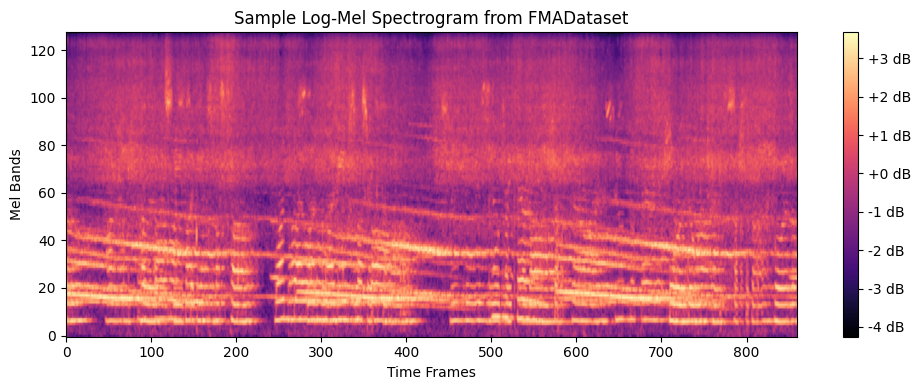

Saved dummy_spec.pt for upload.


In [ ]:
# === Extract & Visualize a Sample from FMADataset ===

import torch
import matplotlib.pyplot as plt
import numpy as np

# === Load 1 sample from your dataset ===
sample = fma_dataset[0]  # Change index if you want a different sample
spectrogram = sample['spectrogram']  # Shape: [1, 128, 860] (or similar)

# === Convert to numpy for plotting ===
spec_np = spectrogram.squeeze().numpy()  # Shape: [128, 860]

# === Display the spectrogram ===
plt.figure(figsize=(10, 4))
plt.imshow(spec_np, origin='lower', aspect='auto', cmap='magma')
plt.title("Sample Log-Mel Spectrogram from FMADataset")
plt.xlabel("Time Frames")
plt.ylabel("Mel Bands")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

# === Save tensor for upload to Claude ===
torch.save(spectrogram, "dummy_spec.pt")
print("Saved dummy_spec.pt for upload.")


In [ ]:
#@title Model size estimate calculations

import torch

# Calculate the model size
total_params = sum(p.numel() for p in cvae_model.parameters())
model_size_bytes = total_params * 4
model_size_mib = model_size_bytes / (1024 ** 2)

# Estimate the activation size (assuming activations are the same size as parameters)
activation_size_bytes = model_size_bytes

# Estimate the gradient size (same size as parameters)
gradient_size_bytes = model_size_bytes

# Specify the batch size
batch_size = 4  # Replace with your actual batch size

# Calculate the total memory required
total_memory_bytes = (model_size_bytes + activation_size_bytes + gradient_size_bytes) * batch_size
total_memory_mib = total_memory_bytes / (1024 ** 2)

print(f"Estimated model size: {model_size_mib:.2f} MiB")
print(f"Estimated total memory required: {total_memory_mib:.2f} MiB")

total_params = sum(p.numel() for p in cvae_model.parameters())
print(f"Total number of parameters: {total_params:,}")

NameError: name 'cvae_model' is not defined

In [12]:
#@title CUDA Model Loading Device Check

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Sanity check: create and move a simple Conv2d layer
try:
    test_conv = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
    test_conv.to(device)
    print("✅ Conv2d test passed")
except Exception as e:
    print("❌ Conv2d failed:", e)

# Now try only your encoder
try:
    encoder = Encoder(input_dim=128, hidden_dim=128, latent_dim=32, n_frames=860)
    encoder.to(device)
    print("✅ Encoder test passed")
except Exception as e:
    print("❌ Encoder failed:", e)

# Now try decoder
try:
    decoder = Decoder(latent_dim=32, hidden_dim=128, output_dim=128, n_frames=860)
    decoder.to(device)
    print("✅ Decoder test passed")
except Exception as e:
    print("❌ Decoder failed:", e)

Using device: cuda
✅ Conv2d test passed
✅ Encoder test passed
✅ Decoder test passed


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.mem_get_info(0))

In [ ]:
#@title 4.3 Train Models

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# === Hyperparameter Tuning ===
# Define hyperparameter search space
cvae_params = {
    'latent_dim': [16, 32, 64],     # Dimensionality of the latent space
    'lr': [1e-4, 1e-3],             # Learning rates to try
    'beta': [0.001, 0.01, 0.1],     # Weighting for KL divergence in the loss
}

bilstm_params = {
    'hidden_dim': [64, 128, 256],
    'num_layers': [1, 2, 3],
    'dropout': [0.1, 0.3, 0.5],
    'lr': [1e-4, 1e-3, 1e-2],
}


# Perform grid search over hyperparameters
best_cvae_params = None
best_cvae_val_loss = float('inf')
best_bilstm_params = None
best_bilstm_val_f1 = 0.0

for cvae_p in ParameterGrid(cvae_params):
    for bilstm_p in ParameterGrid(bilstm_params):
        logger.info(f"Training with CVAE params: {cvae_p}, BiLSTM params: {bilstm_p}")

        # Create models with current hyperparameters
        cvae_model = CVAE(input_dim=128, hidden_dim=128, latent_dim=cvae_p['latent_dim'])
        cvae_model = cvae_model.to(device)  # Move model to the device before training

        # === Train CVAE ===
        try:
            trained_cvae, cvae_history = train_cvae(
                model=cvae_model,
                train_loader=cvae_train_loader,
                val_loader=cvae_val_loader,
                epochs=100,
                lr=cvae_p['lr'],
                beta=cvae_p['beta'],
                device=device,
                checkpoint_dir="./checkpoints/cvae"
            )
        except RuntimeError as e:
            print(f"CVAE training failed: {e}")
            import traceback
            traceback.print_exc()
            trained_cvae, cvae_history = None, None
            continue  # skip to next hyperparameter combo if training fails

    # ✅ Only check best after successful training
    if cvae_history:
        min_val_loss = min(cvae_history['val_loss'])
        if min_val_loss < best_cvae_val_loss:
            best_cvae_val_loss = min_val_loss
            best_cvae_params = cvae_p
            logger.info(f"New best CVAE with val loss {min_val_loss:.4f}")
            torch.save(trained_cvae.state_dict(), "./checkpoints/cvae/best_cvae.pt")


        # # === Train BiLSTM ===
        # trained_bilstm, bilstm_history = train_bilstm(
        #     model=bilstm_model,
        #     train_loader=bilstm_train_loader,
        #     val_loader=bilstm_val_loader,
        #     epochs=50,
        #     lr=bilstm_p['lr'],
        #     device=device,
        #     checkpoint_dir="./checkpoints/bilstm"
        # )

        # # Check if best BiLSTM so far
        # max_val_f1 = max(bilstm_history['val_f1'])
        # if max_val_f1 > best_bilstm_val_f1:
        #     best_bilstm_val_f1 = max_val_f1
        #     best_bilstm_params = bilstm_p
        #     logger.info(f"New best BiLSTM with val F1 {max_val_f1:.4f}")
        #     torch.save(trained_bilstm.state_dict(), "./checkpoints/bilstm/best_bilstm.pt")




# === TEMP: Manually train CVAE with default params to verify it works ===

manual_cvae_params = {
    'latent_dim': 32,
    'lr': 1e-4,
    'beta': 0.001,
}

logger.info("Training CVAE manually with default hyperparameters to initialize best_cvae_params.")
cvae_model = CVAE(input_dim=128, hidden_dim=128, latent_dim=manual_cvae_params['latent_dim'])
cvae_model = cvae_model.to(device)  # Move model to the device before training
trained_cvae, cvae_history = train_cvae(
    model=cvae_model,
    train_loader=cvae_train_loader,
    val_loader=cvae_val_loader,
    epochs=100,
    lr=manual_cvae_params['lr'],
    beta=manual_cvae_params['beta'],
    device=device,
    checkpoint_dir="./checkpoints/cvae"
)

# Save these params as "best" for now so the rest of the code works
best_cvae_params = manual_cvae_params









# # === Train Final Models with Best Hyperparameters ===
# if best_cvae_params is None:
#     raise RuntimeError("No successful CVAE training runs. Cannot proceed with final training.")
# logger.info(f"Training final CVAE with params: {best_cvae_params}")


# cvae_model = CVAE(input_dim=n_mels, hidden_dim=128, latent_dim=best_cvae_params['latent_dim'])
# trained_cvae, cvae_history = train_cvae(
#     model=cvae_model,
#     train_loader=cvae_train_loader,
#     val_loader=cvae_val_loader,
#     epochs=100,
#     lr=best_cvae_params['lr'],
#     beta=best_cvae_params['beta'],
#     device=device,
#     checkpoint_dir="./checkpoints/cvae"
# )

# logger.info(f"Training final BiLSTM with params: {best_bilstm_params}")
# bilstm_model = BiLSTMLoopClassifier(
#     input_dim=n_mels, hidden_dim=best_bilstm_params['hidden_dim'],
#     num_layers=best_bilstm_params['num_layers'], dropout=best_bilstm_params['dropout']
# )
# trained_bilstm, bilstm_history = train_bilstm(
#     model=bilstm_model,
#     train_loader=bilstm_train_loader,
#     val_loader=bilstm_val_loader,
#     epochs=100,
#     lr=best_bilstm_params['lr'],
#     device=device,
#     checkpoint_dir="./checkpoints/bilstm"
# )

# === Visualize Training Results ===
visualize_cvae_training(cvae_history)
visualize_cvae_reconstructions(trained_cvae, cvae_val_loader)

# visualize_bilstm_training(bilstm_history)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/100 [Train]:   0%|          | 0/1600 [00:00<?, ?it/s]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/025/025378.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.4170682430267334/0.6462549567222595
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   0%|          | 1/1600 [00:04<2:01:22,  4.55s/it, loss=0.297, recon_loss=0.297, kl_loss=0.0191]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/111/111376.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.37857601046562195/0.6523900032043457
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   0%|          | 2/1600 [00:05<1:08:50,  2.58s/it, loss=0.303, recon_loss=0.295, kl_loss=8.13]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126519.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.40171018242836/0.6435840725898743
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   0%|          | 3/1600 [00:06<42:23,  1.59s/it, loss=0.295, recon_loss=0.295, kl_loss=0.562]  WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/089/089477.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.4060533046722412/0.6304754614830017
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   0%|          | 4/1600 [00:07<38:15,  1.44s/it, loss=0.295, recon_loss=0.294, kl_loss=0.964]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126415.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.41622164845466614/0.6267642974853516
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   0%|          | 5/1600 [00:07<28:47,  1.08s/it, loss=0.297, recon_loss=0.294, kl_loss=2.99]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/145/145750.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.38454392552375793/0.6325708031654358
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   0%|          | 6/1600 [00:08<26:35,  1.00s/it, loss=0.296, recon_loss=0.293, kl_loss=2.77]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 0.41774919629096985/0.6401181817054749
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   0%|          | 7/1600 [00:09<26:27,  1.00it/s, loss=0.294, recon_loss=0.292, kl_loss=1.37]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/129/129404.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.4230833351612091/0.626602828502655
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   0%|          | 8/1600 [00:10<25:07,  1.06it/s, loss=0.292, recon_loss=0.291, kl_loss=0.35]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/004/004510.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 0.3475963771343231/0.6459693908691406
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|          | 9/1600 [00:11<24:15,  1.09it/s, loss=0.289, recon_loss=0.289, kl_loss=0.167]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/006/006360.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.38713186979293823/0.6351685523986816
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|          | 10/1600 [00:11<21:08,  1.25it/s, loss=0.289, recon_loss=0.288, kl_loss=0.646]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/124/124180.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.3546527624130249/0.6587368249893188
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|          | 11/1600 [00:12<22:25,  1.18it/s, loss=0.286, recon_loss=0.285, kl_loss=1.34]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/144/144935.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.3486737608909607/0.6576566696166992
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|          | 12/1600 [00:13<21:59,  1.20it/s, loss=0.288, recon_loss=0.286, kl_loss=1.9]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/017/017631.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.37453174591064453/0.642334520816803
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|          | 13/1600 [00:14<23:22,  1.13it/s, loss=0.287, recon_loss=0.285, kl_loss=2.11]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.36531901359558105/0.6458606123924255
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|          | 14/1600 [00:15<19:36,  1.35it/s, loss=0.286, recon_loss=0.284, kl_loss=1.9]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.3577587604522705/0.6518967747688293
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|          | 15/1600 [00:15<18:49,  1.40it/s, loss=0.286, recon_loss=0.284, kl_loss=1.53]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126241.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.33522742986679077/0.6655746102333069
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|          | 16/1600 [00:16<22:45,  1.16it/s, loss=0.28, recon_loss=0.279, kl_loss=1.12]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/124/124517.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.3303748071193695/0.646753191947937
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|          | 17/1600 [00:17<17:56,  1.47it/s, loss=0.284, recon_loss=0.283, kl_loss=0.83]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/113/113268.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.35085949301719666/0.6430301070213318
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|          | 18/1600 [00:17<16:56,  1.56it/s, loss=0.283, recon_loss=0.282, kl_loss=0.649]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/029/029747.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.3151957094669342/0.6518833637237549
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|          | 19/1600 [00:18<20:54,  1.26it/s, loss=0.279, recon_loss=0.278, kl_loss=0.571]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/010/010670.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.32270094752311707/0.6294685006141663
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|▏         | 20/1600 [00:19<21:49,  1.21it/s, loss=0.278, recon_loss=0.277, kl_loss=0.575]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/075/075925.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.3765454590320587/0.6169214844703674
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|▏         | 21/1600 [00:20<21:48,  1.21it/s, loss=0.282, recon_loss=0.282, kl_loss=0.622]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/052/052120.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.35528621077537537/0.6407677531242371
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|▏         | 22/1600 [00:21<21:42,  1.21it/s, loss=0.278, recon_loss=0.277, kl_loss=0.675]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/144/144212.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.32101085782051086/0.629011869430542
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   1%|▏         | 23/1600 [00:22<19:55,  1.32it/s, loss=0.278, recon_loss=0.277, kl_loss=0.755]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126521.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.34478050470352173/0.6258736252784729
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 24/1600 [00:22<18:47,  1.40it/s, loss=0.275, recon_loss=0.275, kl_loss=0.837]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108422.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.31038153171539307/0.6404420733451843
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 25/1600 [00:23<21:25,  1.22it/s, loss=0.273, recon_loss=0.272, kl_loss=0.93]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/047/047201.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.31831827759742737/0.6287546157836914
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 26/1600 [00:24<18:40,  1.40it/s, loss=0.275, recon_loss=0.273, kl_loss=1.07]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/073/073309.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.3256808817386627/0.6636002659797668
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 27/1600 [00:25<23:18,  1.13it/s, loss=0.273, recon_loss=0.272, kl_loss=1.23]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/106/106955.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.2848636507987976/0.629540741443634
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 28/1600 [00:25<20:02,  1.31it/s, loss=0.273, recon_loss=0.272, kl_loss=1.45]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/014/014742.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.3176998794078827/0.641420304775238
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 29/1600 [00:26<18:55,  1.38it/s, loss=0.271, recon_loss=0.269, kl_loss=1.66]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/075/075417.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.34049758315086365/0.6357755064964294
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 30/1600 [00:27<20:32,  1.27it/s, loss=0.273, recon_loss=0.271, kl_loss=1.86]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/040/040230.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.3045804798603058/0.6242102980613708
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 31/1600 [00:28<19:02,  1.37it/s, loss=0.272, recon_loss=0.27, kl_loss=2.01]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/082/082928.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.32256045937538147/0.6179243326187134
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 32/1600 [00:28<19:28,  1.34it/s, loss=0.267, recon_loss=0.264, kl_loss=2.1]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/071/071096.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 0.3092237412929535/0.6334718465805054
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 33/1600 [00:29<20:07,  1.30it/s, loss=0.269, recon_loss=0.267, kl_loss=2.22]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/114/114042.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.294441282749176/0.6359966993331909
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 34/1600 [00:30<20:03,  1.30it/s, loss=0.267, recon_loss=0.265, kl_loss=2.36]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.3088998794555664/0.6199778318405151
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 35/1600 [00:30<17:08,  1.52it/s, loss=0.269, recon_loss=0.267, kl_loss=2.46]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/105/105674.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.304450660943985/0.6213913559913635
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 36/1600 [00:31<16:08,  1.61it/s, loss=0.265, recon_loss=0.262, kl_loss=2.49]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/148/148231.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.2624244689941406/0.6539318561553955
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 37/1600 [00:32<21:52,  1.19it/s, loss=0.26, recon_loss=0.257, kl_loss=2.58]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/074/074365.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.2635921239852905/0.6204354763031006
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 38/1600 [00:33<19:06,  1.36it/s, loss=0.26, recon_loss=0.257, kl_loss=2.78]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/110/110262.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.2802310883998871/0.626418948173523
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▏         | 39/1600 [00:34<22:29,  1.16it/s, loss=0.262, recon_loss=0.259, kl_loss=3.17]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/128/128484.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.2518094480037689/0.6278277635574341
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   2%|▎         | 40/1600 [00:34<19:33,  1.33it/s, loss=0.259, recon_loss=0.255, kl_loss=3.58]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126522.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.2626746892929077/0.6278245449066162
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 41/1600 [00:35<20:10,  1.29it/s, loss=0.257, recon_loss=0.253, kl_loss=3.87]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133835.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.22764825820922852/0.6321661472320557
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 42/1600 [00:36<19:19,  1.34it/s, loss=0.253, recon_loss=0.249, kl_loss=4.06]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/054/054151.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.2653410732746124/0.6413320899009705
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 43/1600 [00:36<17:37,  1.47it/s, loss=0.253, recon_loss=0.248, kl_loss=4.29]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/064/064855.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.22863799333572388/0.6326754093170166
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 44/1600 [00:37<19:25,  1.34it/s, loss=0.253, recon_loss=0.249, kl_loss=4.5]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.2421630620956421/0.6467960476875305
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 45/1600 [00:38<20:57,  1.24it/s, loss=0.255, recon_loss=0.25, kl_loss=4.68]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.2325935661792755/0.6204337477684021
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 46/1600 [00:39<18:06,  1.43it/s, loss=0.252, recon_loss=0.247, kl_loss=4.75]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/129/129694.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.22856305539608002/0.620421826839447
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 47/1600 [00:40<20:00,  1.29it/s, loss=0.248, recon_loss=0.243, kl_loss=4.83]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/040/040851.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.2540341019630432/0.6198158860206604
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 48/1600 [00:40<18:28,  1.40it/s, loss=0.254, recon_loss=0.249, kl_loss=4.75]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/084/084198.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.17517730593681335/0.6292991638183594
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 49/1600 [00:41<20:50,  1.24it/s, loss=0.243, recon_loss=0.239, kl_loss=4.46]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/144/144809.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.2679920494556427/0.6053575277328491
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 50/1600 [00:42<20:38,  1.25it/s, loss=0.253, recon_loss=0.248, kl_loss=4.41]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/096/096657.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.1889542043209076/0.6403306126594543
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 51/1600 [00:43<20:37,  1.25it/s, loss=0.243, recon_loss=0.239, kl_loss=4.28]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/031/031165.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.18038249015808105/0.6537789702415466
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 52/1600 [00:43<17:47,  1.45it/s, loss=0.235, recon_loss=0.231, kl_loss=4.57]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/141/141167.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.22044678032398224/0.6315810084342957
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 53/1600 [00:44<19:18,  1.34it/s, loss=0.242, recon_loss=0.236, kl_loss=5.24]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/122/122624.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.19623376429080963/0.6336178183555603
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 54/1600 [00:45<20:27,  1.26it/s, loss=0.241, recon_loss=0.235, kl_loss=6.23]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/120/120161.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.14858096837997437/0.6455511450767517
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   3%|▎         | 55/1600 [00:46<20:19,  1.27it/s, loss=0.24, recon_loss=0.233, kl_loss=7.14]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133833.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.13735216856002808/0.6449988484382629
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▎         | 56/1600 [00:46<18:44,  1.37it/s, loss=0.232, recon_loss=0.224, kl_loss=7.69]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/011/011772.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.18249092996120453/0.6197014451026917
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▎         | 57/1600 [00:47<18:05,  1.42it/s, loss=0.238, recon_loss=0.23, kl_loss=8.12]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/007/007711.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.11883628368377686/0.6600996255874634
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▎         | 59/1600 [00:48<15:53,  1.62it/s, loss=0.229, recon_loss=0.221, kl_loss=8.37]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/111/111223.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.16944412887096405/0.6567928791046143
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torch

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.1748349964618683/0.6403646469116211
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▍         | 60/1600 [00:49<16:26,  1.56it/s, loss=0.234, recon_loss=0.225, kl_loss=8.42]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/110/110204.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.1718285232782364/0.6340963840484619
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▍         | 61/1600 [00:50<17:36,  1.46it/s, loss=0.23, recon_loss=0.222, kl_loss=7.95]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/038/038435.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.1709601730108261/0.6283741593360901
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▍         | 62/1600 [00:51<21:29,  1.19it/s, loss=0.232, recon_loss=0.225, kl_loss=7.48]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.14282727241516113/0.6450538635253906
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▍         | 63/1600 [00:51<18:15,  1.40it/s, loss=0.227, recon_loss=0.219, kl_loss=7.18]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/036/036257.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.1558314710855484/0.6248138546943665
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▍         | 64/1600 [00:52<17:29,  1.46it/s, loss=0.228, recon_loss=0.221, kl_loss=7.46]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/145/145552.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.13912151753902435/0.6437718272209167
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▍         | 65/1600 [00:53<20:20,  1.26it/s, loss=0.226, recon_loss=0.218, kl_loss=7.54]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.08481691777706146/0.6675336360931396
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▍         | 66/1600 [00:54<21:11,  1.21it/s, loss=0.215, recon_loss=0.207, kl_loss=7.61]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.1088765412569046/0.6603867411613464
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▍         | 67/1600 [00:55<22:21,  1.14it/s, loss=0.211, recon_loss=0.202, kl_loss=8.48]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/038/038361.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.1424013376235962/0.616625189781189
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▍         | 68/1600 [00:56<21:53,  1.17it/s, loss=0.239, recon_loss=0.229, kl_loss=10.2]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.10482490062713623/0.6593678593635559
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▍         | 69/1600 [00:57<21:11,  1.20it/s, loss=0.217, recon_loss=0.207, kl_loss=10.3]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/053/053675.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.10029114037752151/0.6418827772140503
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▍         | 70/1600 [00:57<19:22,  1.32it/s, loss=0.215, recon_loss=0.205, kl_loss=9.76]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/110/110261.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.09783167392015457/0.6637047529220581


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▍         | 71/1600 [00:58<22:53,  1.11it/s, loss=0.21, recon_loss=0.201, kl_loss=9.41]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/052/052039.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.09063465148210526/0.6695899367332458
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   4%|▍         | 72/1600 [00:59<19:11,  1.33it/s, loss=0.206, recon_loss=0.197, kl_loss=9.05]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126670.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.08151592314243317/0.6489953398704529
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▍         | 73/1600 [00:59<18:24,  1.38it/s, loss=0.202, recon_loss=0.192, kl_loss=9.16]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/072/072785.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.10297544300556183/0.636174201965332
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▍         | 74/1600 [01:00<20:42,  1.23it/s, loss=0.218, recon_loss=0.208, kl_loss=9.52]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/086/086763.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.08518372476100922/0.6415442228317261
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▍         | 75/1600 [01:01<20:56,  1.21it/s, loss=0.206, recon_loss=0.197, kl_loss=9.77]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/053/053160.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.08672825247049332/0.643764853477478
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▍         | 76/1600 [01:02<17:55,  1.42it/s, loss=0.208, recon_loss=0.197, kl_loss=10.6]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/082/082920.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.07572691142559052/0.6490938067436218
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▍         | 77/1600 [01:03<22:24,  1.13it/s, loss=0.204, recon_loss=0.193, kl_loss=11.2]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.06010066345334053/0.6674138307571411
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▍         | 78/1600 [01:03<18:59,  1.34it/s, loss=0.197, recon_loss=0.185, kl_loss=11.5]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133273.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.09077171981334686/0.639003574848175
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▍         | 79/1600 [01:04<19:53,  1.27it/s, loss=0.208, recon_loss=0.196, kl_loss=12.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126507.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.07659658789634705/0.642279863357544
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▌         | 80/1600 [01:05<20:03,  1.26it/s, loss=0.2, recon_loss=0.188, kl_loss=12.3]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0441591702401638/0.6552262902259827
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▌         | 81/1600 [01:06<17:15,  1.47it/s, loss=0.19, recon_loss=0.178, kl_loss=11.3]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.02843921259045601/0.6793875694274902
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▌         | 82/1600 [01:06<15:45,  1.60it/s, loss=0.184, recon_loss=0.173, kl_loss=11]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.058959003537893295/0.6675119996070862
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▌         | 83/1600 [01:07<18:08,  1.39it/s, loss=0.183, recon_loss=0.172, kl_loss=11.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/072/072200.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.034113481640815735/0.6575345396995544
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▌         | 84/1600 [01:08<19:37,  1.29it/s, loss=0.195, recon_loss=0.183, kl_loss=12.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/063/063804.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.02057446353137493/0.7106321454048157
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▌         | 85/1600 [01:08<17:13,  1.47it/s, loss=0.172, recon_loss=0.16, kl_loss=12.2]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.06973721832036972/0.6515575647354126
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▌         | 86/1600 [01:09<18:50,  1.34it/s, loss=0.188, recon_loss=0.177, kl_loss=11.4]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.06766971200704575/0.6644760370254517
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   5%|▌         | 87/1600 [01:10<20:08,  1.25it/s, loss=0.19, recon_loss=0.179, kl_loss=11.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/052/052650.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.04670296981930733/0.6515867114067078
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▌         | 88/1600 [01:11<18:19,  1.37it/s, loss=0.181, recon_loss=0.17, kl_loss=11]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.04679282754659653/0.6562166810035706
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▌         | 89/1600 [01:11<18:01,  1.40it/s, loss=0.187, recon_loss=0.176, kl_loss=11.8]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/082/082780.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Epoch 1/100 [Train]:   6%|▌         | 89/1600 [01:12<18:01,  1.40it/s, loss=0.186, recon_loss=0.174, kl_loss=12]  

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.051309533417224884/0.6479413509368896
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▌         | 90/1600 [01:12<19:43,  1.28it/s, loss=0.186, recon_loss=0.174, kl_loss=12]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/083/083511.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.043157413601875305/0.64567631483078
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▌         | 91/1600 [01:13<18:45,  1.34it/s, loss=0.182, recon_loss=0.17, kl_loss=12]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/144/144477.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.040530577301979065/0.6784725785255432
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▌         | 92/1600 [01:14<19:20,  1.30it/s, loss=0.189, recon_loss=0.177, kl_loss=11.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/014/014663.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.044285714626312256/0.6594937443733215
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▌         | 93/1600 [01:15<21:11,  1.19it/s, loss=0.181, recon_loss=0.17, kl_loss=10.5]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/091/091349.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.05448656901717186/0.6381424069404602
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▌         | 94/1600 [01:16<19:41,  1.27it/s, loss=0.176, recon_loss=0.165, kl_loss=10.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/036/036998.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.024158108979463577/0.6630364060401917
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▌         | 95/1600 [01:16<20:03,  1.25it/s, loss=0.164, recon_loss=0.153, kl_loss=10.8]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/110/110736.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.04619460552930832/0.6407967209815979
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▌         | 96/1600 [01:17<19:16,  1.30it/s, loss=0.173, recon_loss=0.161, kl_loss=12.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/054/054481.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.021665500476956367/0.6848989129066467
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▌         | 97/1600 [01:17<16:29,  1.52it/s, loss=0.171, recon_loss=0.156, kl_loss=14.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/030/030043.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.03689718618988991/0.6549543142318726
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▌         | 98/1600 [01:18<18:45,  1.33it/s, loss=0.163, recon_loss=0.147, kl_loss=15.6]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/056/056696.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.035042647272348404/0.6468397974967957
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▌         | 99/1600 [01:19<16:23,  1.53it/s, loss=0.174, recon_loss=0.159, kl_loss=15]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/117/117610.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.03317658603191376/0.6582736968994141
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▋         | 100/1600 [01:19<16:01,  1.56it/s, loss=0.168, recon_loss=0.155, kl_loss=12.9]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/006/006366.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.032510507851839066/0.6468430757522583
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▋         | 101/1600 [01:20<16:36,  1.50it/s, loss=0.162, recon_loss=0.151, kl_loss=11.1]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.043262045830488205/0.6492404937744141
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▋         | 102/1600 [01:21<15:27,  1.61it/s, loss=0.162, recon_loss=0.152, kl_loss=9.89]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/033/033477.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.038603998720645905/0.6417094469070435
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▋         | 103/1600 [01:22<20:43,  1.20it/s, loss=0.176, recon_loss=0.165, kl_loss=10.3]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133561.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.04034659266471863/0.6540248990058899
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   6%|▋         | 104/1600 [01:22<17:51,  1.40it/s, loss=0.161, recon_loss=0.15, kl_loss=11.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/134/134792.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.024443553760647774/0.6751669049263
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   7%|▋         | 105/1600 [01:23<17:00,  1.47it/s, loss=0.156, recon_loss=0.144, kl_loss=12.9]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/144/144937.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Epoch 1/100 [Train]:   7%|▋         | 106/1600 [01:24<17:48,  1.40it/s, loss=0.163, recon_loss=0.148, kl_loss=14.3]

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.02419627271592617/0.6529558300971985
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.020523149520158768/0.6586863994598389
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   7%|▋         | 107/1600 [01:25<18:16,  1.36it/s, loss=0.156, recon_loss=0.14, kl_loss=15.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/124/124916.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.023940956220030785/0.643018364906311
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   7%|▋         | 108/1600 [01:26<22:45,  1.09it/s, loss=0.154, recon_loss=0.139, kl_loss=15.1]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/003/003895.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.01671137474477291/0.684831976890564
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   7%|▋         | 109/1600 [01:26<19:26,  1.28it/s, loss=0.155, recon_loss=0.14, kl_loss=14.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/109/109925.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.04290156066417694/0.6316012740135193
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   7%|▋         | 110/1600 [01:27<19:20,  1.28it/s, loss=0.164, recon_loss=0.152, kl_loss=12.6]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/111/111392.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.028353814035654068/0.638840913772583
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   7%|▋         | 111/1600 [01:28<21:01,  1.18it/s, loss=0.154, recon_loss=0.143, kl_loss=11.3]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/010/010673.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.019123418256640434/0.6478351950645447
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   7%|▋         | 112/1600 [01:29<20:50,  1.19it/s, loss=0.143, recon_loss=0.132, kl_loss=10.9]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/122/122627.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.04591992497444153/0.6244548559188843
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   7%|▋         | 113/1600 [01:29<16:29,  1.50it/s, loss=0.158, recon_loss=0.146, kl_loss=11.8]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/001/001685.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.014747987501323223/0.6577746868133545
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   7%|▋         | 114/1600 [01:30<19:27,  1.27it/s, loss=0.142, recon_loss=0.128, kl_loss=13.9]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/054/054482.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.033674273639917374/0.6255558133125305
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   7%|▋         | 115/1600 [01:31<20:19,  1.22it/s, loss=0.155, recon_loss=0.139, kl_loss=15.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/120/120326.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.018810704350471497/0.6690276265144348
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   7%|▋         | 116/1600 [01:32<20:31,  1.20it/s, loss=0.141, recon_loss=0.125, kl_loss=16.6]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/111/111225.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.011014170944690704/0.6464853286743164
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   7%|▋         | 117/1600 [01:33<18:49,  1.31it/s, loss=0.147, recon_loss=0.131, kl_loss=15.9]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133431.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.007948718965053558/0.6710667014122009
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   7%|▋         | 118/1600 [01:34<19:55,  1.24it/s, loss=0.137, recon_loss=0.123, kl_loss=14.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/152/152103.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.015263446606695652/0.6366801261901855
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   7%|▋         | 119/1600 [01:34<19:44,  1.25it/s, loss=0.145, recon_loss=0.133, kl_loss=12.1]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/064/064625.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.029346704483032227/0.618577241897583
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 120/1600 [01:35<18:02,  1.37it/s, loss=0.147, recon_loss=0.137, kl_loss=10.4]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.032709311693906784/0.6250913739204407
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 121/1600 [01:35<16:07,  1.53it/s, loss=0.152, recon_loss=0.141, kl_loss=10.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/006/006603.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.009130225516855717/0.6722606420516968
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 122/1600 [01:37<20:48,  1.18it/s, loss=0.119, recon_loss=0.108, kl_loss=11.5]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/013/013537.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.020272620022296906/0.6289396286010742
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 123/1600 [01:37<18:15,  1.35it/s, loss=0.13, recon_loss=0.117, kl_loss=12.9]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.025243250653147697/0.6190094351768494
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 124/1600 [01:38<15:43,  1.56it/s, loss=0.142, recon_loss=0.128, kl_loss=14.1]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/090/090618.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.014729239977896214/0.6422791481018066
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 125/1600 [01:39<19:21,  1.27it/s, loss=0.128, recon_loss=0.113, kl_loss=15.5]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/059/059449.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0064472416415810585/0.6468645334243774
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 127/1600 [01:40<16:06,  1.52it/s, loss=0.133, recon_loss=0.119, kl_loss=14.3]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.016914403066039085/0.6274923086166382
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torc

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.011020278558135033/0.6423121094703674
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 128/1600 [01:42<22:30,  1.09it/s, loss=0.127, recon_loss=0.114, kl_loss=12.9]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/143/143215.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.012945634312927723/0.6306400895118713
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 129/1600 [01:42<19:41,  1.25it/s, loss=0.129, recon_loss=0.118, kl_loss=11.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/035/035007.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.01652943715453148/0.6290032863616943
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 130/1600 [01:43<20:42,  1.18it/s, loss=0.123, recon_loss=0.112, kl_loss=11]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/139/139990.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.028963251039385796/0.6052367091178894
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 131/1600 [01:44<20:46,  1.18it/s, loss=0.14, recon_loss=0.13, kl_loss=10.8]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.020417844876646996/0.6211770176887512
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 132/1600 [01:44<17:35,  1.39it/s, loss=0.139, recon_loss=0.127, kl_loss=11.3]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.017423812299966812/0.6287115812301636
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 133/1600 [01:45<16:37,  1.47it/s, loss=0.125, recon_loss=0.113, kl_loss=12.6]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/137/137424.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.008516895584762096/0.640274167060852
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 134/1600 [01:46<18:35,  1.31it/s, loss=0.114, recon_loss=0.101, kl_loss=13.3]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.014364940114319324/0.6276898980140686
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 135/1600 [01:47<19:43,  1.24it/s, loss=0.124, recon_loss=0.11, kl_loss=13.5]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/062/062164.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.010109199211001396/0.6169331669807434
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   8%|▊         | 136/1600 [01:48<19:40,  1.24it/s, loss=0.118, recon_loss=0.104, kl_loss=13.2]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.006838642060756683/0.6413949131965637
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   9%|▊         | 137/1600 [01:48<16:53,  1.44it/s, loss=0.124, recon_loss=0.111, kl_loss=12.9]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/000/000621.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.024744609370827675/0.6028144955635071
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   9%|▊         | 138/1600 [01:49<16:38,  1.46it/s, loss=0.143, recon_loss=0.13, kl_loss=12.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/111/111015.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0033801558893173933/0.634494423866272
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   9%|▊         | 139/1600 [01:50<18:25,  1.32it/s, loss=0.124, recon_loss=0.113, kl_loss=11.7]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.01123239565640688/0.6259971261024475
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   9%|▉         | 140/1600 [01:50<18:57,  1.28it/s, loss=0.111, recon_loss=0.0995, kl_loss=11.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/041/041095.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.004411797039210796/0.6320952773094177
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   9%|▉         | 141/1600 [01:51<18:29,  1.32it/s, loss=0.117, recon_loss=0.105, kl_loss=11.9]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.009194844402372837/0.6178275346755981
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   9%|▉         | 142/1600 [01:52<15:46,  1.54it/s, loss=0.119, recon_loss=0.107, kl_loss=12.3]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/124/124474.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.010177372954785824/0.6280532479286194
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   9%|▉         | 143/1600 [01:52<18:05,  1.34it/s, loss=0.118, recon_loss=0.106, kl_loss=12.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/069/069002.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.010779841803014278/0.6131535768508911
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   9%|▉         | 144/1600 [01:53<18:34,  1.31it/s, loss=0.125, recon_loss=0.113, kl_loss=12.5]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/110/110106.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.012011351995170116/0.6030799150466919
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   9%|▉         | 146/1600 [01:54<14:20,  1.69it/s, loss=0.0998, recon_loss=0.0873, kl_loss=12.5]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/118/118920.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0033648156095296144/0.6239210367202759
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: tor

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0062681641429662704/0.6323562860488892
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   9%|▉         | 147/1600 [01:56<20:20,  1.19it/s, loss=0.113, recon_loss=0.101, kl_loss=12.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/026/026174.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.006027934607118368/0.6201551556587219
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   9%|▉         | 149/1600 [01:56<13:15,  1.83it/s, loss=0.109, recon_loss=0.0962, kl_loss=12.5]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0037188283167779446/0.6134526133537292
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: tor

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.011889318935573101/0.6047661900520325
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   9%|▉         | 150/1600 [01:58<21:05,  1.15it/s, loss=0.112, recon_loss=0.1, kl_loss=12]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/027/027547.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 0.011153833009302616/0.5903794169425964
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:   9%|▉         | 151/1600 [01:58<18:10,  1.33it/s, loss=0.109, recon_loss=0.0972, kl_loss=11.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/134/134939.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.005890962667763233/0.6378769874572754
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|▉         | 153/1600 [02:00<15:40,  1.54it/s, loss=0.107, recon_loss=0.0967, kl_loss=10.7]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.007146944757550955/0.6035653352737427
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torc

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0026420948561280966/0.6044833660125732
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|▉         | 154/1600 [02:00<16:13,  1.49it/s, loss=0.106, recon_loss=0.0955, kl_loss=10.9]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.005117909051477909/0.5880508422851562
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|▉         | 155/1600 [02:02<20:28,  1.18it/s, loss=0.107, recon_loss=0.0961, kl_loss=11.3]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/094/094426.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00963672250509262/0.580405056476593
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|▉         | 156/1600 [02:02<20:19,  1.18it/s, loss=0.113, recon_loss=0.101, kl_loss=11.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108305.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00324427243322134/0.6009953022003174


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|▉         | 157/1600 [02:03<19:48,  1.21it/s, loss=0.0967, recon_loss=0.0843, kl_loss=12.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/059/059707.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0034151561558246613/0.6003190875053406
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|▉         | 158/1600 [02:04<19:28,  1.23it/s, loss=0.0888, recon_loss=0.0768, kl_loss=12]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/081/081189.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 0.007469664793461561/0.6034334301948547
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|▉         | 159/1600 [02:05<17:22,  1.38it/s, loss=0.0994, recon_loss=0.0883, kl_loss=11]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0038914356846362352/0.5903459787368774
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|█         | 160/1600 [02:05<14:52,  1.61it/s, loss=0.0988, recon_loss=0.0884, kl_loss=10.4]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.003089270321652293/0.5821390151977539
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|█         | 161/1600 [02:06<17:00,  1.41it/s, loss=0.107, recon_loss=0.0968, kl_loss=10.2]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.004438010510057211/0.5906670093536377
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|█         | 162/1600 [02:07<17:05,  1.40it/s, loss=0.0956, recon_loss=0.0848, kl_loss=10.8]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133441.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0042076800018548965/0.585368275642395
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|█         | 163/1600 [02:08<19:35,  1.22it/s, loss=0.096, recon_loss=0.0847, kl_loss=11.3]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/075/075442.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0038300477899610996/0.6007944941520691
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|█         | 164/1600 [02:08<17:13,  1.39it/s, loss=0.0926, recon_loss=0.0811, kl_loss=11.6]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/004/004849.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.002043212531134486/0.6023901104927063
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|█         | 165/1600 [02:09<18:03,  1.32it/s, loss=0.0914, recon_loss=0.0799, kl_loss=11.5]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/080/080000.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0014685355126857758/0.5963634848594666
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|█         | 166/1600 [02:10<18:18,  1.30it/s, loss=0.0817, recon_loss=0.0705, kl_loss=11.2]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0012571377446874976/0.5910147428512573
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  10%|█         | 167/1600 [02:10<15:49,  1.51it/s, loss=0.0923, recon_loss=0.0819, kl_loss=10.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/011/011262.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Epoch 1/100 [Train]:  10%|█         | 168/1600 [02:11<14:45,  1.62it/s, loss=0.09, recon_loss=0.0801, kl_loss=9.97]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/114/114405.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00278977258130908/0.5824793577194214
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0023893998004496098/0.568046510219574
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  11%|█         | 169/1600 [02:12<17:49,  1.34it/s, loss=0.0862, recon_loss=0.0767, kl_loss=9.47]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0017028853762894869/0.573600709438324
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  11%|█         | 170/1600 [02:12<15:47,  1.51it/s, loss=0.0873, recon_loss=0.0779, kl_loss=9.35]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/044/044793.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00718484865501523/0.5941003561019897
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  11%|█         | 171/1600 [02:13<15:10,  1.57it/s, loss=0.0956, recon_loss=0.0861, kl_loss=9.42]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/124/124409.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0029049022123217583/0.5718753933906555
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  11%|█         | 172/1600 [02:14<18:00,  1.32it/s, loss=0.0809, recon_loss=0.071, kl_loss=9.92]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108155.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0008222888573072851/0.5713499188423157
Input data min/max: 0.0/0.0


Epoch 1/100 [Train]:  11%|█         | 173/1600 [02:15<19:27,  1.22it/s, loss=0.0811, recon_loss=0.0708, kl_loss=10.3]

Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0015526205534115434/0.5852287411689758
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  11%|█         | 174/1600 [02:16<18:56,  1.25it/s, loss=0.0826, recon_loss=0.0723, kl_loss=10.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/007/007483.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0015601289924234152/0.5874536037445068
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  11%|█         | 175/1600 [02:16<19:05,  1.24it/s, loss=0.0814, recon_loss=0.0711, kl_loss=10.2]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0005511549534276128/0.5694721341133118
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  11%|█         | 176/1600 [02:17<18:18,  1.30it/s, loss=0.076, recon_loss=0.0659, kl_loss=10.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/141/141181.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0027259320486336946/0.5658745169639587
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  11%|█         | 177/1600 [02:18<19:10,  1.24it/s, loss=0.0843, recon_loss=0.0745, kl_loss=9.76]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/020/020667.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0034415225964039564/0.5558097958564758
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  11%|█         | 178/1600 [02:19<19:01,  1.25it/s, loss=0.0924, recon_loss=0.0828, kl_loss=9.54]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/117/117945.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0014521314296871424/0.5727728605270386
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  11%|█         | 179/1600 [02:19<17:14,  1.37it/s, loss=0.0877, recon_loss=0.0777, kl_loss=10]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/045/045149.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.004030564799904823/0.567241370677948
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  11%|█▏        | 180/1600 [02:20<20:18,  1.17it/s, loss=0.0901, recon_loss=0.0793, kl_loss=10.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/068/068844.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00260735466144979/0.5666643381118774
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  11%|█▏        | 182/1600 [02:21<12:51,  1.84it/s, loss=0.0763, recon_loss=0.0647, kl_loss=11.6]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0013820889871567488/0.5603974461555481
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: tor

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0019247183809056878/0.5618714094161987
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  11%|█▏        | 183/1600 [02:22<18:43,  1.26it/s, loss=0.0829, recon_loss=0.0716, kl_loss=11.3]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/121/121590.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0008964559528976679/0.5688243508338928
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▏        | 184/1600 [02:23<16:38,  1.42it/s, loss=0.0738, recon_loss=0.0633, kl_loss=10.5]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/129/129920.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 0.000963936559855938/0.550782322883606
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▏        | 186/1600 [02:24<14:26,  1.63it/s, loss=0.0699, recon_loss=0.0614, kl_loss=8.49]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0026788711547851562/0.5624145269393921
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: tor

Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Epoch 1/100 [Train]:  12%|█▏        | 187/1600 [02:25<15:10,  1.55it/s, loss=0.0799, recon_loss=0.0721, kl_loss=7.87]

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0033562066964805126/0.5531612634658813
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0036141350865364075/0.5537128448486328
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▏        | 188/1600 [02:26<19:51,  1.19it/s, loss=0.0778, recon_loss=0.0698, kl_loss=7.99]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/024/024698.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.002174957189708948/0.5568181276321411


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▏        | 189/1600 [02:27<17:15,  1.36it/s, loss=0.0787, recon_loss=0.0702, kl_loss=8.53]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/011/011771.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0016271345084533095/0.5487737655639648


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▏        | 190/1600 [02:27<15:53,  1.48it/s, loss=0.0802, recon_loss=0.0703, kl_loss=9.88]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/016/016819.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.001508978079073131/0.5450961589813232
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▏        | 191/1600 [02:28<16:39,  1.41it/s, loss=0.0827, recon_loss=0.0713, kl_loss=11.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/063/063472.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0027961975429207087/0.5569777488708496
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▏        | 192/1600 [02:28<15:36,  1.50it/s, loss=0.0769, recon_loss=0.0642, kl_loss=12.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/110/110102.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0008980902493931353/0.5716838836669922
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▏        | 193/1600 [02:30<20:06,  1.17it/s, loss=0.0807, recon_loss=0.0676, kl_loss=13.1]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/026/026022.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 0.0009034449467435479/0.5437111258506775
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▏        | 194/1600 [02:30<18:57,  1.24it/s, loss=0.0839, recon_loss=0.0709, kl_loss=13]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0002890390169341117/0.555698037147522
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▏        | 195/1600 [02:31<16:33,  1.41it/s, loss=0.0701, recon_loss=0.0582, kl_loss=11.9]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/088/088892.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0010647712042555213/0.5517542958259583
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▏        | 196/1600 [02:32<19:45,  1.18it/s, loss=0.0729, recon_loss=0.0626, kl_loss=10.3]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108472.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0005266841617412865/0.5504514575004578
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▏        | 197/1600 [02:33<17:07,  1.37it/s, loss=0.0683, recon_loss=0.0594, kl_loss=8.9]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/035/035199.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.003052434651181102/0.5444795489311218
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▏        | 198/1600 [02:33<16:38,  1.40it/s, loss=0.0747, recon_loss=0.067, kl_loss=7.74]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133439.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0006849515484645963/0.553646445274353
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▏        | 199/1600 [02:34<18:57,  1.23it/s, loss=0.0617, recon_loss=0.0543, kl_loss=7.39]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/138/138019.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0006675414042547345/0.5429505705833435
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  12%|█▎        | 200/1600 [02:35<18:46,  1.24it/s, loss=0.0707, recon_loss=0.0633, kl_loss=7.37]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.000820332788862288/0.5406638383865356
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  13%|█▎        | 201/1600 [02:35<15:55,  1.46it/s, loss=0.0736, recon_loss=0.0655, kl_loss=8.11]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/053/053154.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0009556352742947638/0.5603794455528259
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  13%|█▎        | 202/1600 [02:37<19:10,  1.22it/s, loss=0.0775, recon_loss=0.0678, kl_loss=9.7]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.000539870816282928/0.540314257144928
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  13%|█▎        | 203/1600 [02:37<16:04,  1.45it/s, loss=0.0691, recon_loss=0.058, kl_loss=11.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/125/125818.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.004189372528344393/0.539512574672699
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  13%|█▎        | 204/1600 [02:37<14:31,  1.60it/s, loss=0.075, recon_loss=0.0626, kl_loss=12.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/048/048044.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 0.0026736820582300425/0.5457342863082886
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  13%|█▎        | 205/1600 [02:39<19:13,  1.21it/s, loss=0.0752, recon_loss=0.062, kl_loss=13.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/132/132779.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0010052048601210117/0.5382530093193054
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  13%|█▎        | 206/1600 [02:39<16:31,  1.41it/s, loss=0.0692, recon_loss=0.0563, kl_loss=12.9]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/125/125820.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00092459557345137/0.5312376022338867
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  13%|█▎        | 207/1600 [02:40<14:27,  1.61it/s, loss=0.0693, recon_loss=0.0576, kl_loss=11.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/067/067829.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00018166138033848256/0.5389623641967773
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  13%|█▎        | 208/1600 [02:41<17:27,  1.33it/s, loss=0.0587, recon_loss=0.0485, kl_loss=10.3]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/060/060871.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00021625732188113034/0.5318626165390015
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  13%|█▎        | 209/1600 [02:41<16:01,  1.45it/s, loss=0.0557, recon_loss=0.0469, kl_loss=8.81]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/125/125182.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0009641166543588042/0.5416732430458069
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  13%|█▎        | 210/1600 [02:42<19:03,  1.22it/s, loss=0.0655, recon_loss=0.0582, kl_loss=7.36]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/085/085428.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0021937175188213587/0.534553050994873
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  13%|█▎        | 211/1600 [02:43<16:18,  1.42it/s, loss=0.0687, recon_loss=0.0618, kl_loss=6.83]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.001823966857045889/0.5373329520225525
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  13%|█▎        | 212/1600 [02:43<14:36,  1.58it/s, loss=0.0696, recon_loss=0.0622, kl_loss=7.48]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/059/059443.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0004511544539127499/0.5381636619567871
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  13%|█▎        | 213/1600 [02:44<17:14,  1.34it/s, loss=0.0524, recon_loss=0.0438, kl_loss=8.68]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0010315875988453627/0.5308209657669067
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  13%|█▎        | 214/1600 [02:45<17:18,  1.33it/s, loss=0.0647, recon_loss=0.0552, kl_loss=9.49]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/038/038828.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Epoch 1/100 [Train]:  13%|█▎        | 215/1600 [02:45<14:27,  1.60it/s, loss=0.0581, recon_loss=0.0476, kl_loss=10.5]

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0005382278468459845/0.5323269367218018
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0005381873925216496/0.5241655707359314
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▎        | 216/1600 [02:47<20:30,  1.12it/s, loss=0.0557, recon_loss=0.0447, kl_loss=11]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/148/148210.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00042616346036083996/0.5231077075004578
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▎        | 217/1600 [02:47<17:28,  1.32it/s, loss=0.0541, recon_loss=0.0434, kl_loss=10.8]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/093/093940.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00027791500906459987/0.530929684638977
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▎        | 218/1600 [02:48<18:58,  1.21it/s, loss=0.0611, recon_loss=0.0511, kl_loss=9.99]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/148/148216.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0004599741369020194/0.5308961868286133
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▎        | 219/1600 [02:49<17:09,  1.34it/s, loss=0.066, recon_loss=0.0566, kl_loss=9.38]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00019987330597359687/0.5243633389472961
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▍        | 220/1600 [02:49<15:12,  1.51it/s, loss=0.0524, recon_loss=0.0434, kl_loss=9.03]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108079.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0005548342014662921/0.5265002846717834
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▍        | 221/1600 [02:50<16:51,  1.36it/s, loss=0.0545, recon_loss=0.0461, kl_loss=8.41]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/127/127331.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0003968938544858247/0.5372575521469116
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▍        | 222/1600 [02:51<18:17,  1.26it/s, loss=0.0496, recon_loss=0.0416, kl_loss=7.97]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/128/128711.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.944804823026061e-05/0.5274308323860168
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▍        | 223/1600 [02:51<14:48,  1.55it/s, loss=0.0533, recon_loss=0.0456, kl_loss=7.71]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/045/045387.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00035014943568967283/0.5250937342643738
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▍        | 224/1600 [02:52<15:12,  1.51it/s, loss=0.0539, recon_loss=0.0462, kl_loss=7.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/049/049029.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0004639100225176662/0.5297859907150269
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▍        | 225/1600 [02:53<19:48,  1.16it/s, loss=0.0542, recon_loss=0.0462, kl_loss=7.97]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/073/073519.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00012172254355391487/0.5222919583320618
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▍        | 226/1600 [02:54<16:57,  1.35it/s, loss=0.0553, recon_loss=0.0469, kl_loss=8.45]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/066/066650.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.934698906959966e-05/0.5197928547859192
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▍        | 228/1600 [02:55<14:39,  1.56it/s, loss=0.0521, recon_loss=0.0426, kl_loss=9.52]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00021628508693538606/0.5176634192466736
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00012547986989375204/0.5258244872093201
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▍        | 229/1600 [02:56<14:30,  1.57it/s, loss=0.0496, recon_loss=0.0401, kl_loss=9.44]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/011/011777.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 0.00037227122811600566/0.520335853099823
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▍        | 230/1600 [02:57<19:01,  1.20it/s, loss=0.056, recon_loss=0.0469, kl_loss=9.15]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/019/019442.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0006128332461230457/0.5319142937660217
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▍        | 231/1600 [02:58<16:29,  1.38it/s, loss=0.0538, recon_loss=0.0451, kl_loss=8.67]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/022/022348.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.801759784342721e-05/0.5274673104286194
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  14%|█▍        | 232/1600 [02:59<19:21,  1.18it/s, loss=0.048, recon_loss=0.0394, kl_loss=8.61]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/122/122365.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0002763363881967962/0.5204206109046936
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▍        | 233/1600 [02:59<16:40,  1.37it/s, loss=0.0513, recon_loss=0.0432, kl_loss=8.15]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133967.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0006635684403590858/0.5296787619590759
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▍        | 234/1600 [03:00<20:15,  1.12it/s, loss=0.0571, recon_loss=0.049, kl_loss=8.1]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00012655447062570602/0.5305240750312805
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▍        | 235/1600 [03:01<17:11,  1.32it/s, loss=0.0536, recon_loss=0.0447, kl_loss=8.84]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/121/121595.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 0.0002030878240475431/0.5228340029716492
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▍        | 236/1600 [03:02<16:25,  1.38it/s, loss=0.0505, recon_loss=0.0411, kl_loss=9.35]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/038/038782.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.553166243364103e-05/0.5266532301902771
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▍        | 237/1600 [03:02<16:13,  1.40it/s, loss=0.041, recon_loss=0.0311, kl_loss=9.83]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/131/131797.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0001446067908545956/0.521209180355072
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▍        | 238/1600 [03:03<18:41,  1.21it/s, loss=0.0414, recon_loss=0.0318, kl_loss=9.55]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/064/064630.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.713912004372105e-05/0.5170210599899292
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▍        | 239/1600 [03:04<19:09,  1.18it/s, loss=0.0482, recon_loss=0.0394, kl_loss=8.8]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/118/118618.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00016861403128132224/0.5234899520874023
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▌        | 240/1600 [03:05<17:14,  1.31it/s, loss=0.0526, recon_loss=0.0445, kl_loss=8.07]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/053/053937.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00022614930639974773/0.52376788854599
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▌        | 241/1600 [03:06<18:33,  1.22it/s, loss=0.0558, recon_loss=0.0479, kl_loss=7.89]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/121/121317.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00042714070877991617/0.5154298543930054
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▌        | 242/1600 [03:07<18:32,  1.22it/s, loss=0.0485, recon_loss=0.0402, kl_loss=8.3]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.802887320285663e-05/0.5192106366157532
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▌        | 243/1600 [03:07<16:06,  1.40it/s, loss=0.0431, recon_loss=0.0341, kl_loss=9.03]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.0339286240632646e-05/0.5123386979103088
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▌        | 244/1600 [03:08<15:19,  1.48it/s, loss=0.0489, recon_loss=0.0395, kl_loss=9.38]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/022/022481.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.000187783021829091/0.5198714733123779
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▌        | 245/1600 [03:09<19:48,  1.14it/s, loss=0.0468, recon_loss=0.037, kl_loss=9.81]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/057/057936.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00010551441664574668/0.5106966495513916
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▌        | 246/1600 [03:10<18:06,  1.25it/s, loss=0.0417, recon_loss=0.0317, kl_loss=10.1]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/007/007391.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.41569053591229e-05/0.5120835900306702
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  15%|█▌        | 247/1600 [03:10<17:53,  1.26it/s, loss=0.0411, recon_loss=0.0312, kl_loss=9.82]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.385195153299719e-05/0.5149519443511963
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▌        | 248/1600 [03:11<15:09,  1.49it/s, loss=0.0398, recon_loss=0.0305, kl_loss=9.28]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.3126540074590594e-05/0.5167216658592224
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▌        | 249/1600 [03:11<13:54,  1.62it/s, loss=0.0367, recon_loss=0.0284, kl_loss=8.39]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/069/069198.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.000285295769572258/0.5055971145629883
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▌        | 250/1600 [03:12<15:48,  1.42it/s, loss=0.0423, recon_loss=0.0348, kl_loss=7.46]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5693934983573854e-05/0.5182284712791443
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▌        | 251/1600 [03:13<16:48,  1.34it/s, loss=0.0327, recon_loss=0.0256, kl_loss=7.03]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/067/067598.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.424829502473585e-06/0.5135340094566345
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▌        | 252/1600 [03:14<16:01,  1.40it/s, loss=0.0344, recon_loss=0.0279, kl_loss=6.5]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/119/119725.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0005290094413794577/0.5176355242729187
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▌        | 253/1600 [03:14<15:32,  1.44it/s, loss=0.0552, recon_loss=0.049, kl_loss=6.15]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/069/069764.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00010071357246488333/0.5158925652503967
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▌        | 254/1600 [03:15<15:05,  1.49it/s, loss=0.0363, recon_loss=0.0297, kl_loss=6.67]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.000192659193999134/0.5099163055419922
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▌        | 255/1600 [03:16<18:47,  1.19it/s, loss=0.0416, recon_loss=0.0341, kl_loss=7.48]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/109/109203.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0160145140835084e-05/0.5038512945175171
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▌        | 256/1600 [03:17<16:21,  1.37it/s, loss=0.0323, recon_loss=0.0235, kl_loss=8.74]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.393612344865687e-06/0.503869354724884
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▌        | 257/1600 [03:17<15:10,  1.48it/s, loss=0.0322, recon_loss=0.0227, kl_loss=9.47]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/063/063874.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00018599331087898463/0.5124383568763733
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▌        | 259/1600 [03:19<15:50,  1.41it/s, loss=0.0393, recon_loss=0.0295, kl_loss=9.81]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.986739703686908e-05/0.5130720138549805
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: tor

Epoch 1/100 [Train]:  16%|█▋        | 260/1600 [03:20<16:05,  1.39it/s, loss=0.0366, recon_loss=0.0265, kl_loss=10.1]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/095/095506.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00012213297304697335/0.501937985420227
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▋        | 261/1600 [03:21<19:10,  1.16it/s, loss=0.0379, recon_loss=0.028, kl_loss=9.84]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/010/010695.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.0001710704673314467/0.5096403956413269
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▋        | 262/1600 [03:21<16:48,  1.33it/s, loss=0.0433, recon_loss=0.034, kl_loss=9.31]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/125/125827.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.79808685061289e-05/0.505971372127533
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▋        | 263/1600 [03:22<19:27,  1.15it/s, loss=0.0365, recon_loss=0.027, kl_loss=9.48]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126666.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.800529369385913e-05/0.5101473331451416
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  16%|█▋        | 264/1600 [03:23<17:01,  1.31it/s, loss=0.0429, recon_loss=0.0338, kl_loss=9.12]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/087/087643.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.8379021134460345e-05/0.4997764825820923
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 265/1600 [03:24<15:37,  1.42it/s, loss=0.0314, recon_loss=0.0226, kl_loss=8.84]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.817498923628591e-05/0.5039384365081787
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 266/1600 [03:24<13:54,  1.60it/s, loss=0.0254, recon_loss=0.0171, kl_loss=8.27]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.643643089570105e-05/0.5085040330886841
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 267/1600 [03:24<12:46,  1.74it/s, loss=0.0408, recon_loss=0.0337, kl_loss=7.08]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.6099000024260022e-05/0.5126734972000122
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 268/1600 [03:25<12:25,  1.79it/s, loss=0.0465, recon_loss=0.0398, kl_loss=6.69]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/127/127912.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1326738786010537e-05/0.5120327472686768
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 269/1600 [03:26<15:21,  1.44it/s, loss=0.0322, recon_loss=0.0249, kl_loss=7.36]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/016/016880.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.080763442791067e-05/0.5038750171661377
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 270/1600 [03:27<16:24,  1.35it/s, loss=0.0302, recon_loss=0.0222, kl_loss=8.02]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/115/115811.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.964196002925746e-05/0.5136842131614685
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 271/1600 [03:28<16:18,  1.36it/s, loss=0.0348, recon_loss=0.0262, kl_loss=8.58]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.889337520173285e-05/0.5106831192970276
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 272/1600 [03:28<14:20,  1.54it/s, loss=0.0277, recon_loss=0.0187, kl_loss=9.08]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 0.00011329077824484557/0.5083920955657959
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 273/1600 [03:29<18:04,  1.22it/s, loss=0.0361, recon_loss=0.0271, kl_loss=8.98]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/054/054719.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.830599836073816e-05/0.49531325697898865
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 274/1600 [03:30<15:46,  1.40it/s, loss=0.0349, recon_loss=0.0257, kl_loss=9.26]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/118/118955.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.563354534388054e-06/0.5140033960342407
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 275/1600 [03:30<15:05,  1.46it/s, loss=0.0431, recon_loss=0.0335, kl_loss=9.63]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.621796609986632e-07/0.48060718178749084
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 276/1600 [03:31<15:57,  1.38it/s, loss=0.0233, recon_loss=0.0132, kl_loss=10.1]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.990040957229212e-05/0.49542346596717834
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 277/1600 [03:32<14:17,  1.54it/s, loss=0.0279, recon_loss=0.0186, kl_loss=9.24]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/122/122651.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.699807055250858e-06/0.512310266494751
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 278/1600 [03:32<15:58,  1.38it/s, loss=0.0346, recon_loss=0.0266, kl_loss=8.05]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/135/135364.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.8690930776065215e-05/0.5166655778884888
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  17%|█▋        | 279/1600 [03:33<17:13,  1.28it/s, loss=0.0347, recon_loss=0.0272, kl_loss=7.51]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/145/145027.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.263577349978732e-06/0.5016115307807922
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 280/1600 [03:34<17:43,  1.24it/s, loss=0.0315, recon_loss=0.024, kl_loss=7.46]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/048/048046.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.896971859125188e-06/0.5073978304862976
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 281/1600 [03:35<15:27,  1.42it/s, loss=0.026, recon_loss=0.0182, kl_loss=7.81]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/124/124483.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6608419173280708e-06/0.4899846017360687
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 282/1600 [03:35<15:34,  1.41it/s, loss=0.0251, recon_loss=0.0172, kl_loss=7.88]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.151887545347563e-06/0.507685661315918
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 283/1600 [03:36<14:35,  1.51it/s, loss=0.0225, recon_loss=0.0148, kl_loss=7.66]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/040/040237.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.830491757777054e-05/0.5079886317253113
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 284/1600 [03:37<20:13,  1.08it/s, loss=0.0275, recon_loss=0.0205, kl_loss=7]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.049249582749326e-06/0.508219301700592
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 285/1600 [03:38<17:09,  1.28it/s, loss=0.0303, recon_loss=0.0238, kl_loss=6.54]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/144/144945.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.321364445379004e-05/0.5084345936775208
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 286/1600 [03:39<18:11,  1.20it/s, loss=0.0365, recon_loss=0.0298, kl_loss=6.66]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.818625257030362e-06/0.5147322416305542
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 287/1600 [03:39<15:19,  1.43it/s, loss=0.0291, recon_loss=0.0217, kl_loss=7.46]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.796972229494713e-06/0.5001552104949951
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 288/1600 [03:40<14:14,  1.54it/s, loss=0.0268, recon_loss=0.0183, kl_loss=8.48]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/130/130130.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.3967547804204514e-06/0.5008956789970398
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 289/1600 [03:41<17:20,  1.26it/s, loss=0.028, recon_loss=0.0187, kl_loss=9.33]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/029/029526.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5541196262347512e-05/0.501011848449707
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 290/1600 [03:42<17:41,  1.23it/s, loss=0.0265, recon_loss=0.0166, kl_loss=9.91]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.3436956528021256e-06/0.5013147592544556
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 291/1600 [03:42<15:05,  1.45it/s, loss=0.0271, recon_loss=0.0171, kl_loss=9.95]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/078/078852.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.184467227081768e-06/0.5119744539260864
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 292/1600 [03:43<15:20,  1.42it/s, loss=0.0385, recon_loss=0.0288, kl_loss=9.65]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/082/082929.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0337060959718656e-06/0.4949208199977875
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 293/1600 [03:44<18:33,  1.17it/s, loss=0.022, recon_loss=0.0115, kl_loss=10.5]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/051/051919.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.832867486788018e-07/0.48457977175712585
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 294/1600 [03:45<15:58,  1.36it/s, loss=0.0221, recon_loss=0.0119, kl_loss=10.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/137/137895.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4673045143354102e-06/0.5005030632019043
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 295/1600 [03:45<16:31,  1.32it/s, loss=0.0265, recon_loss=0.0174, kl_loss=9.13]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/109/109971.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3274918273964431e-05/0.5020737051963806
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  18%|█▊        | 296/1600 [03:46<17:57,  1.21it/s, loss=0.0225, recon_loss=0.0145, kl_loss=8.04]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/148/148066.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.448495461583661e-07/0.4965815246105194
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  19%|█▊        | 297/1600 [03:47<15:27,  1.41it/s, loss=0.0266, recon_loss=0.0198, kl_loss=6.83]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/080/080836.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2582768249558285e-06/0.4912048876285553
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  19%|█▊        | 299/1600 [03:48<13:39,  1.59it/s, loss=0.0208, recon_loss=0.0155, kl_loss=5.24]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4181450751493685e-05/0.4882270395755768
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.011474862229079e-06/0.5043461918830872
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  19%|█▉        | 300/1600 [03:49<15:47,  1.37it/s, loss=0.0227, recon_loss=0.018, kl_loss=4.76]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108528.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.582595541549381e-05/0.5128337740898132
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  19%|█▉        | 301/1600 [03:50<18:21,  1.18it/s, loss=0.0295, recon_loss=0.0249, kl_loss=4.6]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/154/154306.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.826868123724125e-06/0.4985184371471405
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  19%|█▉        | 302/1600 [03:51<16:46,  1.29it/s, loss=0.0217, recon_loss=0.0165, kl_loss=5.14]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.6159164917771704e-05/0.5033847689628601
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  19%|█▉        | 303/1600 [03:52<19:33,  1.11it/s, loss=0.0242, recon_loss=0.0183, kl_loss=5.88]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.746075378785463e-07/0.48245298862457275
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  19%|█▉        | 304/1600 [03:53<16:50,  1.28it/s, loss=0.0216, recon_loss=0.0148, kl_loss=6.74]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.68333006312605e-06/0.5007538795471191
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  19%|█▉        | 305/1600 [03:53<14:36,  1.48it/s, loss=0.027, recon_loss=0.0194, kl_loss=7.56]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/004/004511.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.008871762081981e-06/0.4993327558040619
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  19%|█▉        | 306/1600 [03:54<16:13,  1.33it/s, loss=0.0222, recon_loss=0.0136, kl_loss=8.62]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/055/055233.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.310988068325969e-06/0.509499728679657
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  19%|█▉        | 307/1600 [03:55<16:55,  1.27it/s, loss=0.0265, recon_loss=0.0172, kl_loss=9.31]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/118/118500.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.882226908695884e-06/0.4911741018295288
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  19%|█▉        | 308/1600 [03:56<17:02,  1.26it/s, loss=0.0227, recon_loss=0.0128, kl_loss=9.91]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/129/129044.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.2896101654623635e-06/0.49489110708236694
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  19%|█▉        | 309/1600 [03:56<15:45,  1.37it/s, loss=0.0203, recon_loss=0.0104, kl_loss=9.93]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/093/093915.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4863841713008696e-08/0.47325262427330017
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  19%|█▉        | 310/1600 [03:57<14:36,  1.47it/s, loss=0.0172, recon_loss=0.00794, kl_loss=9.24]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.55920781455643e-07/0.4813191890716553
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  19%|█▉        | 311/1600 [03:58<16:44,  1.28it/s, loss=0.0149, recon_loss=0.00703, kl_loss=7.88]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/055/055549.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.641894122414669e-07/0.4948436915874481
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|█▉        | 312/1600 [03:58<15:57,  1.35it/s, loss=0.0238, recon_loss=0.0176, kl_loss=6.17]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/019/019425.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.152843055431731e-05/0.49518004059791565
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|█▉        | 314/1600 [04:00<14:29,  1.48it/s, loss=0.0249, recon_loss=0.0203, kl_loss=4.6]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.638084523227008e-07/0.5061575770378113
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: tor

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.310704288305715e-06/0.4808117747306824
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|█▉        | 315/1600 [04:00<13:34,  1.58it/s, loss=0.0191, recon_loss=0.0146, kl_loss=4.51]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2748988353905588e-07/0.5013303756713867
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|█▉        | 316/1600 [04:01<14:59,  1.43it/s, loss=0.021, recon_loss=0.0163, kl_loss=4.64]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.985163635254139e-06/0.49661391973495483
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|█▉        | 317/1600 [04:02<14:26,  1.48it/s, loss=0.0212, recon_loss=0.0161, kl_loss=5.09]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/134/134919.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.6461253582965583e-05/0.5066227912902832
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|█▉        | 318/1600 [04:03<17:17,  1.24it/s, loss=0.0273, recon_loss=0.0214, kl_loss=5.81]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6731133882785798e-06/0.476907879114151
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|█▉        | 319/1600 [04:03<14:57,  1.43it/s, loss=0.0177, recon_loss=0.0105, kl_loss=7.14]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4177999219100457e-07/0.47862789034843445
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|██        | 320/1600 [04:04<13:13,  1.61it/s, loss=0.0151, recon_loss=0.00692, kl_loss=8.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/134/134940.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.8256416467465897e-07/0.5026374459266663


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|██        | 321/1600 [04:05<17:57,  1.19it/s, loss=0.0184, recon_loss=0.0099, kl_loss=8.52]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.3349980337079614e-06/0.4841839671134949
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|██        | 322/1600 [04:06<15:19,  1.39it/s, loss=0.0202, recon_loss=0.0118, kl_loss=8.35]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.4732468634501856e-07/0.49022725224494934
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|██        | 323/1600 [04:06<13:30,  1.58it/s, loss=0.0183, recon_loss=0.0104, kl_loss=7.98]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.98153245998401e-07/0.49321597814559937
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|██        | 324/1600 [04:07<17:37,  1.21it/s, loss=0.0201, recon_loss=0.0127, kl_loss=7.42]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/141/141282.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.3854689124600554e-07/0.49312373995780945
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|██        | 325/1600 [04:08<18:02,  1.18it/s, loss=0.0179, recon_loss=0.011, kl_loss=6.89]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/012/012048.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2550674000522122e-05/0.4944016635417938
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|██        | 326/1600 [04:09<17:32,  1.21it/s, loss=0.0184, recon_loss=0.0122, kl_loss=6.26]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.140948763302731e-07/0.4946334660053253
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|██        | 327/1600 [04:09<15:10,  1.40it/s, loss=0.016, recon_loss=0.0102, kl_loss=5.72]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/090/090074.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.8247382058689254e-06/0.5081018209457397
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  20%|██        | 328/1600 [04:11<18:06,  1.17it/s, loss=0.0192, recon_loss=0.014, kl_loss=5.18]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/066/066782.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2439015151244348e-08/0.4954119026660919
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██        | 329/1600 [04:11<16:05,  1.32it/s, loss=0.0183, recon_loss=0.0135, kl_loss=4.86]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/046/046842.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.883431342112999e-08/0.5204203724861145
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██        | 330/1600 [04:12<14:51,  1.42it/s, loss=0.0239, recon_loss=0.0192, kl_loss=4.74]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.452824446663726e-06/0.5024137496948242
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██        | 331/1600 [04:12<14:49,  1.43it/s, loss=0.0184, recon_loss=0.0135, kl_loss=4.85]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/025/025601.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7134883819380775e-05/0.5079036355018616
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██        | 332/1600 [04:13<14:50,  1.42it/s, loss=0.0236, recon_loss=0.0185, kl_loss=5.14]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/058/058166.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.692063392511045e-06/0.49361658096313477
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██        | 333/1600 [04:14<14:45,  1.43it/s, loss=0.0186, recon_loss=0.0126, kl_loss=5.97]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.484818075274234e-07/0.47230514883995056
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██        | 334/1600 [04:15<16:00,  1.32it/s, loss=0.0184, recon_loss=0.0115, kl_loss=6.89]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/069/069188.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 3.1804341915631085e-07/0.48940443992614746
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██        | 335/1600 [04:16<17:06,  1.23it/s, loss=0.0178, recon_loss=0.0101, kl_loss=7.78]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/055/055240.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.64064573482392e-07/0.5018505454063416


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██        | 336/1600 [04:16<15:24,  1.37it/s, loss=0.0233, recon_loss=0.0149, kl_loss=8.41]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/039/039660.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.181761141808238e-07/0.4761454463005066
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██        | 337/1600 [04:17<14:36,  1.44it/s, loss=0.015, recon_loss=0.00591, kl_loss=9.08]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/119/119900.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4375292067825285e-09/0.48136842250823975
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██        | 338/1600 [04:18<18:18,  1.15it/s, loss=0.0153, recon_loss=0.00632, kl_loss=8.97]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/123/123523.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.172571894083376e-07/0.48048681020736694
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██        | 339/1600 [04:19<16:01,  1.31it/s, loss=0.016, recon_loss=0.00768, kl_loss=8.29]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/024/024748.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.709730536793359e-06/0.48528268933296204
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██▏       | 340/1600 [04:20<17:34,  1.19it/s, loss=0.0182, recon_loss=0.0109, kl_loss=7.3]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126216.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.901107099110959e-07/0.4786771237850189
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██▏       | 341/1600 [04:20<17:01,  1.23it/s, loss=0.0153, recon_loss=0.00882, kl_loss=6.46]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.559342142191781e-08/0.46709755063056946
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██▏       | 342/1600 [04:21<14:47,  1.42it/s, loss=0.0133, recon_loss=0.0077, kl_loss=5.62]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126584.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.157248218281893e-06/0.4938680827617645
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  21%|██▏       | 343/1600 [04:22<14:38,  1.43it/s, loss=0.0201, recon_loss=0.0153, kl_loss=4.77]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/104/104064.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4826684491708875e-05/0.4974648356437683
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 344/1600 [04:22<13:36,  1.54it/s, loss=0.0181, recon_loss=0.0138, kl_loss=4.37]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/081/081491.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.918788231909275e-05/0.4976378083229065
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 345/1600 [04:23<18:03,  1.16it/s, loss=0.0174, recon_loss=0.0131, kl_loss=4.32]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/145/145711.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.9364647414477076e-06/0.49695485830307007
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 346/1600 [04:24<15:42,  1.33it/s, loss=0.0142, recon_loss=0.00959, kl_loss=4.56]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/011/011951.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.152827154437546e-06/0.49632152915000916
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 347/1600 [04:25<18:41,  1.12it/s, loss=0.0153, recon_loss=0.0105, kl_loss=4.8]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/125/125158.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.763411544037808e-07/0.46571671962738037
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 348/1600 [04:26<16:10,  1.29it/s, loss=0.0118, recon_loss=0.00676, kl_loss=5.09]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/076/076121.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.100897503027227e-06/0.47679296135902405


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 349/1600 [04:26<15:12,  1.37it/s, loss=0.0174, recon_loss=0.0123, kl_loss=5.16]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/098/098584.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.205622528592357e-07/0.5049256086349487
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 350/1600 [04:27<18:17,  1.14it/s, loss=0.02, recon_loss=0.0146, kl_loss=5.41]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/059/059723.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.445453237802212e-08/0.46578556299209595
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 351/1600 [04:28<15:13,  1.37it/s, loss=0.0164, recon_loss=0.0105, kl_loss=5.92]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/003/003533.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.0250233723782003e-07/0.48449966311454773
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 352/1600 [04:28<14:21,  1.45it/s, loss=0.0162, recon_loss=0.00969, kl_loss=6.54]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/139/139770.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.932190560997697e-07/0.5056124925613403
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 353/1600 [04:29<14:27,  1.44it/s, loss=0.0226, recon_loss=0.0154, kl_loss=7.19]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/085/085494.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 6.872387103840083e-08/0.468266099691391
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 354/1600 [04:30<14:29,  1.43it/s, loss=0.0134, recon_loss=0.00526, kl_loss=8.14]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/138/138410.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3559100509041855e-08/0.4947701394557953
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 355/1600 [04:31<15:47,  1.31it/s, loss=0.0206, recon_loss=0.0121, kl_loss=8.52]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/134/134931.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.320586910466773e-08/0.48060092329978943
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 356/1600 [04:32<15:51,  1.31it/s, loss=0.0151, recon_loss=0.00619, kl_loss=8.95]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/019/019459.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.50480886418336e-07/0.47434139251708984
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 358/1600 [04:32<10:51,  1.91it/s, loss=0.0142, recon_loss=0.00601, kl_loss=8.17]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.631076251371269e-07/0.47897979617118835
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.043147656484507e-06/0.4855222702026367
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▏       | 359/1600 [04:33<14:56,  1.38it/s, loss=0.018, recon_loss=0.0107, kl_loss=7.24]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4505464385194955e-08/0.4440436065196991
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  22%|██▎       | 360/1600 [04:34<16:18,  1.27it/s, loss=0.0117, recon_loss=0.00511, kl_loss=6.54]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/136/136134.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.75733951741131e-07/0.4759886860847473
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 361/1600 [04:35<16:14,  1.27it/s, loss=0.012, recon_loss=0.00637, kl_loss=5.64]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.031703161264886e-06/0.49114516377449036
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 362/1600 [04:36<13:58,  1.48it/s, loss=0.0169, recon_loss=0.0122, kl_loss=4.71]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/135/135370.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0317607152264827e-07/0.494695246219635
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 363/1600 [04:37<17:14,  1.20it/s, loss=0.0177, recon_loss=0.0135, kl_loss=4.23]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/040/040657.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4661916338809533e-06/0.513128399848938
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 364/1600 [04:37<15:05,  1.36it/s, loss=0.0216, recon_loss=0.0175, kl_loss=4.07]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.320613804040477e-07/0.49713048338890076
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 365/1600 [04:38<15:47,  1.30it/s, loss=0.0165, recon_loss=0.012, kl_loss=4.49]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/053/053729.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.336663832540168e-11/0.4561958312988281
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 366/1600 [04:39<14:32,  1.41it/s, loss=0.0112, recon_loss=0.0061, kl_loss=5.11]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.346644454424677e-07/0.47603821754455566
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 367/1600 [04:40<18:06,  1.13it/s, loss=0.0124, recon_loss=0.00685, kl_loss=5.59]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.518577559840196e-07/0.4865109920501709
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 368/1600 [04:40<15:36,  1.31it/s, loss=0.0118, recon_loss=0.0059, kl_loss=5.92]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.82471652010463e-07/0.4789278209209442
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 369/1600 [04:41<15:58,  1.28it/s, loss=0.0127, recon_loss=0.0067, kl_loss=6.04]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/123/123488.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.0126665251373197e-07/0.4674282670021057
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 370/1600 [04:42<17:14,  1.19it/s, loss=0.0127, recon_loss=0.00669, kl_loss=5.98]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/025/025032.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2361605961075384e-08/0.49605169892311096
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 371/1600 [04:43<16:34,  1.24it/s, loss=0.014, recon_loss=0.00823, kl_loss=5.79]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.5479590659571727e-10/0.4964618682861328
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 372/1600 [04:43<14:06,  1.45it/s, loss=0.0108, recon_loss=0.00512, kl_loss=5.68]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.032393677443906e-08/0.46112295985221863
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 373/1600 [04:44<13:02,  1.57it/s, loss=0.0101, recon_loss=0.00469, kl_loss=5.38]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/043/043173.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3946814760856796e-06/0.5062358379364014
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 374/1600 [04:45<17:21,  1.18it/s, loss=0.0229, recon_loss=0.018, kl_loss=4.92]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126944.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.309691270989788e-07/0.4853857755661011
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  23%|██▎       | 375/1600 [04:46<15:10,  1.34it/s, loss=0.0116, recon_loss=0.00656, kl_loss=5.05]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/122/122082.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.686915802831209e-08/0.49270784854888916
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▎       | 376/1600 [04:47<17:07,  1.19it/s, loss=0.0147, recon_loss=0.00956, kl_loss=5.1]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/141/141168.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.601871133516397e-07/0.49029797315597534
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▎       | 377/1600 [04:47<14:50,  1.37it/s, loss=0.0118, recon_loss=0.0065, kl_loss=5.28]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/123/123899.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.255359165952541e-05/0.4780406653881073
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▎       | 378/1600 [04:48<17:37,  1.16it/s, loss=0.015, recon_loss=0.00962, kl_loss=5.36]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/092/092948.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Epoch 1/100 [Train]:  24%|██▎       | 379/1600 [04:49<15:17,  1.33it/s, loss=0.0176, recon_loss=0.012, kl_loss=5.57]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/056/056648.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.258798859766102e-07/0.49883899092674255
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.9287787722532812e-07/0.47716712951660156


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▍       | 380/1600 [04:50<17:15,  1.18it/s, loss=0.0151, recon_loss=0.00906, kl_loss=6.09]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/134/134934.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.0061803591461285e-09/0.45694106817245483
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▍       | 381/1600 [04:50<14:56,  1.36it/s, loss=0.00909, recon_loss=0.00243, kl_loss=6.66]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/138/138022.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.766995935298837e-08/0.45633620023727417
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▍       | 382/1600 [04:51<14:10,  1.43it/s, loss=0.0122, recon_loss=0.00544, kl_loss=6.74]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/060/060144.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.167157261596003e-08/0.46651017665863037
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▍       | 383/1600 [04:52<16:54,  1.20it/s, loss=0.0119, recon_loss=0.0053, kl_loss=6.6]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/145/145042.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.082375930167473e-08/0.4947720170021057
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▍       | 384/1600 [04:53<14:47,  1.37it/s, loss=0.0198, recon_loss=0.0136, kl_loss=6.22]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/117/117967.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.42899351532833e-08/0.4941650331020355
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▍       | 385/1600 [04:54<16:09,  1.25it/s, loss=0.0142, recon_loss=0.00774, kl_loss=6.43]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/019/019729.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.436352120748779e-07/0.4717108905315399
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▍       | 386/1600 [04:54<15:32,  1.30it/s, loss=0.0126, recon_loss=0.006, kl_loss=6.58]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/042/042017.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.2314272147004885e-08/0.441804438829422
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▍       | 387/1600 [04:55<13:48,  1.46it/s, loss=0.00908, recon_loss=0.00254, kl_loss=6.55]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/033/033538.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5712771528342273e-08/0.4676072895526886
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▍       | 388/1600 [04:56<17:00,  1.19it/s, loss=0.0102, recon_loss=0.00413, kl_loss=6.11]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/013/013928.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.1285594559449237e-06/0.4945494830608368
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▍       | 389/1600 [04:56<13:36,  1.48it/s, loss=0.0127, recon_loss=0.00722, kl_loss=5.49]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/085/085973.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7541838204238047e-08/0.501265287399292
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▍       | 390/1600 [04:57<13:15,  1.52it/s, loss=0.0183, recon_loss=0.0134, kl_loss=4.93]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/073/073344.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.2572075977222994e-06/0.47007644176483154
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▍       | 391/1600 [04:58<17:16,  1.17it/s, loss=0.0112, recon_loss=0.00645, kl_loss=4.8]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/143/143219.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.0050955501792487e-07/0.5010871887207031
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  24%|██▍       | 392/1600 [04:59<15:02,  1.34it/s, loss=0.0141, recon_loss=0.00943, kl_loss=4.65]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/013/013929.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.86470828111851e-07/0.4614819884300232
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▍       | 393/1600 [05:00<15:36,  1.29it/s, loss=0.00929, recon_loss=0.00462, kl_loss=4.67]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/148/148075.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.740200955031469e-07/0.4419141411781311
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▍       | 394/1600 [05:00<16:03,  1.25it/s, loss=0.00795, recon_loss=0.00337, kl_loss=4.58]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/009/009557.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.364956171481026e-07/0.4648144543170929
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▍       | 395/1600 [05:01<13:39,  1.47it/s, loss=0.0091, recon_loss=0.00479, kl_loss=4.31]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/145/145747.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.0477073664769705e-07/0.4558604061603546
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▍       | 396/1600 [05:01<12:53,  1.56it/s, loss=0.00863, recon_loss=0.00465, kl_loss=3.98]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/066/066535.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.899399677540714e-07/0.486372709274292
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▍       | 397/1600 [05:03<17:13,  1.16it/s, loss=0.0108, recon_loss=0.00721, kl_loss=3.61]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/068/068893.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0604498612565294e-07/0.4848191738128662
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▍       | 398/1600 [05:03<14:49,  1.35it/s, loss=0.0107, recon_loss=0.00732, kl_loss=3.37]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/084/084056.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.9196627338023973e-09/0.4639119505882263
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▍       | 399/1600 [05:04<15:54,  1.26it/s, loss=0.00886, recon_loss=0.00561, kl_loss=3.25]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/137/137563.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.3322072091077644e-08/0.48022961616516113
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▌       | 400/1600 [05:04<12:42,  1.57it/s, loss=0.0107, recon_loss=0.00755, kl_loss=3.16]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/003/003263.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.8831280474150844e-08/0.48838263750076294
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▌       | 401/1600 [05:06<18:52,  1.06it/s, loss=0.0104, recon_loss=0.00728, kl_loss=3.15]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/003/003270.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.65952354034016e-07/0.46154406666755676
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▌       | 402/1600 [05:06<14:46,  1.35it/s, loss=0.00725, recon_loss=0.00404, kl_loss=3.21]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.81355073134182e-07/0.45932430028915405
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▌       | 403/1600 [05:07<13:12,  1.51it/s, loss=0.00906, recon_loss=0.00586, kl_loss=3.19]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/098/098838.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1152461638630484e-06/0.5105345249176025
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▌       | 404/1600 [05:08<14:26,  1.38it/s, loss=0.019, recon_loss=0.0158, kl_loss=3.18]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.083396981016449e-07/0.5084762573242188
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▌       | 405/1600 [05:08<13:23,  1.49it/s, loss=0.0181, recon_loss=0.0146, kl_loss=3.55]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/052/052648.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.4921847575096763e-07/0.43758678436279297
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▌       | 406/1600 [05:09<13:36,  1.46it/s, loss=0.00803, recon_loss=0.0038, kl_loss=4.24]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/110/110771.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.056923780306533e-07/0.4627678394317627
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  25%|██▌       | 407/1600 [05:10<17:48,  1.12it/s, loss=0.00961, recon_loss=0.00484, kl_loss=4.77]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.168386524838752e-09/0.44393256306648254
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▌       | 408/1600 [05:11<15:13,  1.30it/s, loss=0.00875, recon_loss=0.00358, kl_loss=5.18]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/127/127722.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.064241920787026e-08/0.42411327362060547
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▌       | 409/1600 [05:11<13:59,  1.42it/s, loss=0.00799, recon_loss=0.00263, kl_loss=5.36]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133451.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Epoch 1/100 [Train]:  26%|██▌       | 410/1600 [05:12<14:42,  1.35it/s, loss=0.0126, recon_loss=0.00728, kl_loss=5.27]

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0488707147260357e-07/0.48812147974967957
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.11002820455542e-08/0.48039910197257996
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▌       | 411/1600 [05:13<14:39,  1.35it/s, loss=0.0121, recon_loss=0.00683, kl_loss=5.29]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126606.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5059686830909413e-08/0.4869542717933655
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▌       | 412/1600 [05:14<17:22,  1.14it/s, loss=0.00951, recon_loss=0.00419, kl_loss=5.32]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/025/025233.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 2.655216491120882e-09/0.46510857343673706
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▌       | 413/1600 [05:15<16:27,  1.20it/s, loss=0.0107, recon_loss=0.00547, kl_loss=5.2]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.929103678667616e-09/0.45131915807724
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▌       | 414/1600 [05:15<14:15,  1.39it/s, loss=0.00836, recon_loss=0.00333, kl_loss=5.03]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/091/091960.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.8900260531372624e-06/0.4997541904449463
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▌       | 415/1600 [05:16<15:09,  1.30it/s, loss=0.0142, recon_loss=0.00949, kl_loss=4.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/131/131796.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0740151285281172e-07/0.4666558504104614
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▌       | 416/1600 [05:17<13:49,  1.43it/s, loss=0.00936, recon_loss=0.00475, kl_loss=4.61]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/110/110384.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.280607762055297e-07/0.48659202456474304
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▌       | 417/1600 [05:17<13:48,  1.43it/s, loss=0.015, recon_loss=0.0105, kl_loss=4.46]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/141/141375.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.9347386859844846e-07/0.45669639110565186
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▌       | 418/1600 [05:19<16:49,  1.17it/s, loss=0.00873, recon_loss=0.00405, kl_loss=4.68]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/016/016339.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.5869361642303375e-09/0.4887445867061615
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▌       | 419/1600 [05:19<14:23,  1.37it/s, loss=0.00819, recon_loss=0.00342, kl_loss=4.76]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.104689140163373e-08/0.4811505079269409
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▋       | 420/1600 [05:20<13:34,  1.45it/s, loss=0.00869, recon_loss=0.00401, kl_loss=4.68]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/123/123458.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.032747882997683e-09/0.4819577932357788
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▋       | 421/1600 [05:21<14:51,  1.32it/s, loss=0.0116, recon_loss=0.00709, kl_loss=4.48]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/071/071216.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.8651459754437383e-07/0.49803924560546875


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▋       | 423/1600 [05:22<11:24,  1.72it/s, loss=0.0104, recon_loss=0.00594, kl_loss=4.5]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.39139217480988e-06/0.47253280878067017
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: tor

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.523642130356166e-07/0.45249953866004944
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  26%|██▋       | 424/1600 [05:22<12:20,  1.59it/s, loss=0.00859, recon_loss=0.00402, kl_loss=4.57]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/113/113018.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6407853964395258e-09/0.4735001027584076
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  27%|██▋       | 425/1600 [05:24<16:21,  1.20it/s, loss=0.00766, recon_loss=0.00314, kl_loss=4.52]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/055/055828.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.670022401067399e-08/0.5018590092658997
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  27%|██▋       | 427/1600 [05:24<10:18,  1.90it/s, loss=0.00966, recon_loss=0.00536, kl_loss=4.29]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.5608512522221645e-09/0.5076500773429871
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.992078750845394e-06/0.49642279744148254
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  27%|██▋       | 429/1600 [05:26<13:05,  1.49it/s, loss=0.00769, recon_loss=0.00346, kl_loss=4.23]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.2421522294944225e-08/0.450283408164978
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: tor

Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.372098499378808e-08/0.4705115854740143
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  27%|██▋       | 430/1600 [05:27<15:26,  1.26it/s, loss=0.00971, recon_loss=0.00558, kl_loss=4.13]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/054/054297.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7220533266026905e-07/0.4425183832645416


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  27%|██▋       | 431/1600 [05:28<16:16,  1.20it/s, loss=0.00764, recon_loss=0.00358, kl_loss=4.06]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/129/129695.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0296885949733223e-08/0.45581525564193726
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  27%|██▋       | 433/1600 [05:29<12:30,  1.55it/s, loss=0.0108, recon_loss=0.0071, kl_loss=3.73]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.069211521098623e-06/0.4902396500110626
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: tor

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5481420589935624e-08/0.46961626410484314


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  27%|██▋       | 435/1600 [05:31<13:59,  1.39it/s, loss=0.00672, recon_loss=0.00302, kl_loss=3.7]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0454956012040384e-08/0.4398879408836365
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.397086511038651e-07/0.5136784911155701
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  27%|██▋       | 436/1600 [05:32<17:21,  1.12it/s, loss=0.0171, recon_loss=0.0135, kl_loss=3.6]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/037/037727.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.2922837363003055e-06/0.5218988060951233
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  27%|██▋       | 437/1600 [05:33<14:46,  1.31it/s, loss=0.0291, recon_loss=0.0251, kl_loss=4.03]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/103/103808.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4926197167142163e-08/0.4415827691555023
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  27%|██▋       | 438/1600 [05:33<12:55,  1.50it/s, loss=0.00726, recon_loss=0.002, kl_loss=5.26]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/124/124754.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.2503228080950066e-07/0.4858410358428955
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  27%|██▋       | 439/1600 [05:35<16:59,  1.14it/s, loss=0.0139, recon_loss=0.00764, kl_loss=6.29]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/068/068897.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5378767148632733e-09/0.4165710210800171
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 440/1600 [05:35<14:31,  1.33it/s, loss=0.0086, recon_loss=0.00119, kl_loss=7.41]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/148/148604.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.807269027296002e-10/0.4027344584465027
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 441/1600 [05:36<16:51,  1.15it/s, loss=0.0092, recon_loss=0.00121, kl_loss=7.99]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/118/118502.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.646226479579127e-07/0.45720285177230835
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 442/1600 [05:37<14:29,  1.33it/s, loss=0.0122, recon_loss=0.00428, kl_loss=7.96]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/012/012490.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.193644625478555e-08/0.3957357704639435
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 443/1600 [05:37<13:45,  1.40it/s, loss=0.00911, recon_loss=0.00151, kl_loss=7.6]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/076/076129.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 3.34817645830654e-10/0.47675585746765137
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 444/1600 [05:39<17:06,  1.13it/s, loss=0.00898, recon_loss=0.00226, kl_loss=6.72]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/007/007011.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.446490482948093e-09/0.4631844162940979
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 445/1600 [05:39<14:30,  1.33it/s, loss=0.00811, recon_loss=0.00257, kl_loss=5.54]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/047/047077.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6484125175963982e-09/0.49317508935928345
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 446/1600 [05:40<17:07,  1.12it/s, loss=0.0115, recon_loss=0.00728, kl_loss=4.22]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4219222066458315e-07/0.4692997634410858
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 447/1600 [05:41<14:26,  1.33it/s, loss=0.0072, recon_loss=0.00374, kl_loss=3.47]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.436485370883929e-09/0.47321271896362305
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 448/1600 [05:41<14:27,  1.33it/s, loss=0.00857, recon_loss=0.00583, kl_loss=2.75]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/059/059678.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.950387039708403e-08/0.48651280999183655
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 449/1600 [05:42<15:04,  1.27it/s, loss=0.00855, recon_loss=0.00616, kl_loss=2.39]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/058/058054.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.9533116214538495e-09/0.5076501965522766
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 450/1600 [05:43<15:35,  1.23it/s, loss=0.0247, recon_loss=0.0224, kl_loss=2.3]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/074/074377.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5635521322110435e-08/0.43847790360450745
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 451/1600 [05:44<15:58,  1.20it/s, loss=0.00606, recon_loss=0.00283, kl_loss=3.23]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/019/019415.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2928514259158419e-08/0.5151553153991699
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 452/1600 [05:45<15:43,  1.22it/s, loss=0.0149, recon_loss=0.0108, kl_loss=4.07]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/040/040235.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.138452578521083e-09/0.4691382646560669
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 453/1600 [05:46<16:01,  1.19it/s, loss=0.00786, recon_loss=0.00269, kl_loss=5.16]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/122/122810.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1746482186936191e-07/0.45017722249031067
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 454/1600 [05:46<14:55,  1.28it/s, loss=0.0091, recon_loss=0.00308, kl_loss=6.03]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/032/032334.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.144030922390243e-10/0.4038707911968231
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 455/1600 [05:48<17:22,  1.10it/s, loss=0.00771, recon_loss=0.00109, kl_loss=6.62]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/132/132122.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6374935851715122e-09/0.4566468894481659
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  28%|██▊       | 456/1600 [05:48<14:54,  1.28it/s, loss=0.00925, recon_loss=0.00247, kl_loss=6.78]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/099/099411.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4859411479051232e-08/0.45126423239707947
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  29%|██▊       | 457/1600 [05:49<15:33,  1.22it/s, loss=0.00906, recon_loss=0.00242, kl_loss=6.64]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/085/085822.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.638718185238758e-09/0.4222429096698761
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  29%|██▊       | 458/1600 [05:49<14:04,  1.35it/s, loss=0.0084, recon_loss=0.00214, kl_loss=6.26]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/001/001075.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.87175288601793e-08/0.48636025190353394
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  29%|██▊       | 459/1600 [05:50<13:12,  1.44it/s, loss=0.0138, recon_loss=0.00808, kl_loss=5.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/096/096694.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.276117510608856e-08/0.4498705565929413
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  29%|██▉       | 460/1600 [05:51<15:58,  1.19it/s, loss=0.00775, recon_loss=0.00234, kl_loss=5.41]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7737225732616935e-07/0.43291643261909485
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  29%|██▉       | 461/1600 [05:52<13:35,  1.40it/s, loss=0.00736, recon_loss=0.00239, kl_loss=4.97]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/044/044797.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.509322414416374e-09/0.4643949866294861
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  29%|██▉       | 462/1600 [05:52<12:07,  1.56it/s, loss=0.00908, recon_loss=0.00461, kl_loss=4.47]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/040/040658.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3418281763488693e-10/0.43307116627693176
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  29%|██▉       | 463/1600 [05:53<14:16,  1.33it/s, loss=0.00576, recon_loss=0.00174, kl_loss=4.02]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.7386353185221424e-09/0.44790300726890564
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  29%|██▉       | 464/1600 [05:54<14:43,  1.29it/s, loss=0.0067, recon_loss=0.00316, kl_loss=3.54]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/097/097692.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.523041827857014e-09/0.4378560483455658
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  29%|██▉       | 465/1600 [05:54<12:36,  1.50it/s, loss=0.00528, recon_loss=0.00218, kl_loss=3.1]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/132/132775.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 4.860909257331514e-07/0.4554111957550049
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  29%|██▉       | 466/1600 [05:56<15:45,  1.20it/s, loss=0.00724, recon_loss=0.00456, kl_loss=2.68]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/092/092538.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.9402222051212448e-07/0.47331857681274414
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  29%|██▉       | 467/1600 [05:56<13:23,  1.41it/s, loss=0.00668, recon_loss=0.00432, kl_loss=2.36]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/025/025215.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5930977781408728e-07/0.5024474859237671
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  29%|██▉       | 468/1600 [05:57<12:48,  1.47it/s, loss=0.0109, recon_loss=0.0088, kl_loss=2.13]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/039/039605.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.645350492107127e-09/0.47820764780044556
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  29%|██▉       | 470/1600 [05:58<11:05,  1.70it/s, loss=0.0117, recon_loss=0.00966, kl_loss=2]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.8391671119388775e-07/0.4975397288799286
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0897872604331837e-09/0.5005632042884827
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  29%|██▉       | 471/1600 [05:59<11:56,  1.58it/s, loss=0.0142, recon_loss=0.0121, kl_loss=2.07]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.972736971671111e-09/0.46654433012008667
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|██▉       | 472/1600 [06:00<15:00,  1.25it/s, loss=0.00728, recon_loss=0.005, kl_loss=2.28]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6018852022625651e-07/0.47277942299842834
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|██▉       | 473/1600 [06:00<14:09,  1.33it/s, loss=0.00841, recon_loss=0.00589, kl_loss=2.52]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/075/075443.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.7463686880224714e-10/0.4588939845561981
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|██▉       | 474/1600 [06:01<15:17,  1.23it/s, loss=0.00606, recon_loss=0.00325, kl_loss=2.8]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/121/121313.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0544414408286684e-07/0.4509035348892212
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|██▉       | 475/1600 [06:02<15:28,  1.21it/s, loss=0.00533, recon_loss=0.00228, kl_loss=3.05]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/004/004846.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.48932829297155e-08/0.42496585845947266
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|██▉       | 476/1600 [06:03<15:29,  1.21it/s, loss=0.00484, recon_loss=0.00162, kl_loss=3.22]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126672.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.281900748357657e-07/0.4665413498878479
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|██▉       | 477/1600 [06:04<15:14,  1.23it/s, loss=0.00866, recon_loss=0.00538, kl_loss=3.29]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/148/148032.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.741646636967744e-08/0.46883323788642883
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|██▉       | 478/1600 [06:04<14:02,  1.33it/s, loss=0.00664, recon_loss=0.00324, kl_loss=3.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/021/021676.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.661540321469147e-08/0.48175275325775146
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|██▉       | 479/1600 [06:05<15:16,  1.22it/s, loss=0.0068, recon_loss=0.00334, kl_loss=3.46]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/138/138039.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0225047475387328e-08/0.4786236882209778
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|███       | 480/1600 [06:06<15:22,  1.21it/s, loss=0.00856, recon_loss=0.00509, kl_loss=3.47]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/118/118279.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0400552241662808e-07/0.4312443137168884
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|███       | 481/1600 [06:07<14:52,  1.25it/s, loss=0.00552, recon_loss=0.002, kl_loss=3.52]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/084/084057.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.034570314092605e-11/0.4810558557510376
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|███       | 482/1600 [06:07<12:51,  1.45it/s, loss=0.00717, recon_loss=0.00368, kl_loss=3.48]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/069/069761.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.55324390916212e-07/0.49392735958099365
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|███       | 483/1600 [06:08<15:02,  1.24it/s, loss=0.00984, recon_loss=0.00641, kl_loss=3.43]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/098/098302.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.357819136657781e-07/0.5082310438156128
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|███       | 484/1600 [06:09<14:57,  1.24it/s, loss=0.0206, recon_loss=0.0172, kl_loss=3.46]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.2989475212398247e-08/0.4202880561351776
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|███       | 485/1600 [06:10<12:53,  1.44it/s, loss=0.00525, recon_loss=0.0014, kl_loss=3.85]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.405093865349045e-08/0.4763079881668091
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|███       | 486/1600 [06:10<12:10,  1.52it/s, loss=0.00891, recon_loss=0.0048, kl_loss=4.11]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/075/075211.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.512823560341104e-10/0.48690712451934814
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|███       | 487/1600 [06:12<15:34,  1.19it/s, loss=0.00984, recon_loss=0.00547, kl_loss=4.37]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/131/131446.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.107134880612875e-09/0.45807287096977234
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  30%|███       | 488/1600 [06:12<13:29,  1.37it/s, loss=0.00787, recon_loss=0.00322, kl_loss=4.66]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/105/105022.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.395425013901331e-08/0.47830700874328613
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███       | 489/1600 [06:13<15:11,  1.22it/s, loss=0.011, recon_loss=0.00615, kl_loss=4.86]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7550301489865916e-10/0.47078463435173035
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███       | 490/1600 [06:13<13:03,  1.42it/s, loss=0.00832, recon_loss=0.00321, kl_loss=5.12]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/011/011918.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.954333054918436e-10/0.43672317266464233
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███       | 491/1600 [06:15<14:49,  1.25it/s, loss=0.00665, recon_loss=0.00136, kl_loss=5.29]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/009/009477.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2051295517068183e-09/0.39803963899612427
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███       | 492/1600 [06:15<14:52,  1.24it/s, loss=0.00613, recon_loss=0.000879, kl_loss=5.25]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/018/018607.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.704185206984903e-09/0.47789138555526733
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███       | 493/1600 [06:16<15:05,  1.22it/s, loss=0.00701, recon_loss=0.002, kl_loss=5.02]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/043/043594.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.337063744396801e-08/0.4726049602031708
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███       | 494/1600 [06:17<15:02,  1.23it/s, loss=0.00841, recon_loss=0.00374, kl_loss=4.67]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.915224588979527e-09/0.4713839888572693
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███       | 495/1600 [06:17<12:19,  1.50it/s, loss=0.00784, recon_loss=0.0035, kl_loss=4.34]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/070/070657.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███       | 496/1600 [06:18<12:32,  1.47it/s, loss=0.0061, recon_loss=0.00208, kl_loss=4.02]

Reconstructed output min/max: 2.256216724561e-08/0.4477490782737732
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3415331068244996e-08/0.4680178463459015
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███       | 497/1600 [06:19<13:35,  1.35it/s, loss=0.00682, recon_loss=0.00316, kl_loss=3.66]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108494.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.511486515594413e-10/0.45909583568573
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███       | 498/1600 [06:20<13:16,  1.38it/s, loss=0.00647, recon_loss=0.00316, kl_loss=3.32]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.267134423585617e-10/0.40183648467063904
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███       | 499/1600 [06:20<12:13,  1.50it/s, loss=0.00405, recon_loss=0.00105, kl_loss=3]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/080/080775.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.444468044122573e-10/0.5057775974273682
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███▏      | 500/1600 [06:21<11:39,  1.57it/s, loss=0.0123, recon_loss=0.00965, kl_loss=2.65]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/090/090583.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3733467696397383e-09/0.48614197969436646
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███▏      | 501/1600 [06:22<16:13,  1.13it/s, loss=0.00952, recon_loss=0.00703, kl_loss=2.48]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/012/012189.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 1.2317880049295127e-08/0.5162138342857361
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███▏      | 502/1600 [06:23<14:49,  1.23it/s, loss=0.0051, recon_loss=0.00271, kl_loss=2.39]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4433692285820143e-07/0.5141241550445557
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  31%|███▏      | 503/1600 [06:23<12:37,  1.45it/s, loss=0.0136, recon_loss=0.0113, kl_loss=2.3]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2292943551983626e-08/0.4351779818534851
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 504/1600 [06:24<14:22,  1.27it/s, loss=0.00431, recon_loss=0.00194, kl_loss=2.37]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/056/056499.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0941820366715547e-06/0.5051655173301697
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 505/1600 [06:25<15:35,  1.17it/s, loss=0.0164, recon_loss=0.014, kl_loss=2.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/087/087644.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.775558615222053e-09/0.4617464244365692
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 507/1600 [06:26<09:47,  1.86it/s, loss=0.00479, recon_loss=0.00181, kl_loss=2.98]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/072/072210.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.593011944578393e-08/0.40013980865478516
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.56922230765133e-09/0.45737165212631226
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 508/1600 [06:27<12:30,  1.45it/s, loss=0.00467, recon_loss=0.00148, kl_loss=3.19]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.806345406585308e-09/0.3938351571559906
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 509/1600 [06:28<13:48,  1.32it/s, loss=0.0045, recon_loss=0.00119, kl_loss=3.31]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/105/105196.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.185188456380274e-07/0.4922984838485718
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 510/1600 [06:28<13:49,  1.31it/s, loss=0.0108, recon_loss=0.00745, kl_loss=3.33]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7471558066972648e-07/0.4581974744796753
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 511/1600 [06:29<11:46,  1.54it/s, loss=0.00538, recon_loss=0.00191, kl_loss=3.47]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0244064263531527e-08/0.4875774383544922
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 512/1600 [06:29<11:21,  1.60it/s, loss=0.00694, recon_loss=0.00342, kl_loss=3.52]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/111/111372.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.858975361481498e-09/0.3868733048439026
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 513/1600 [06:30<12:27,  1.45it/s, loss=0.00478, recon_loss=0.00123, kl_loss=3.55]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/131/131327.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.483857943185285e-07/0.4962542951107025
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 514/1600 [06:31<13:29,  1.34it/s, loss=0.00936, recon_loss=0.00589, kl_loss=3.48]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.8517590067167475e-08/0.5120429396629333
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 515/1600 [06:32<11:40,  1.55it/s, loss=0.0168, recon_loss=0.0134, kl_loss=3.47]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5541343145741848e-07/0.5076387524604797
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 516/1600 [06:32<12:28,  1.45it/s, loss=0.0101, recon_loss=0.00648, kl_loss=3.67]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.261008713588808e-09/0.45094093680381775
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 517/1600 [06:33<14:42,  1.23it/s, loss=0.00639, recon_loss=0.00246, kl_loss=3.92]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/063/063999.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7097942853205872e-11/0.35640472173690796
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 518/1600 [06:34<13:25,  1.34it/s, loss=0.00474, recon_loss=0.000644, kl_loss=4.09]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.505547212043439e-09/0.40449416637420654
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▏      | 519/1600 [06:34<11:30,  1.56it/s, loss=0.00515, recon_loss=0.00104, kl_loss=4.11]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/095/095912.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.548673574582111e-11/0.42187243700027466
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  32%|███▎      | 520/1600 [06:36<15:48,  1.14it/s, loss=0.00513, recon_loss=0.00113, kl_loss=4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/007/007381.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.919124192895083e-09/0.43543094396591187
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  33%|███▎      | 521/1600 [06:36<13:50,  1.30it/s, loss=0.00569, recon_loss=0.0019, kl_loss=3.79]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/127/127402.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 1.629625856480743e-08/0.49080100655555725
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  33%|███▎      | 522/1600 [06:38<16:09,  1.11it/s, loss=0.0129, recon_loss=0.00933, kl_loss=3.53]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0660864191436303e-08/0.4231521487236023
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  33%|███▎      | 523/1600 [06:38<13:37,  1.32it/s, loss=0.00519, recon_loss=0.00176, kl_loss=3.43]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/071/071694.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.31723170335863e-08/0.4768955707550049
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  33%|███▎      | 524/1600 [06:39<15:16,  1.17it/s, loss=0.00723, recon_loss=0.00396, kl_loss=3.27]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/149/149369.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.045360630338223e-09/0.4665362238883972
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  33%|███▎      | 525/1600 [06:40<13:29,  1.33it/s, loss=0.00497, recon_loss=0.00183, kl_loss=3.14]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/091/091329.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.164618871982384e-07/0.44103559851646423
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  33%|███▎      | 526/1600 [06:40<13:23,  1.34it/s, loss=0.00607, recon_loss=0.00311, kl_loss=2.96]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/023/023156.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.1004336048235928e-09/0.4904319941997528
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  33%|███▎      | 527/1600 [06:41<12:02,  1.49it/s, loss=0.00867, recon_loss=0.00588, kl_loss=2.8]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/109/109900.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.118871686058071e-10/0.49501410126686096
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  33%|███▎      | 529/1600 [06:42<10:10,  1.75it/s, loss=0.00647, recon_loss=0.00379, kl_loss=2.68]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.56866488874175e-09/0.47861146926879883
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: tor

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.3829455741974925e-08/0.43681415915489197
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  33%|███▎      | 530/1600 [06:43<11:54,  1.50it/s, loss=0.00485, recon_loss=0.0022, kl_loss=2.65]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/118/118484.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.443752363973545e-10/0.449856698513031
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  33%|███▎      | 531/1600 [06:44<13:02,  1.37it/s, loss=0.00502, recon_loss=0.00242, kl_loss=2.59]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2790702896836592e-07/0.46673205494880676
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  33%|███▎      | 532/1600 [06:44<11:27,  1.55it/s, loss=0.0059, recon_loss=0.00338, kl_loss=2.52]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126291.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.531025320555273e-08/0.47981488704681396
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  33%|███▎      | 533/1600 [06:45<12:52,  1.38it/s, loss=0.00594, recon_loss=0.00349, kl_loss=2.45]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108497.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0368445657604752e-07/0.5086801052093506
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  33%|███▎      | 534/1600 [06:46<14:16,  1.24it/s, loss=0.016, recon_loss=0.0136, kl_loss=2.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/036/036984.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2518465153377178e-09/0.43790972232818604
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  33%|███▎      | 535/1600 [06:46<12:22,  1.44it/s, loss=0.00476, recon_loss=0.00224, kl_loss=2.52]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/131/131436.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.154567883636219e-10/0.4746584892272949
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▎      | 536/1600 [06:48<15:32,  1.14it/s, loss=0.00887, recon_loss=0.00626, kl_loss=2.61]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/121/121315.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.686914355569229e-10/0.42797911167144775
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▎      | 537/1600 [06:48<13:37,  1.30it/s, loss=0.00452, recon_loss=0.00173, kl_loss=2.8]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/091/091161.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.843757673787195e-09/0.48787832260131836
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▎      | 538/1600 [06:49<13:50,  1.28it/s, loss=0.00663, recon_loss=0.00371, kl_loss=2.92]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.140793485873928e-09/0.45259764790534973
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▎      | 539/1600 [06:50<14:21,  1.23it/s, loss=0.00623, recon_loss=0.00319, kl_loss=3.03]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3445524871258385e-07/0.43736860156059265
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▍      | 540/1600 [06:50<12:19,  1.43it/s, loss=0.00506, recon_loss=0.00193, kl_loss=3.12]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.3623634837786085e-07/0.49468132853507996
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▍      | 541/1600 [06:51<11:08,  1.58it/s, loss=0.00828, recon_loss=0.00513, kl_loss=3.15]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.631803042163483e-08/0.42240262031555176
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▍      | 542/1600 [06:51<10:34,  1.67it/s, loss=0.00495, recon_loss=0.00172, kl_loss=3.23]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.357734256250524e-09/0.4019293487071991
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▍      | 543/1600 [06:52<11:25,  1.54it/s, loss=0.00431, recon_loss=0.00108, kl_loss=3.23]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/101/101873.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.4738255294541887e-07/0.43715453147888184
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▍      | 544/1600 [06:53<13:18,  1.32it/s, loss=0.00549, recon_loss=0.00233, kl_loss=3.15]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/056/056688.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.803775795394813e-08/0.41609638929367065
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▍      | 545/1600 [06:54<13:52,  1.27it/s, loss=0.00457, recon_loss=0.00152, kl_loss=3.05]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0951142215276377e-08/0.448734313249588
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▍      | 546/1600 [06:54<10:47,  1.63it/s, loss=0.00545, recon_loss=0.00256, kl_loss=2.89]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/084/084058.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.895245820866421e-09/0.47792482376098633
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▍      | 547/1600 [06:55<11:06,  1.58it/s, loss=0.00683, recon_loss=0.0041, kl_loss=2.73]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/100/100549.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.9487442770582675e-08/0.41183459758758545
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▍      | 548/1600 [06:56<14:03,  1.25it/s, loss=0.00408, recon_loss=0.00147, kl_loss=2.61]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/132/132040.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.5355655353109796e-09/0.4446246922016144
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▍      | 550/1600 [06:57<08:59,  1.95it/s, loss=0.00812, recon_loss=0.00581, kl_loss=2.31]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.165030294458802e-09/0.4835678040981293
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: tor

Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.245832379481726e-07/0.486738920211792
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▍      | 551/1600 [06:57<10:20,  1.69it/s, loss=0.00839, recon_loss=0.00614, kl_loss=2.25]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.144080907765192e-12/0.47219201922416687
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  34%|███▍      | 552/1600 [06:59<14:52,  1.17it/s, loss=0.00581, recon_loss=0.00356, kl_loss=2.25]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/107/107126.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.622105734597426e-06/0.4970722496509552
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▍      | 553/1600 [06:59<13:36,  1.28it/s, loss=0.0131, recon_loss=0.0108, kl_loss=2.27]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.39618422273702e-09/0.48643288016319275
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▍      | 554/1600 [07:00<13:22,  1.30it/s, loss=0.00924, recon_loss=0.00678, kl_loss=2.45]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.370877685985988e-09/0.463286429643631
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▍      | 555/1600 [07:01<11:24,  1.53it/s, loss=0.00562, recon_loss=0.00288, kl_loss=2.73]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.686659644230872e-09/0.42675235867500305
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▍      | 556/1600 [07:02<13:18,  1.31it/s, loss=0.00454, recon_loss=0.00154, kl_loss=2.99]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/027/027667.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3838470647176138e-10/0.4207911491394043
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▍      | 557/1600 [07:02<13:31,  1.29it/s, loss=0.00461, recon_loss=0.00143, kl_loss=3.18]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/087/087323.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.147798187721264e-09/0.42476993799209595
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▍      | 558/1600 [07:03<12:21,  1.41it/s, loss=0.00482, recon_loss=0.00153, kl_loss=3.29]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/085/085347.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.723765017506821e-09/0.4486674964427948
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▍      | 559/1600 [07:04<11:32,  1.50it/s, loss=0.00422, recon_loss=0.000904, kl_loss=3.32]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/146/146483.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.606868900391419e-08/0.44176581501960754
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▌      | 560/1600 [07:05<14:51,  1.17it/s, loss=0.00584, recon_loss=0.00258, kl_loss=3.26]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/080/080517.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.411388397964402e-08/0.38535770773887634
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▌      | 561/1600 [07:05<12:59,  1.33it/s, loss=0.0044, recon_loss=0.00123, kl_loss=3.17]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.209745003118769e-08/0.4436163604259491
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▌      | 562/1600 [07:06<11:10,  1.55it/s, loss=0.00451, recon_loss=0.00148, kl_loss=3.03]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.76440411964785e-10/0.4524243474006653
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▌      | 563/1600 [07:07<14:16,  1.21it/s, loss=0.00502, recon_loss=0.00218, kl_loss=2.85]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/038/038522.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.533192227678228e-08/0.45554208755493164
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▌      | 564/1600 [07:08<13:36,  1.27it/s, loss=0.0046, recon_loss=0.00195, kl_loss=2.66]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/051/051262.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.023603767360328e-08/0.45580965280532837
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▌      | 565/1600 [07:08<13:33,  1.27it/s, loss=0.00499, recon_loss=0.00253, kl_loss=2.47]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3807233134599528e-10/0.45566755533218384
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▌      | 566/1600 [07:09<11:55,  1.44it/s, loss=0.00405, recon_loss=0.00176, kl_loss=2.29]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/095/095914.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2348720268562374e-08/0.4817570745944977
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  35%|███▌      | 567/1600 [07:10<12:54,  1.33it/s, loss=0.00541, recon_loss=0.00331, kl_loss=2.11]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/065/065077.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.938296272958496e-09/0.4008024036884308
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▌      | 568/1600 [07:11<12:43,  1.35it/s, loss=0.00283, recon_loss=0.000869, kl_loss=1.96]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/148/148439.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2765134504988396e-09/0.43894660472869873
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▌      | 569/1600 [07:11<10:56,  1.57it/s, loss=0.0032, recon_loss=0.0014, kl_loss=1.79]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/048/048317.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.286317801747373e-09/0.46004751324653625
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▌      | 570/1600 [07:12<12:45,  1.35it/s, loss=0.00462, recon_loss=0.00299, kl_loss=1.63]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/132/132019.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.230363530119632e-10/0.45593026280403137
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▌      | 571/1600 [07:13<13:35,  1.26it/s, loss=0.00397, recon_loss=0.00248, kl_loss=1.5]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/115/115761.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.894543519957551e-09/0.43410348892211914
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▌      | 572/1600 [07:13<11:33,  1.48it/s, loss=0.00393, recon_loss=0.00254, kl_loss=1.39]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/026/026466.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0534134675665996e-09/0.38320600986480713
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▌      | 573/1600 [07:14<10:56,  1.56it/s, loss=0.00201, recon_loss=0.000711, kl_loss=1.3]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/142/142534.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0530485372584053e-09/0.456768274307251
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▌      | 574/1600 [07:15<14:38,  1.17it/s, loss=0.00518, recon_loss=0.00398, kl_loss=1.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/086/086118.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.679392423488025e-07/0.42328986525535583
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▌      | 575/1600 [07:16<12:39,  1.35it/s, loss=0.00382, recon_loss=0.00268, kl_loss=1.14]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/055/055186.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.102690187579583e-09/0.500476598739624
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▌      | 576/1600 [07:16<11:09,  1.53it/s, loss=0.00703, recon_loss=0.00594, kl_loss=1.1]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/134/134791.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.341239213725203e-07/0.4935034513473511
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▌      | 577/1600 [07:17<13:31,  1.26it/s, loss=0.00957, recon_loss=0.00848, kl_loss=1.1]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/028/028375.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.017412986139334e-09/0.4800771176815033
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▌      | 578/1600 [07:18<13:30,  1.26it/s, loss=0.00364, recon_loss=0.00247, kl_loss=1.17]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3899144057916146e-08/0.515495777130127
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▌      | 579/1600 [07:18<11:50,  1.44it/s, loss=0.0115, recon_loss=0.0103, kl_loss=1.23]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.774614202953444e-10/0.44524085521698
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▋      | 580/1600 [07:19<12:04,  1.41it/s, loss=0.00424, recon_loss=0.00286, kl_loss=1.38]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/068/068582.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Epoch 1/100 [Train]:  36%|███▋      | 581/1600 [07:20<12:06,  1.40it/s, loss=0.0047, recon_loss=0.00317, kl_loss=1.53]

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.280270254255811e-07/0.4380163848400116
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.747181093720741e-10/0.4781712591648102
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▋      | 582/1600 [07:21<15:02,  1.13it/s, loss=0.00795, recon_loss=0.00626, kl_loss=1.69]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0651127091421131e-08/0.5033197999000549
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▋      | 583/1600 [07:22<12:35,  1.35it/s, loss=0.0103, recon_loss=0.00842, kl_loss=1.92]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0865763844236653e-09/0.47705191373825073
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  36%|███▋      | 584/1600 [07:22<11:08,  1.52it/s, loss=0.00581, recon_loss=0.00356, kl_loss=2.25]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/064/064409.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1268242587902932e-06/0.48546886444091797
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 585/1600 [07:23<13:17,  1.27it/s, loss=0.00914, recon_loss=0.00654, kl_loss=2.59]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/127/127294.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.415638965582502e-09/0.44524213671684265
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 586/1600 [07:24<14:07,  1.20it/s, loss=0.00523, recon_loss=0.00221, kl_loss=3.02]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3857502385167253e-12/0.4910682141780853
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 587/1600 [07:25<13:52,  1.22it/s, loss=0.00711, recon_loss=0.00371, kl_loss=3.4]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.516574195345129e-10/0.4644082188606262
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 588/1600 [07:25<11:39,  1.45it/s, loss=0.00661, recon_loss=0.00282, kl_loss=3.78]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/001/001701.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.2132088989555996e-08/0.4722527861595154
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 589/1600 [07:26<11:35,  1.45it/s, loss=0.0105, recon_loss=0.00634, kl_loss=4.11]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.556931294999231e-08/0.42669764161109924
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 590/1600 [07:27<13:10,  1.28it/s, loss=0.00587, recon_loss=0.00132, kl_loss=4.55]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/038/038961.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.0723299460078124e-09/0.4618176817893982
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 591/1600 [07:28<13:33,  1.24it/s, loss=0.00914, recon_loss=0.00431, kl_loss=4.83]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133024.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.1923289012247835e-10/0.3404676914215088
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 592/1600 [07:28<11:33,  1.45it/s, loss=0.00538, recon_loss=0.000264, kl_loss=5.11]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/152/152418.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.988494310495753e-09/0.4693613648414612
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 593/1600 [07:29<12:14,  1.37it/s, loss=0.00889, recon_loss=0.0037, kl_loss=5.18]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.475810339356958e-12/0.4659609794616699
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 594/1600 [07:30<11:13,  1.49it/s, loss=0.00604, recon_loss=0.000818, kl_loss=5.23]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/098/098656.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.72266062262672e-11/0.48769253492355347
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 595/1600 [07:31<12:57,  1.29it/s, loss=0.0073, recon_loss=0.00222, kl_loss=5.08]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.4557763034802633e-10/0.3439098596572876
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 596/1600 [07:31<11:05,  1.51it/s, loss=0.00527, recon_loss=0.000407, kl_loss=4.86]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/014/014320.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.8355804376479767e-10/0.46738365292549133
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 597/1600 [07:32<13:49,  1.21it/s, loss=0.00764, recon_loss=0.00313, kl_loss=4.51]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/142/142078.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1379029662972329e-10/0.4374181628227234
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 598/1600 [07:33<11:08,  1.50it/s, loss=0.00599, recon_loss=0.00182, kl_loss=4.17]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/115/115268.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.351181110389234e-09/0.4599233567714691
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  37%|███▋      | 599/1600 [07:33<10:49,  1.54it/s, loss=0.00702, recon_loss=0.0032, kl_loss=3.81]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/046/046238.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.986038248944169e-09/0.40356266498565674
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  38%|███▊      | 600/1600 [07:34<13:36,  1.22it/s, loss=0.00462, recon_loss=0.00113, kl_loss=3.49]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.03477370905614e-10/0.4749920964241028
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  38%|███▊      | 601/1600 [07:35<11:39,  1.43it/s, loss=0.00736, recon_loss=0.00422, kl_loss=3.14]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/123/123333.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.877626042481097e-08/0.4825645387172699
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  38%|███▊      | 602/1600 [07:35<11:12,  1.48it/s, loss=0.0113, recon_loss=0.00842, kl_loss=2.88]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/114/114070.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.976716013096791e-10/0.4769126772880554
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  38%|███▊      | 603/1600 [07:37<14:22,  1.16it/s, loss=0.00483, recon_loss=0.00199, kl_loss=2.84]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/125/125291.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1542959643673356e-10/0.4792341887950897
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  38%|███▊      | 604/1600 [07:37<12:35,  1.32it/s, loss=0.00544, recon_loss=0.00267, kl_loss=2.77]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2412020300445192e-09/0.4687720835208893
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  38%|███▊      | 605/1600 [07:38<10:55,  1.52it/s, loss=0.00566, recon_loss=0.00297, kl_loss=2.69]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133433.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.319924140627762e-10/0.36032700538635254
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  38%|███▊      | 606/1600 [07:39<15:01,  1.10it/s, loss=0.0031, recon_loss=0.000482, kl_loss=2.61]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/139/139329.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3503913578460924e-06/0.48549818992614746
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  38%|███▊      | 607/1600 [07:40<12:52,  1.29it/s, loss=0.00859, recon_loss=0.00611, kl_loss=2.48]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/071/071822.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.240429619604356e-09/0.38251757621765137
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  38%|███▊      | 608/1600 [07:40<11:52,  1.39it/s, loss=0.00319, recon_loss=0.000748, kl_loss=2.45]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3447569813251903e-07/0.4155329763889313
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  38%|███▊      | 609/1600 [07:41<12:49,  1.29it/s, loss=0.00388, recon_loss=0.00152, kl_loss=2.36]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/001/001706.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.039895085128364e-09/0.4618677496910095
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  38%|███▊      | 610/1600 [07:42<13:53,  1.19it/s, loss=0.00846, recon_loss=0.00621, kl_loss=2.25]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/091/091455.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.995604392845962e-08/0.38980767130851746
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  38%|███▊      | 612/1600 [07:43<10:15,  1.61it/s, loss=0.0053, recon_loss=0.00309, kl_loss=2.21]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.8379884281216619e-09/0.46036237478256226
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: t

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.05681129451008e-12/0.42925363779067993
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  38%|███▊      | 614/1600 [07:45<11:39,  1.41it/s, loss=0.00789, recon_loss=0.00577, kl_loss=2.12]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.340950681194002e-11/0.49606776237487793
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Epoch 1/100 [Train]:  38%|███▊      | 615/1600 [07:46<13:13,  1.24it/s, loss=0.00489, recon_loss=0.00276, kl_loss=2.13]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/045/045519.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.28275839634307e-09/0.4228019118309021
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  38%|███▊      | 616/1600 [07:47<12:28,  1.31it/s, loss=0.00403, recon_loss=0.00189, kl_loss=2.14]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/069/069787.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3008045161855275e-11/0.4590833783149719
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▊      | 617/1600 [07:47<10:57,  1.50it/s, loss=0.00422, recon_loss=0.00209, kl_loss=2.13]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 1.8372149668266502e-07/0.44458961486816406
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▊      | 618/1600 [07:48<13:10,  1.24it/s, loss=0.00403, recon_loss=0.00193, kl_loss=2.1]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/146/146681.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1103563402059535e-08/0.4616168439388275
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▊      | 619/1600 [07:49<12:00,  1.36it/s, loss=0.00438, recon_loss=0.00233, kl_loss=2.05]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0969871233612594e-08/0.4928344190120697
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▉      | 620/1600 [07:49<10:21,  1.58it/s, loss=0.00944, recon_loss=0.00744, kl_loss=2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/122/122511.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.0433117831352163e-11/0.46062156558036804
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▉      | 621/1600 [07:50<13:42,  1.19it/s, loss=0.00397, recon_loss=0.0019, kl_loss=2.07]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126187.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.62176835796879e-09/0.4950271546840668
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▉      | 622/1600 [07:51<11:39,  1.40it/s, loss=0.00646, recon_loss=0.00435, kl_loss=2.11]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/050/050283.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.1830098617670046e-08/0.5242234468460083
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▉      | 623/1600 [07:52<12:12,  1.33it/s, loss=0.014, recon_loss=0.0118, kl_loss=2.17]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/043/043843.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.0026208186484382e-09/0.4964592456817627
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▉      | 624/1600 [07:53<12:54,  1.26it/s, loss=0.00436, recon_loss=0.002, kl_loss=2.37]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/010/010805.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.932070142236398e-09/0.4086662232875824
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▉      | 625/1600 [07:53<12:00,  1.35it/s, loss=0.0035, recon_loss=0.000981, kl_loss=2.52]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/067/067121.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7983572964119787e-10/0.3864562511444092
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▉      | 626/1600 [07:54<11:43,  1.38it/s, loss=0.0036, recon_loss=0.00099, kl_loss=2.61]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2379028913045431e-09/0.3963753283023834
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▉      | 627/1600 [07:55<11:49,  1.37it/s, loss=0.00382, recon_loss=0.00119, kl_loss=2.63]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/049/049066.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.185219102364023e-11/0.3517908453941345
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▉      | 628/1600 [07:55<11:46,  1.38it/s, loss=0.00308, recon_loss=0.000485, kl_loss=2.6]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.957080186798521e-08/0.4737701117992401
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▉      | 629/1600 [07:56<12:00,  1.35it/s, loss=0.00516, recon_loss=0.00262, kl_loss=2.53]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126220.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.876890085687592e-09/0.44306081533432007


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▉      | 630/1600 [07:57<14:28,  1.12it/s, loss=0.00361, recon_loss=0.00114, kl_loss=2.47]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/014/014386.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.810176618657124e-09/0.4081120491027832
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  39%|███▉      | 631/1600 [07:58<12:25,  1.30it/s, loss=0.00319, recon_loss=0.00082, kl_loss=2.38]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133100.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.773714619623945e-09/0.4036012291908264
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|███▉      | 632/1600 [07:59<14:29,  1.11it/s, loss=0.00339, recon_loss=0.00114, kl_loss=2.25]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/075/075418.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.278418033886737e-09/0.47622114419937134
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|███▉      | 633/1600 [08:00<12:30,  1.29it/s, loss=0.00736, recon_loss=0.00526, kl_loss=2.11]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/053/053158.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.638028189811848e-08/0.42350301146507263
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|███▉      | 634/1600 [08:01<14:17,  1.13it/s, loss=0.00338, recon_loss=0.00133, kl_loss=2.05]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/017/017633.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.874575847997221e-08/0.44699615240097046
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|███▉      | 635/1600 [08:01<13:13,  1.22it/s, loss=0.0046, recon_loss=0.00263, kl_loss=1.97]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.66689672357279e-08/0.4358901381492615
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|███▉      | 636/1600 [08:02<11:09,  1.44it/s, loss=0.00464, recon_loss=0.00273, kl_loss=1.91]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/115/115269.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.282346103920645e-08/0.4639052152633667
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|███▉      | 637/1600 [08:03<13:17,  1.21it/s, loss=0.00326, recon_loss=0.0014, kl_loss=1.86]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.517431204779768e-09/0.39797186851501465
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|███▉      | 638/1600 [08:03<11:10,  1.44it/s, loss=0.00272, recon_loss=0.000914, kl_loss=1.8]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/140/140924.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.728659147052895e-08/0.48014891147613525
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|███▉      | 639/1600 [08:04<10:09,  1.58it/s, loss=0.00713, recon_loss=0.00541, kl_loss=1.73]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.333847117432015e-08/0.4875493049621582
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|████      | 640/1600 [08:04<09:33,  1.67it/s, loss=0.0063, recon_loss=0.0046, kl_loss=1.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/106/106465.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.469282247209776e-08/0.4447266161441803
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|████      | 641/1600 [08:05<11:25,  1.40it/s, loss=0.00353, recon_loss=0.00182, kl_loss=1.71]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.843680537358068e-09/0.5065361261367798
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|████      | 642/1600 [08:06<10:22,  1.54it/s, loss=0.0069, recon_loss=0.00518, kl_loss=1.72]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/024/024368.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.058313147342618e-12/0.496949166059494
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|████      | 643/1600 [08:07<11:42,  1.36it/s, loss=0.00487, recon_loss=0.00311, kl_loss=1.76]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.348170096728609e-08/0.5266613364219666
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|████      | 644/1600 [08:08<12:36,  1.26it/s, loss=0.0212, recon_loss=0.0194, kl_loss=1.81]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.861489656336147e-10/0.3759022355079651
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|████      | 645/1600 [08:08<11:02,  1.44it/s, loss=0.00267, recon_loss=0.000674, kl_loss=2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/148/148305.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.53661666408334e-09/0.472141295671463
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|████      | 646/1600 [08:09<11:20,  1.40it/s, loss=0.00612, recon_loss=0.00397, kl_loss=2.15]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/086/086483.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0692257035316288e-07/0.49715328216552734
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|████      | 647/1600 [08:10<12:55,  1.23it/s, loss=0.00784, recon_loss=0.00552, kl_loss=2.32]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/071/071507.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.614947700711582e-09/0.3918369710445404
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  40%|████      | 648/1600 [08:10<11:21,  1.40it/s, loss=0.00339, recon_loss=0.00087, kl_loss=2.52]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.6356141147896324e-10/0.38001129031181335


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████      | 649/1600 [08:12<13:16,  1.19it/s, loss=0.00321, recon_loss=0.000544, kl_loss=2.66]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/135/135091.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.388085692876541e-14/0.45543041825294495
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████      | 650/1600 [08:12<13:16,  1.19it/s, loss=0.00435, recon_loss=0.00162, kl_loss=2.73]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126243.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.310668965170407e-08/0.4773980677127838
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████      | 651/1600 [08:13<13:08,  1.20it/s, loss=0.00822, recon_loss=0.00546, kl_loss=2.76]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.081687406312426e-09/0.4276570677757263
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████      | 652/1600 [08:14<11:20,  1.39it/s, loss=0.00386, recon_loss=0.001, kl_loss=2.86]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.076060709072408e-09/0.44002217054367065
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████      | 653/1600 [08:15<12:16,  1.29it/s, loss=0.00452, recon_loss=0.00162, kl_loss=2.9]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/015/015469.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.9542409912531866e-09/0.4990052282810211


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████      | 654/1600 [08:15<12:54,  1.22it/s, loss=0.00651, recon_loss=0.00361, kl_loss=2.89]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/112/112215.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.477164138374292e-09/0.3902362287044525
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████      | 655/1600 [08:16<12:55,  1.22it/s, loss=0.00336, recon_loss=0.000473, kl_loss=2.88]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/134/134453.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.667318265205722e-08/0.4357599914073944
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████      | 656/1600 [08:17<13:06,  1.20it/s, loss=0.00506, recon_loss=0.00225, kl_loss=2.81]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/116/116491.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.0519716882080345e-11/0.45123767852783203
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████      | 657/1600 [08:18<13:12,  1.19it/s, loss=0.00434, recon_loss=0.00162, kl_loss=2.72]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.860078312018956e-11/0.4944418966770172
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████      | 658/1600 [08:19<13:16,  1.18it/s, loss=0.00834, recon_loss=0.00573, kl_loss=2.61]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.205263404148898e-13/0.4488397240638733
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████      | 659/1600 [08:19<11:09,  1.41it/s, loss=0.00478, recon_loss=0.00221, kl_loss=2.57]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.816547770682746e-09/0.5039183497428894
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████▏     | 660/1600 [08:20<11:43,  1.34it/s, loss=0.00602, recon_loss=0.0035, kl_loss=2.52]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/054/054037.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.025115377259141e-11/0.3745976686477661
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████▏     | 661/1600 [08:21<12:49,  1.22it/s, loss=0.0033, recon_loss=0.000799, kl_loss=2.5]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/114/114430.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.253293022284723e-11/0.42522045969963074
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████▏     | 662/1600 [08:22<12:00,  1.30it/s, loss=0.00383, recon_loss=0.0014, kl_loss=2.43]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/121/121570.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.6204591563327995e-07/0.4647909700870514
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  41%|████▏     | 663/1600 [08:22<11:09,  1.40it/s, loss=0.00504, recon_loss=0.00269, kl_loss=2.35]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/134/134449.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.59570431815348e-09/0.46196144819259644
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▏     | 665/1600 [08:24<10:47,  1.44it/s, loss=0.00379, recon_loss=0.00154, kl_loss=2.25]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.8777452481799628e-08/0.4207158386707306
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Epoch 1/100 [Train]:  42%|████▏     | 666/1600 [08:24<09:40,  1.61it/s, loss=0.00431, recon_loss=0.00211, kl_loss=2.2]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/119/119896.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2893712764139309e-08/0.4101204574108124
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▏     | 667/1600 [08:26<12:15,  1.27it/s, loss=0.00331, recon_loss=0.00117, kl_loss=2.15]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.881198153976584e-07/0.47837671637535095
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▏     | 668/1600 [08:26<10:48,  1.44it/s, loss=0.0048, recon_loss=0.00273, kl_loss=2.07]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.7149763326406173e-08/0.48021945357322693


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▏     | 669/1600 [08:27<10:21,  1.50it/s, loss=0.00838, recon_loss=0.00638, kl_loss=2]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.600332807555787e-09/0.46344712376594543


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▏     | 670/1600 [08:28<13:54,  1.11it/s, loss=0.00548, recon_loss=0.00346, kl_loss=2.03]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.8303658083927985e-08/0.39680060744285583
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▏     | 671/1600 [08:29<12:06,  1.28it/s, loss=0.00379, recon_loss=0.00172, kl_loss=2.07]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/143/143303.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.368528530393714e-12/0.40423092246055603
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▏     | 672/1600 [08:29<12:11,  1.27it/s, loss=0.00284, recon_loss=0.000749, kl_loss=2.09]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/120/120300.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.5038092366667115e-08/0.39918482303619385
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▏     | 673/1600 [08:30<12:27,  1.24it/s, loss=0.00276, recon_loss=0.000685, kl_loss=2.08]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/030/030059.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.8630677445230504e-08/0.48041677474975586
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▏     | 674/1600 [08:31<12:06,  1.27it/s, loss=0.0057, recon_loss=0.00367, kl_loss=2.03]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.0735394784819903e-10/0.4342614710330963
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▏     | 675/1600 [08:31<10:42,  1.44it/s, loss=0.00403, recon_loss=0.00203, kl_loss=2]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.1548271847415812e-11/0.36096587777137756
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▏     | 676/1600 [08:33<13:21,  1.15it/s, loss=0.00238, recon_loss=0.000404, kl_loss=1.98]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/107/107427.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.484866225761834e-09/0.5017400979995728
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▏     | 677/1600 [08:33<11:18,  1.36it/s, loss=0.00964, recon_loss=0.00773, kl_loss=1.91]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/134/134826.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.3092318097469615e-08/0.4127865135669708
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▏     | 678/1600 [08:34<11:35,  1.33it/s, loss=0.0029, recon_loss=0.000955, kl_loss=1.95]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/113/113269.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.527132416309314e-10/0.424532949924469
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▏     | 679/1600 [08:35<12:33,  1.22it/s, loss=0.00301, recon_loss=0.00106, kl_loss=1.95]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/091/091459.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.38239457214695e-07/0.5095458030700684


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  42%|████▎     | 680/1600 [08:36<12:07,  1.27it/s, loss=0.00893, recon_loss=0.007, kl_loss=1.93]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.735584416768688e-07/0.46942996978759766
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  43%|████▎     | 681/1600 [08:36<10:36,  1.44it/s, loss=0.00527, recon_loss=0.00328, kl_loss=1.99]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.9143005220742e-09/0.4051137864589691
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  43%|████▎     | 682/1600 [08:37<11:14,  1.36it/s, loss=0.00325, recon_loss=0.00118, kl_loss=2.06]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.391326439787349e-10/0.4210559129714966
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  43%|████▎     | 683/1600 [08:37<10:19,  1.48it/s, loss=0.00283, recon_loss=0.000723, kl_loss=2.11]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.962440236511156e-09/0.44855034351348877
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  43%|████▎     | 684/1600 [08:39<12:58,  1.18it/s, loss=0.0032, recon_loss=0.00109, kl_loss=2.11]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.868758369218739e-10/0.4757464528083801
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  43%|████▎     | 685/1600 [08:39<11:06,  1.37it/s, loss=0.00687, recon_loss=0.00478, kl_loss=2.08]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.9253752753533036e-09/0.43631285429000854
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  43%|████▎     | 686/1600 [08:40<09:43,  1.57it/s, loss=0.00374, recon_loss=0.00164, kl_loss=2.1]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108845.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.8600591339689174e-10/0.4995255768299103
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  43%|████▎     | 688/1600 [08:41<09:53,  1.54it/s, loss=0.00263, recon_loss=0.000387, kl_loss=2.24]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.0673430375521837e-12/0.3379058837890625
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0461385924198652e-10/0.4232901930809021
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  43%|████▎     | 689/1600 [08:42<10:02,  1.51it/s, loss=0.00374, recon_loss=0.00141, kl_loss=2.33]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/098/098620.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5964927158051978e-08/0.4484238624572754
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  43%|████▎     | 690/1600 [08:43<13:09,  1.15it/s, loss=0.00377, recon_loss=0.00138, kl_loss=2.39]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.2090389240059238e-10/0.45021557807922363
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  43%|████▎     | 691/1600 [08:44<11:21,  1.33it/s, loss=0.00493, recon_loss=0.00252, kl_loss=2.41]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.152389383918262e-08/0.37603676319122314
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  43%|████▎     | 692/1600 [08:44<09:57,  1.52it/s, loss=0.00323, recon_loss=0.000794, kl_loss=2.43]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.282613235735312e-10/0.47695785760879517
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  43%|████▎     | 693/1600 [08:45<11:32,  1.31it/s, loss=0.00568, recon_loss=0.00328, kl_loss=2.41]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/098/098622.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.829505962864687e-09/0.4428452253341675
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  43%|████▎     | 694/1600 [08:46<12:07,  1.24it/s, loss=0.00378, recon_loss=0.00139, kl_loss=2.39]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/145/145710.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.091470108211979e-08/0.4331825375556946
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  43%|████▎     | 695/1600 [08:47<11:19,  1.33it/s, loss=0.00372, recon_loss=0.00137, kl_loss=2.35]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/027/027455.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.072643747387588e-10/0.410645991563797
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▎     | 696/1600 [08:47<09:53,  1.52it/s, loss=0.00288, recon_loss=0.000596, kl_loss=2.28]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/066/066638.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 9.552080371122429e-08/0.4639620780944824
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▎     | 697/1600 [08:48<12:59,  1.16it/s, loss=0.00644, recon_loss=0.00426, kl_loss=2.18]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108477.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.896543615018345e-08/0.4917331635951996
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▎     | 698/1600 [08:49<11:05,  1.35it/s, loss=0.00575, recon_loss=0.00362, kl_loss=2.14]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/003/003762.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2311836883327487e-07/0.4574178159236908
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▎     | 699/1600 [08:50<12:48,  1.17it/s, loss=0.00617, recon_loss=0.00404, kl_loss=2.12]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.2488608197868132e-11/0.3775345981121063
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▍     | 700/1600 [08:50<10:53,  1.38it/s, loss=0.00274, recon_loss=0.000592, kl_loss=2.15]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/113/113972.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7704280708130682e-08/0.4867246150970459
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▍     | 701/1600 [08:51<11:46,  1.27it/s, loss=0.00469, recon_loss=0.00256, kl_loss=2.13]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.3852229080745246e-09/0.4449629485607147
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▍     | 702/1600 [08:52<10:16,  1.46it/s, loss=0.00468, recon_loss=0.00257, kl_loss=2.12]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.02983074979602e-08/0.464046448469162
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▍     | 703/1600 [08:53<12:06,  1.23it/s, loss=0.00443, recon_loss=0.00232, kl_loss=2.11]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/098/098553.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2778157872095353e-11/0.38618478178977966
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▍     | 704/1600 [08:53<10:42,  1.39it/s, loss=0.00258, recon_loss=0.000481, kl_loss=2.1]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.6380152496361404e-10/0.3792317807674408
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▍     | 705/1600 [08:54<09:24,  1.58it/s, loss=0.00265, recon_loss=0.000604, kl_loss=2.04]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/072/072146.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.12988568396122e-09/0.4061504602432251
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▍     | 706/1600 [08:54<08:56,  1.67it/s, loss=0.00318, recon_loss=0.00122, kl_loss=1.96]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/098/098577.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.128119206001315e-10/0.4378490746021271
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▍     | 707/1600 [08:55<09:52,  1.51it/s, loss=0.00408, recon_loss=0.00221, kl_loss=1.86]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/092/092540.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.073538728555093e-10/0.46205174922943115
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▍     | 708/1600 [08:56<10:41,  1.39it/s, loss=0.00351, recon_loss=0.00173, kl_loss=1.78]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/033/033424.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0351325130386613e-07/0.45647549629211426
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▍     | 709/1600 [08:57<11:43,  1.27it/s, loss=0.00338, recon_loss=0.00168, kl_loss=1.7]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.214247060323032e-09/0.43205076456069946
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▍     | 710/1600 [08:57<10:15,  1.45it/s, loss=0.00407, recon_loss=0.00245, kl_loss=1.62]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.7374413419953854e-11/0.4637458324432373
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▍     | 711/1600 [08:59<13:00,  1.14it/s, loss=0.00295, recon_loss=0.00139, kl_loss=1.56]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.393023335045541e-09/0.3936367928981781
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  44%|████▍     | 712/1600 [08:59<10:59,  1.35it/s, loss=0.00216, recon_loss=0.000673, kl_loss=1.49]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/039/039659.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2081956768383861e-08/0.34070074558258057
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  45%|████▍     | 713/1600 [09:00<11:12,  1.32it/s, loss=0.00195, recon_loss=0.000539, kl_loss=1.41]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/071/071719.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.066618597420302e-09/0.4360989034175873
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  45%|████▍     | 714/1600 [09:01<11:58,  1.23it/s, loss=0.00298, recon_loss=0.00166, kl_loss=1.32]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.942492360880067e-10/0.49567940831184387
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  45%|████▍     | 715/1600 [09:02<11:47,  1.25it/s, loss=0.00392, recon_loss=0.00268, kl_loss=1.24]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.294980732704289e-09/0.483538419008255
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  45%|████▍     | 716/1600 [09:02<10:35,  1.39it/s, loss=0.00393, recon_loss=0.00276, kl_loss=1.18]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.3685502128500957e-06/0.4668269157409668
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  45%|████▍     | 717/1600 [09:03<09:43,  1.51it/s, loss=0.00796, recon_loss=0.00682, kl_loss=1.14]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.305568929690139e-09/0.4940245449542999
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  45%|████▍     | 718/1600 [09:04<11:34,  1.27it/s, loss=0.00582, recon_loss=0.00467, kl_loss=1.15]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/091/091869.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Epoch 1/100 [Train]:  45%|████▍     | 719/1600 [09:05<12:21,  1.19it/s, loss=0.00247, recon_loss=0.00126, kl_loss=1.21]

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.002865509697642e-10/0.4020082652568817
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.8888972164177176e-08/0.40618008375167847
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  45%|████▌     | 720/1600 [09:06<12:19,  1.19it/s, loss=0.00229, recon_loss=0.00103, kl_loss=1.26]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/056/056640.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0122588323113746e-09/0.43091851472854614
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  45%|████▌     | 721/1600 [09:06<12:19,  1.19it/s, loss=0.00318, recon_loss=0.00189, kl_loss=1.29]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.659045060156132e-13/0.476815789937973
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  45%|████▌     | 722/1600 [09:07<12:09,  1.20it/s, loss=0.00254, recon_loss=0.00122, kl_loss=1.31]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.8517399835715764e-09/0.395204097032547
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  45%|████▌     | 723/1600 [09:08<10:17,  1.42it/s, loss=0.0023, recon_loss=0.000971, kl_loss=1.32]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.4612058047732717e-08/0.4892674386501312
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  45%|████▌     | 724/1600 [09:08<09:33,  1.53it/s, loss=0.00609, recon_loss=0.00477, kl_loss=1.32]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/121/121474.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0636382512529963e-06/0.4498607814311981
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  45%|████▌     | 725/1600 [09:10<12:38,  1.15it/s, loss=0.00507, recon_loss=0.00372, kl_loss=1.35]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/044/044804.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.074883291378285e-10/0.4176656901836395
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  45%|████▌     | 726/1600 [09:10<10:47,  1.35it/s, loss=0.00214, recon_loss=0.000738, kl_loss=1.41]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.8692087994386384e-07/0.4458152651786804
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  45%|████▌     | 727/1600 [09:10<09:34,  1.52it/s, loss=0.0042, recon_loss=0.00276, kl_loss=1.44]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/097/097590.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.10739662773085e-07/0.3847508132457733
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▌     | 728/1600 [09:12<11:20,  1.28it/s, loss=0.00267, recon_loss=0.0012, kl_loss=1.47]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.52782148335973e-08/0.4700329601764679


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▌     | 729/1600 [09:12<12:06,  1.20it/s, loss=0.00453, recon_loss=0.00304, kl_loss=1.49]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/082/082931.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.913560390842122e-09/0.4658966362476349
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▌     | 731/1600 [09:13<08:59,  1.61it/s, loss=0.00557, recon_loss=0.00401, kl_loss=1.56]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6220857901316776e-07/0.4832693040370941
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0005484218922334e-09/0.4397321045398712
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▌     | 732/1600 [09:14<10:59,  1.32it/s, loss=0.00351, recon_loss=0.00188, kl_loss=1.63]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/004/004103.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.6094401306409054e-08/0.4491405189037323
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▌     | 733/1600 [09:16<12:32,  1.15it/s, loss=0.00469, recon_loss=0.00301, kl_loss=1.68]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.5982669621681396e-10/0.42758896946907043
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▌     | 734/1600 [09:16<10:55,  1.32it/s, loss=0.00233, recon_loss=0.000589, kl_loss=1.75]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/054/054150.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.694979135686726e-11/0.41228947043418884
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▌     | 735/1600 [09:17<10:34,  1.36it/s, loss=0.00229, recon_loss=0.000517, kl_loss=1.77]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/012/012047.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Epoch 1/100 [Train]:  46%|████▌     | 736/1600 [09:17<10:26,  1.38it/s, loss=0.00534, recon_loss=0.00358, kl_loss=1.77]

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.1123088812564674e-09/0.46626514196395874
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output

Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.823237737342721e-12/0.3451727330684662
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▌     | 737/1600 [09:19<12:41,  1.13it/s, loss=0.00199, recon_loss=0.000212, kl_loss=1.78]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/037/037111.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.370455937736551e-07/0.413673996925354
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▌     | 738/1600 [09:19<11:56,  1.20it/s, loss=0.00371, recon_loss=0.00196, kl_loss=1.76]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4113860080655627e-09/0.38409969210624695
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▌     | 739/1600 [09:20<10:12,  1.41it/s, loss=0.00269, recon_loss=0.000959, kl_loss=1.73]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/117/117627.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.789850933078043e-10/0.4777907431125641
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▋     | 740/1600 [09:21<11:50,  1.21it/s, loss=0.00336, recon_loss=0.00167, kl_loss=1.69]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/139/139936.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.2149739698515987e-08/0.4185963273048401
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▋     | 741/1600 [09:22<11:31,  1.24it/s, loss=0.00286, recon_loss=0.00122, kl_loss=1.64]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/018/018033.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.785282170516325e-10/0.43987131118774414
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▋     | 742/1600 [09:22<10:32,  1.36it/s, loss=0.0032, recon_loss=0.00162, kl_loss=1.58]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/074/074386.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.8491970378327096e-08/0.40905386209487915
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▋     | 743/1600 [09:23<11:43,  1.22it/s, loss=0.00287, recon_loss=0.00136, kl_loss=1.52]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/131/131939.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 3.323359643037094e-11/0.38814038038253784
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  46%|████▋     | 744/1600 [09:24<11:34,  1.23it/s, loss=0.00195, recon_loss=0.000499, kl_loss=1.45]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/073/073342.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.4609042621223125e-08/0.42527875304222107
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  47%|████▋     | 745/1600 [09:25<11:58,  1.19it/s, loss=0.00275, recon_loss=0.00138, kl_loss=1.37]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/144/144943.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.601765522087135e-09/0.49704551696777344
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  47%|████▋     | 746/1600 [09:26<10:28,  1.36it/s, loss=0.00761, recon_loss=0.00632, kl_loss=1.29]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/075/075420.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.8394104562300413e-10/0.4217678904533386
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  47%|████▋     | 747/1600 [09:27<12:13,  1.16it/s, loss=0.00309, recon_loss=0.00182, kl_loss=1.27]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.876406052758739e-08/0.4829959571361542
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  47%|████▋     | 748/1600 [09:27<10:19,  1.38it/s, loss=0.00542, recon_loss=0.00416, kl_loss=1.25]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/092/092874.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3183520941595361e-09/0.45929548144340515
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  47%|████▋     | 749/1600 [09:28<09:30,  1.49it/s, loss=0.00254, recon_loss=0.00128, kl_loss=1.26]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/026/026021.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.779829084114226e-08/0.4966053366661072
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  47%|████▋     | 750/1600 [09:29<12:25,  1.14it/s, loss=0.0055, recon_loss=0.00423, kl_loss=1.27]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/116/116466.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0082583773728402e-07/0.5000215768814087
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  47%|████▋     | 751/1600 [09:30<11:38,  1.22it/s, loss=0.00789, recon_loss=0.00658, kl_loss=1.31]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/111/111994.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.254220614148153e-09/0.44832006096839905
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  47%|████▋     | 752/1600 [09:30<10:07,  1.40it/s, loss=0.00305, recon_loss=0.00165, kl_loss=1.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/117/117171.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7106543737099855e-08/0.4663814306259155
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  47%|████▋     | 753/1600 [09:31<11:05,  1.27it/s, loss=0.00425, recon_loss=0.00277, kl_loss=1.48]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/115/115592.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.294319037676189e-10/0.38916388154029846
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  47%|████▋     | 754/1600 [09:32<12:46,  1.10it/s, loss=0.00221, recon_loss=0.000646, kl_loss=1.57]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1539881272781827e-09/0.4240248501300812
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  47%|████▋     | 756/1600 [09:33<08:11,  1.72it/s, loss=0.00206, recon_loss=0.000401, kl_loss=1.66]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.812438890253404e-11/0.3992220461368561
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: tor

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0100956987789687e-07/0.4492213726043701
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  47%|████▋     | 758/1600 [09:35<09:59,  1.40it/s, loss=0.00401, recon_loss=0.00234, kl_loss=1.68]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0547780366086954e-08/0.4699552357196808
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Epoch 1/100 [Train]:  47%|████▋     | 759/1600 [09:36<10:32,  1.33it/s, loss=0.00409, recon_loss=0.00239, kl_loss=1.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/105/105824.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.833970889186247e-11/0.41573548316955566
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 760/1600 [09:37<12:01,  1.16it/s, loss=0.00308, recon_loss=0.00135, kl_loss=1.73]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/141/141143.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.099688697527085e-10/0.3552197515964508
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 761/1600 [09:37<11:20,  1.23it/s, loss=0.00212, recon_loss=0.00037, kl_loss=1.75]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.789893625645804e-13/0.4059508144855499
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 762/1600 [09:38<09:48,  1.42it/s, loss=0.00254, recon_loss=0.000815, kl_loss=1.73]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/003/003722.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.068243212948744e-11/0.42730724811553955
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 763/1600 [09:39<12:19,  1.13it/s, loss=0.00287, recon_loss=0.00119, kl_loss=1.68]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/057/057891.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5413054166302231e-10/0.4300305247306824
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 764/1600 [09:40<10:26,  1.33it/s, loss=0.00295, recon_loss=0.00132, kl_loss=1.63]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.041554478919409e-10/0.4844258427619934
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 765/1600 [09:40<09:05,  1.53it/s, loss=0.00444, recon_loss=0.00287, kl_loss=1.57]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0413273293939938e-09/0.4566890299320221
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 766/1600 [09:41<09:12,  1.51it/s, loss=0.00349, recon_loss=0.00196, kl_loss=1.52]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/067/067412.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.475363210385222e-12/0.4623211622238159
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 767/1600 [09:42<12:23,  1.12it/s, loss=0.00242, recon_loss=0.000931, kl_loss=1.48]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/018/018197.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.9367822890490345e-10/0.386281818151474
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 768/1600 [09:43<10:28,  1.32it/s, loss=0.00219, recon_loss=0.000756, kl_loss=1.43]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.215018962859917e-12/0.4586583077907562
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 769/1600 [09:43<09:05,  1.52it/s, loss=0.00329, recon_loss=0.00191, kl_loss=1.37]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5476361170385644e-07/0.45058467984199524
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 771/1600 [09:44<08:30,  1.62it/s, loss=0.00437, recon_loss=0.00309, kl_loss=1.28]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3810641519285127e-08/0.45489004254341125
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: t

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.6496523964378866e-08/0.4330005943775177
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 772/1600 [09:46<11:49,  1.17it/s, loss=0.003, recon_loss=0.00174, kl_loss=1.26]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/113/113020.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.0123437905492665e-09/0.4834171235561371
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 773/1600 [09:46<10:16,  1.34it/s, loss=0.00552, recon_loss=0.00428, kl_loss=1.24]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.881129555047494e-10/0.43972864747047424
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 774/1600 [09:47<09:14,  1.49it/s, loss=0.0033, recon_loss=0.00205, kl_loss=1.26]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/118/118972.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.316937221726107e-10/0.46054548025131226
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 775/1600 [09:48<11:22,  1.21it/s, loss=0.00202, recon_loss=0.000745, kl_loss=1.27]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/105/105920.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.615755492906828e-08/0.4224250018596649
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  48%|████▊     | 776/1600 [09:49<10:06,  1.36it/s, loss=0.0023, recon_loss=0.00102, kl_loss=1.27]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/071/071513.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.07314363617661e-07/0.4501294195652008
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  49%|████▊     | 777/1600 [09:50<12:55,  1.06it/s, loss=0.00325, recon_loss=0.00199, kl_loss=1.26]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/119/119893.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.968023693483701e-07/0.42996343970298767
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  49%|████▊     | 778/1600 [09:51<11:47,  1.16it/s, loss=0.00372, recon_loss=0.00247, kl_loss=1.25]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/047/047666.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.529272512598936e-09/0.381420761346817
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  49%|████▊     | 779/1600 [09:51<11:40,  1.17it/s, loss=0.00207, recon_loss=0.000823, kl_loss=1.25]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/119/119897.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6559104665248014e-07/0.4764861464500427
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  49%|████▉     | 780/1600 [09:52<11:45,  1.16it/s, loss=0.00428, recon_loss=0.00304, kl_loss=1.23]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/055/055809.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1109524411523353e-09/0.37158140540122986
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  49%|████▉     | 781/1600 [09:53<11:52,  1.15it/s, loss=0.00159, recon_loss=0.000358, kl_loss=1.23]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.927965389673773e-07/0.4195932149887085
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  49%|████▉     | 782/1600 [09:54<09:57,  1.37it/s, loss=0.00387, recon_loss=0.00265, kl_loss=1.21]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.536440746325752e-08/0.485980361700058
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  49%|████▉     | 783/1600 [09:55<12:07,  1.12it/s, loss=0.00484, recon_loss=0.00364, kl_loss=1.21]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/127/127278.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.4983502206209494e-11/0.3745203912258148
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  49%|████▉     | 784/1600 [09:55<10:22,  1.31it/s, loss=0.00201, recon_loss=0.000783, kl_loss=1.22]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/137/137173.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.603637636715121e-09/0.41290637850761414
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  49%|████▉     | 785/1600 [09:57<12:02,  1.13it/s, loss=0.00208, recon_loss=0.000858, kl_loss=1.22]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/089/089376.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.697666975005959e-11/0.4436701536178589
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  49%|████▉     | 786/1600 [09:57<10:14,  1.32it/s, loss=0.00341, recon_loss=0.0022, kl_loss=1.21]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/012/012387.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.791018059473572e-07/0.5028577446937561
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  49%|████▉     | 787/1600 [09:58<10:08,  1.34it/s, loss=0.00977, recon_loss=0.00856, kl_loss=1.21]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0007934198318367e-10/0.44467276334762573
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  49%|████▉     | 788/1600 [09:58<08:59,  1.51it/s, loss=0.0029, recon_loss=0.00161, kl_loss=1.3]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/085/085489.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7374208738374364e-09/0.47444623708724976
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  49%|████▉     | 789/1600 [09:59<08:48,  1.53it/s, loss=0.00695, recon_loss=0.00557, kl_loss=1.37]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.52419649626745e-08/0.4941460192203522
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  49%|████▉     | 790/1600 [09:59<08:16,  1.63it/s, loss=0.00716, recon_loss=0.00567, kl_loss=1.5]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/099/099134.mp3: Failed to open the input "/content/drive/MyDrive/DL4AM_datasets/fma_small/099/099134.mp3" (Invalid argument).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x79bfa736c1b6 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x79bfa7315a76 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42034 (0x79bfa72a8034 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::Strea

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.8061282464353354e-11/0.4102681577205658
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x79bfa736c1b6 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x79bfa7315a76 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42034 (0x79bfa72a8034 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std::map<std::string, std::string, std::less<std::string>, std::allocator<std::pair<std::string const, std::string> > > > const&) + 0x14 (0x79bfa72aaa34 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #4: <un

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.300803183176498e-11/0.32885172963142395
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|████▉     | 792/1600 [10:01<08:59,  1.50it/s, loss=0.00199, recon_loss=0.000173, kl_loss=1.81]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/034/034147.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.172561673954078e-08/0.3802300691604614
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|████▉     | 793/1600 [10:01<08:40,  1.55it/s, loss=0.00268, recon_loss=0.000766, kl_loss=1.92]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/061/061013.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.092148119307694e-09/0.4237782061100006
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|████▉     | 794/1600 [10:03<11:07,  1.21it/s, loss=0.00298, recon_loss=0.001, kl_loss=1.98]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/117/117173.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6765078214575624e-10/0.46317633986473083


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|████▉     | 795/1600 [10:03<09:49,  1.37it/s, loss=0.00315, recon_loss=0.00114, kl_loss=2.01]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/090/090589.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.421208732452442e-09/0.4561491012573242
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|████▉     | 796/1600 [10:04<09:23,  1.43it/s, loss=0.00446, recon_loss=0.00245, kl_loss=2.01]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.499644463111906e-10/0.3874083459377289
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|████▉     | 797/1600 [10:05<09:29,  1.41it/s, loss=0.00267, recon_loss=0.000654, kl_loss=2.02]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/123/123764.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.425099036671099e-09/0.4205424189567566
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|████▉     | 798/1600 [10:05<08:33,  1.56it/s, loss=0.00275, recon_loss=0.000763, kl_loss=1.99]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/007/007490.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5023573496364406e-08/0.3787159025669098
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|████▉     | 799/1600 [10:06<08:47,  1.52it/s, loss=0.00242, recon_loss=0.00049, kl_loss=1.93]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/027/027551.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0441718670262112e-11/0.43090957403182983


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|█████     | 800/1600 [10:07<11:25,  1.17it/s, loss=0.0029, recon_loss=0.00106, kl_loss=1.84]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126409.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.259395088215598e-10/0.3115420937538147
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|█████     | 801/1600 [10:08<09:52,  1.35it/s, loss=0.00196, recon_loss=0.000209, kl_loss=1.75]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/008/008416.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.456516240949668e-08/0.40615731477737427
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|█████     | 802/1600 [10:08<09:27,  1.41it/s, loss=0.0034, recon_loss=0.00177, kl_loss=1.63]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/027/027612.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2737999890988227e-11/0.4582688808441162
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|█████     | 803/1600 [10:09<11:08,  1.19it/s, loss=0.00316, recon_loss=0.00163, kl_loss=1.53]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/129/129042.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.0392436656256905e-07/0.40871337056159973
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|█████     | 804/1600 [10:10<09:36,  1.38it/s, loss=0.00245, recon_loss=0.00101, kl_loss=1.44]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/023/023505.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7024225362760603e-09/0.4508395195007324
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|█████     | 805/1600 [10:10<09:12,  1.44it/s, loss=0.00239, recon_loss=0.00105, kl_loss=1.34]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/069/069744.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.985655888134488e-09/0.4894491136074066
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|█████     | 806/1600 [10:11<10:11,  1.30it/s, loss=0.00566, recon_loss=0.00441, kl_loss=1.25]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.6417640297538014e-10/0.4093562662601471
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|█████     | 807/1600 [10:12<09:43,  1.36it/s, loss=0.00175, recon_loss=0.000546, kl_loss=1.21]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/140/140873.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.3300672155612823e-11/0.4541563093662262
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  50%|█████     | 808/1600 [10:13<10:49,  1.22it/s, loss=0.00271, recon_loss=0.00156, kl_loss=1.15]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.9761269010043492e-10/0.46327483654022217
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████     | 809/1600 [10:14<09:26,  1.40it/s, loss=0.00396, recon_loss=0.00287, kl_loss=1.1]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.305663736658971e-08/0.39933401346206665
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████     | 810/1600 [10:14<08:11,  1.61it/s, loss=0.00183, recon_loss=0.000764, kl_loss=1.07]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/091/091183.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.18199773991546e-08/0.43175265192985535
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████     | 811/1600 [10:15<10:43,  1.23it/s, loss=0.00255, recon_loss=0.00152, kl_loss=1.03]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/118/118478.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.225712153996028e-08/0.4423730671405792
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████     | 812/1600 [10:16<09:49,  1.34it/s, loss=0.00338, recon_loss=0.00238, kl_loss=0.994]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/141/141972.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.804119058121614e-08/0.41397830843925476
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████     | 813/1600 [10:16<09:31,  1.38it/s, loss=0.0019, recon_loss=0.000926, kl_loss=0.974]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/052/052122.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.783028911149509e-12/0.38881421089172363
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████     | 814/1600 [10:17<08:56,  1.47it/s, loss=0.00142, recon_loss=0.000475, kl_loss=0.949]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.123863801842263e-12/0.4414888620376587
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████     | 815/1600 [10:18<11:06,  1.18it/s, loss=0.00313, recon_loss=0.00221, kl_loss=0.916]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2064962362501319e-08/0.46093839406967163
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████     | 816/1600 [10:19<09:30,  1.37it/s, loss=0.00352, recon_loss=0.00263, kl_loss=0.892]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/047/047192.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.387951196311747e-10/0.48946183919906616
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████     | 817/1600 [10:19<09:04,  1.44it/s, loss=0.00894, recon_loss=0.00806, kl_loss=0.884]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.129807968349496e-09/0.47946441173553467
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████     | 818/1600 [10:20<09:57,  1.31it/s, loss=0.0055, recon_loss=0.00457, kl_loss=0.927]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.790838919494945e-09/0.40738147497177124
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████     | 819/1600 [10:21<10:33,  1.23it/s, loss=0.00184, recon_loss=0.000841, kl_loss=0.998]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/008/008256.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.586276164924129e-08/0.41000279784202576
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████▏    | 820/1600 [10:22<10:33,  1.23it/s, loss=0.00289, recon_loss=0.00184, kl_loss=1.06]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/093/093944.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 9.922020982600088e-10/0.3986111581325531
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████▏    | 821/1600 [10:23<10:43,  1.21it/s, loss=0.00161, recon_loss=0.000492, kl_loss=1.11]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/114/114074.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.487530678280564e-10/0.3625647723674774
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████▏    | 822/1600 [10:24<10:53,  1.19it/s, loss=0.00141, recon_loss=0.000264, kl_loss=1.15]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.837614196011145e-09/0.48129159212112427
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  51%|█████▏    | 823/1600 [10:24<09:29,  1.37it/s, loss=0.00602, recon_loss=0.00485, kl_loss=1.16]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.702714578452287e-07/0.47903504967689514
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 824/1600 [10:25<10:07,  1.28it/s, loss=0.00571, recon_loss=0.0045, kl_loss=1.21]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0943744577218695e-08/0.38858914375305176
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 825/1600 [10:26<10:18,  1.25it/s, loss=0.0018, recon_loss=0.000524, kl_loss=1.28]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/067/067361.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.682872997855675e-13/0.41753602027893066
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 826/1600 [10:27<10:28,  1.23it/s, loss=0.00232, recon_loss=0.000998, kl_loss=1.32]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/086/086259.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.4812183691279586e-10/0.4140680730342865
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 827/1600 [10:28<10:34,  1.22it/s, loss=0.00202, recon_loss=0.000666, kl_loss=1.35]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/091/091160.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.1533434757525782e-12/0.4323183298110962
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 828/1600 [10:28<09:10,  1.40it/s, loss=0.00259, recon_loss=0.00123, kl_loss=1.36]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/037/037592.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.318069566470854e-10/0.47620341181755066
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 829/1600 [10:29<10:20,  1.24it/s, loss=0.00474, recon_loss=0.00339, kl_loss=1.36]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/068/068601.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.0570942161366474e-09/0.3808014392852783
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 830/1600 [10:30<09:22,  1.37it/s, loss=0.00195, recon_loss=0.00058, kl_loss=1.37]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/092/092466.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0301726832695479e-10/0.3624931573867798
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 831/1600 [10:30<08:52,  1.45it/s, loss=0.00173, recon_loss=0.000362, kl_loss=1.37]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/060/060534.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.940737217244532e-08/0.46614161133766174
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 832/1600 [10:32<11:08,  1.15it/s, loss=0.00287, recon_loss=0.00152, kl_loss=1.35]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/004/004848.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.337113056531507e-09/0.4341578483581543
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 833/1600 [10:32<09:43,  1.32it/s, loss=0.0025, recon_loss=0.00119, kl_loss=1.32]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126716.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5784640261529148e-09/0.4290398061275482
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 834/1600 [10:33<09:14,  1.38it/s, loss=0.00224, recon_loss=0.000953, kl_loss=1.28]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/129/129925.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7034437194141105e-09/0.4096243679523468
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 835/1600 [10:34<11:14,  1.13it/s, loss=0.00199, recon_loss=0.000749, kl_loss=1.24]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/081/081543.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6375126948853236e-11/0.4747532308101654
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 836/1600 [10:34<09:44,  1.31it/s, loss=0.00233, recon_loss=0.00113, kl_loss=1.19]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/116/116454.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.732828448068439e-11/0.3961970806121826
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 837/1600 [10:36<11:11,  1.14it/s, loss=0.00189, recon_loss=0.000751, kl_loss=1.14]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/107/107188.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.787390094409318e-10/0.3988989591598511
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 838/1600 [10:36<09:40,  1.31it/s, loss=0.00153, recon_loss=0.000453, kl_loss=1.08]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/036/036258.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.282970618632362e-09/0.436152845621109
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▏    | 839/1600 [10:37<09:06,  1.39it/s, loss=0.0023, recon_loss=0.00128, kl_loss=1.01]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/071/071243.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.460093653932631e-11/0.4698612689971924
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  52%|█████▎    | 840/1600 [10:37<08:51,  1.43it/s, loss=0.00281, recon_loss=0.00185, kl_loss=0.955]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.282172477194536e-10/0.5092838406562805
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 841/1600 [10:38<08:17,  1.53it/s, loss=0.0129, recon_loss=0.012, kl_loss=0.906]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/071/071303.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.581505498255865e-07/0.5059713125228882


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 842/1600 [10:39<11:00,  1.15it/s, loss=0.00784, recon_loss=0.00691, kl_loss=0.929]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.8882283231723704e-09/0.4871242344379425
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 843/1600 [10:40<09:23,  1.34it/s, loss=0.0046, recon_loss=0.0036, kl_loss=0.998]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/079/079741.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.028078289166956e-09/0.4315049648284912
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 844/1600 [10:40<08:14,  1.53it/s, loss=0.00239, recon_loss=0.00131, kl_loss=1.08]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/059/059676.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.5436071027229445e-09/0.45676136016845703
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 845/1600 [10:41<08:50,  1.42it/s, loss=0.00321, recon_loss=0.00205, kl_loss=1.16]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/016/016895.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2967056595147852e-10/0.41171371936798096
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 846/1600 [10:42<10:23,  1.21it/s, loss=0.00189, recon_loss=0.000654, kl_loss=1.23]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/107/107189.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2195605636478035e-09/0.4199594557285309
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 847/1600 [10:43<09:12,  1.36it/s, loss=0.00204, recon_loss=0.000753, kl_loss=1.29]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.788184458983437e-10/0.42249366641044617
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 848/1600 [10:44<10:55,  1.15it/s, loss=0.00238, recon_loss=0.00105, kl_loss=1.32]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.870280623237022e-09/0.4278741776943207
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 849/1600 [10:44<09:08,  1.37it/s, loss=0.00255, recon_loss=0.00121, kl_loss=1.34]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/113/113564.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.928919216164786e-09/0.41422712802886963
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 850/1600 [10:45<10:00,  1.25it/s, loss=0.00217, recon_loss=0.000818, kl_loss=1.35]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/110/110086.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.913016991130007e-10/0.467581570148468
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 851/1600 [10:46<10:02,  1.24it/s, loss=0.00332, recon_loss=0.00197, kl_loss=1.35]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/091/091622.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.344765575619135e-10/0.33233699202537537
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 852/1600 [10:47<10:03,  1.24it/s, loss=0.00166, recon_loss=0.000314, kl_loss=1.34]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126294.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4411113413714816e-09/0.35795482993125916
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 853/1600 [10:47<08:32,  1.46it/s, loss=0.00186, recon_loss=0.000545, kl_loss=1.32]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133028.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2328021270491263e-08/0.35821613669395447
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 854/1600 [10:48<09:39,  1.29it/s, loss=0.00186, recon_loss=0.000581, kl_loss=1.28]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/054/054874.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.111442481440463e-08/0.5020555257797241
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  53%|█████▎    | 855/1600 [10:49<09:54,  1.25it/s, loss=0.0125, recon_loss=0.0113, kl_loss=1.23]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/125/125826.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.0866380029692664e-07/0.42715784907341003
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▎    | 856/1600 [10:50<10:08,  1.22it/s, loss=0.00262, recon_loss=0.00134, kl_loss=1.29]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.972056212247054e-10/0.44207605719566345
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▎    | 857/1600 [10:50<08:30,  1.46it/s, loss=0.00198, recon_loss=0.000645, kl_loss=1.34]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.54656127904218e-08/0.49077096581459045
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▎    | 858/1600 [10:51<07:28,  1.65it/s, loss=0.00866, recon_loss=0.00729, kl_loss=1.37]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1872937355494884e-10/0.455714613199234
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▎    | 859/1600 [10:51<07:02,  1.76it/s, loss=0.00373, recon_loss=0.00224, kl_loss=1.48]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/139/139991.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 6.58314469603738e-09/0.4572915732860565
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▍    | 860/1600 [10:52<07:58,  1.55it/s, loss=0.00313, recon_loss=0.00153, kl_loss=1.6]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/053/053863.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.556774087418944e-08/0.3663102090358734
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▍    | 861/1600 [10:53<10:17,  1.20it/s, loss=0.00247, recon_loss=0.000762, kl_loss=1.7]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/148/148212.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0542929862467076e-09/0.4612366259098053
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▍    | 862/1600 [10:54<08:57,  1.37it/s, loss=0.00421, recon_loss=0.00243, kl_loss=1.78]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/006/006517.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.1104799685645048e-08/0.37142080068588257
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▍    | 863/1600 [10:55<09:46,  1.26it/s, loss=0.00264, recon_loss=0.000788, kl_loss=1.85]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/112/112198.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2944566252226508e-10/0.40843087434768677
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▍    | 864/1600 [10:55<09:01,  1.36it/s, loss=0.00324, recon_loss=0.00135, kl_loss=1.89]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.79358310612588e-08/0.44468650221824646
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▍    | 865/1600 [10:56<08:01,  1.53it/s, loss=0.00475, recon_loss=0.00284, kl_loss=1.91]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/099/099437.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 3.221536648556622e-10/0.44241586327552795
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▍    | 866/1600 [10:57<09:31,  1.29it/s, loss=0.00247, recon_loss=0.000521, kl_loss=1.95]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/031/031389.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0915677250977751e-09/0.41919761896133423
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▍    | 867/1600 [10:58<09:18,  1.31it/s, loss=0.00322, recon_loss=0.00128, kl_loss=1.94]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/045/045055.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.0249758253830805e-09/0.43440404534339905
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▍    | 868/1600 [10:58<08:55,  1.37it/s, loss=0.00285, recon_loss=0.000929, kl_loss=1.92]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108495.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.935879829859324e-12/0.3306225538253784
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▍    | 869/1600 [10:59<09:12,  1.32it/s, loss=0.00223, recon_loss=0.000353, kl_loss=1.88]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/143/143299.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0418051693837924e-09/0.3413749039173126
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▍    | 870/1600 [11:00<09:39,  1.26it/s, loss=0.0021, recon_loss=0.000292, kl_loss=1.81]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4722074670459051e-09/0.4255851209163666
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  54%|█████▍    | 871/1600 [11:00<08:09,  1.49it/s, loss=0.00262, recon_loss=0.000912, kl_loss=1.71]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.727978093946092e-09/0.4010407626628876
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  55%|█████▍    | 872/1600 [11:01<07:33,  1.60it/s, loss=0.0025, recon_loss=0.000896, kl_loss=1.6]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.978636418215501e-09/0.40904343128204346
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  55%|█████▍    | 873/1600 [11:01<07:04,  1.71it/s, loss=0.00224, recon_loss=0.000749, kl_loss=1.49]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/038/038859.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4228919431591436e-10/0.39809390902519226
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  55%|█████▍    | 874/1600 [11:02<08:11,  1.48it/s, loss=0.00228, recon_loss=0.000893, kl_loss=1.38]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/062/062183.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2405783067492848e-09/0.3698761761188507
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  55%|█████▍    | 875/1600 [11:04<11:07,  1.09it/s, loss=0.00182, recon_loss=0.000543, kl_loss=1.28]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.883660311063906e-10/0.31807804107666016
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  55%|█████▍    | 876/1600 [11:04<08:52,  1.36it/s, loss=0.0013, recon_loss=0.000124, kl_loss=1.17]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108836.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0894928010051217e-09/0.4788123369216919
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  55%|█████▍    | 877/1600 [11:05<09:42,  1.24it/s, loss=0.00509, recon_loss=0.00403, kl_loss=1.06]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/110/110768.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.7205084851544825e-09/0.3791736662387848
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  55%|█████▍    | 878/1600 [11:06<09:46,  1.23it/s, loss=0.00171, recon_loss=0.00071, kl_loss=0.995]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/075/075386.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6821080639495278e-10/0.3652854263782501
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  55%|█████▍    | 879/1600 [11:06<08:36,  1.40it/s, loss=0.00146, recon_loss=0.000536, kl_loss=0.928]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/012/012521.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.8917163668863424e-10/0.4520871639251709
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  55%|█████▌    | 880/1600 [11:07<10:19,  1.16it/s, loss=0.00184, recon_loss=0.000977, kl_loss=0.86]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/024/024418.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3326178383010756e-08/0.3828332722187042
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  55%|█████▌    | 881/1600 [11:08<09:05,  1.32it/s, loss=0.00146, recon_loss=0.000663, kl_loss=0.8]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/098/098576.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.154262875199043e-12/0.4319843351840973
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  55%|█████▌    | 882/1600 [11:09<10:52,  1.10it/s, loss=0.00181, recon_loss=0.00107, kl_loss=0.741]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.572393572243598e-11/0.32075294852256775
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  55%|█████▌    | 884/1600 [11:10<06:58,  1.71it/s, loss=0.00221, recon_loss=0.00157, kl_loss=0.635]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.9826956904344115e-08/0.40136778354644775
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: t

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.1643095072838605e-09/0.4437497556209564
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  55%|█████▌    | 886/1600 [11:12<08:50,  1.35it/s, loss=0.00206, recon_loss=0.00151, kl_loss=0.552]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.6659148488761275e-07/0.4219358265399933
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.202655556895252e-09/0.5118916630744934
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  55%|█████▌    | 887/1600 [11:13<08:24,  1.41it/s, loss=0.0135, recon_loss=0.013, kl_loss=0.52]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/015/015625.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.2618682888351245e-11/0.39430302381515503
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▌    | 888/1600 [11:14<09:57,  1.19it/s, loss=0.00106, recon_loss=0.000514, kl_loss=0.548]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108049.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.725646652823599e-10/0.3325793147087097
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▌    | 889/1600 [11:15<10:38,  1.11it/s, loss=0.000931, recon_loss=0.000361, kl_loss=0.57]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/087/087191.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.346242585943742e-10/0.4435822665691376
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▌    | 890/1600 [11:15<09:04,  1.30it/s, loss=0.00216, recon_loss=0.00157, kl_loss=0.585]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/040/040986.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.098855547837957e-08/0.41399702429771423
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▌    | 891/1600 [11:16<08:36,  1.37it/s, loss=0.00179, recon_loss=0.00119, kl_loss=0.601]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/142/142550.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Epoch 1/100 [Train]:  56%|█████▌    | 892/1600 [11:17<08:30,  1.39it/s, loss=0.000793, recon_loss=0.000179, kl_loss=0.613]

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.1354283752671464e-11/0.2991333603858948
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.820189911773468e-09/0.44631537795066833
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▌    | 893/1600 [11:18<09:26,  1.25it/s, loss=0.00349, recon_loss=0.00288, kl_loss=0.615]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/129/129915.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.8750183506408575e-08/0.4337066113948822
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▌    | 894/1600 [11:18<09:27,  1.24it/s, loss=0.00293, recon_loss=0.0023, kl_loss=0.628]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.889221306645595e-09/0.38285931944847107
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▌    | 895/1600 [11:19<07:56,  1.48it/s, loss=0.00117, recon_loss=0.000525, kl_loss=0.646]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.729695219334417e-09/0.3997170925140381
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▌    | 896/1600 [11:20<08:37,  1.36it/s, loss=0.00147, recon_loss=0.000816, kl_loss=0.654]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.913648294329164e-10/0.4029586613178253
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▌    | 897/1600 [11:21<09:14,  1.27it/s, loss=0.00161, recon_loss=0.000952, kl_loss=0.655]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/142/142671.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.91185258922178e-09/0.5155376195907593
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▌    | 899/1600 [11:21<06:55,  1.69it/s, loss=0.000762, recon_loss=0.000102, kl_loss=0.66]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/006/006855.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.464763449640006e-14/0.3398626148700714
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: tor

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.1452480417072373e-11/0.3654078245162964
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▋    | 900/1600 [11:23<09:11,  1.27it/s, loss=0.00107, recon_loss=0.000412, kl_loss=0.655]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/057/057648.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.595981094648096e-09/0.40857598185539246
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▋    | 901/1600 [11:23<08:26,  1.38it/s, loss=0.00167, recon_loss=0.00103, kl_loss=0.643]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/085/085816.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.2092288826390813e-09/0.438498854637146
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▋    | 902/1600 [11:25<10:13,  1.14it/s, loss=0.00158, recon_loss=0.000953, kl_loss=0.628]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5447228999404539e-12/0.2673710286617279
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▋    | 903/1600 [11:25<08:53,  1.31it/s, loss=0.0007, recon_loss=8.8e-5, kl_loss=0.612]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.965811335935541e-08/0.47107547521591187
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  56%|█████▋    | 904/1600 [11:26<08:31,  1.36it/s, loss=0.00322, recon_loss=0.00263, kl_loss=0.59]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/064/064078.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2519532077703843e-09/0.30578264594078064
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 905/1600 [11:27<09:48,  1.18it/s, loss=0.000873, recon_loss=0.000292, kl_loss=0.581]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/053/053496.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.4455396214762004e-06/0.49763473868370056
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 906/1600 [11:27<08:54,  1.30it/s, loss=0.00974, recon_loss=0.00917, kl_loss=0.567]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.078673675524726e-10/0.3424954414367676
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 907/1600 [11:28<07:41,  1.50it/s, loss=0.000853, recon_loss=0.000252, kl_loss=0.601]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.906077594706403e-08/0.3804984986782074
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 908/1600 [11:28<07:13,  1.60it/s, loss=0.00142, recon_loss=0.00079, kl_loss=0.626]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/011/011019.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.671169420855108e-11/0.4411589801311493
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 909/1600 [11:30<10:27,  1.10it/s, loss=0.002, recon_loss=0.00136, kl_loss=0.645]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.267057818196918e-09/0.4486633837223053
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 910/1600 [11:30<09:04,  1.27it/s, loss=0.00329, recon_loss=0.00263, kl_loss=0.663]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/119/119026.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.020585336357186e-11/0.3831406235694885
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 911/1600 [11:31<08:55,  1.29it/s, loss=0.00134, recon_loss=0.000647, kl_loss=0.689]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/064/064626.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.707176953251292e-09/0.37620460987091064
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 912/1600 [11:32<09:30,  1.21it/s, loss=0.00133, recon_loss=0.000627, kl_loss=0.706]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/085/085839.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7610821689828526e-09/0.51267009973526
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 913/1600 [11:33<09:31,  1.20it/s, loss=0.00679, recon_loss=0.00607, kl_loss=0.716]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/117/117613.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.895294291098253e-08/0.47928890585899353
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 914/1600 [11:34<09:31,  1.20it/s, loss=0.00326, recon_loss=0.00251, kl_loss=0.751]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/032/032695.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.2305819958343704e-10/0.3557499349117279
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 915/1600 [11:35<09:16,  1.23it/s, loss=0.00115, recon_loss=0.000359, kl_loss=0.792]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.819620672146812e-10/0.3750338852405548
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 916/1600 [11:35<08:04,  1.41it/s, loss=0.00125, recon_loss=0.000428, kl_loss=0.82]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/029/029741.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2264682425211504e-07/0.3817293047904968
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 917/1600 [11:36<10:01,  1.14it/s, loss=0.00182, recon_loss=0.000984, kl_loss=0.836]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/011/011764.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.514686829295897e-07/0.39175862073898315
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 918/1600 [11:37<08:36,  1.32it/s, loss=0.00191, recon_loss=0.00106, kl_loss=0.846]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.1752171244782126e-11/0.44613632559776306
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▋    | 919/1600 [11:37<07:26,  1.52it/s, loss=0.00153, recon_loss=0.000682, kl_loss=0.849]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/116/116877.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.493631743431649e-10/0.38427403569221497
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  57%|█████▊    | 920/1600 [11:38<07:02,  1.61it/s, loss=0.00144, recon_loss=0.000591, kl_loss=0.844]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/087/087972.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.204772086069397e-09/0.3484222888946533
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 921/1600 [11:39<09:57,  1.14it/s, loss=0.00124, recon_loss=0.000409, kl_loss=0.831]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/105/105411.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.110700398841702e-12/0.453183650970459
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 922/1600 [11:40<08:34,  1.32it/s, loss=0.00178, recon_loss=0.000969, kl_loss=0.81]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/057/057662.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.3689897094291155e-08/0.43738916516304016
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 923/1600 [11:40<08:32,  1.32it/s, loss=0.00214, recon_loss=0.00135, kl_loss=0.787]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/113/113263.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.031016354044681e-10/0.34645652770996094
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 925/1600 [11:41<06:38,  1.69it/s, loss=0.00105, recon_loss=0.000309, kl_loss=0.739]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.3011952066109842e-10/0.35520800948143005
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: t

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.050354381249008e-08/0.35350045561790466
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 926/1600 [11:42<07:42,  1.46it/s, loss=0.00122, recon_loss=0.000515, kl_loss=0.707]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.498406174808679e-09/0.4554756283760071
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 927/1600 [11:43<08:53,  1.26it/s, loss=0.00251, recon_loss=0.00184, kl_loss=0.673]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/099/099093.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.18839009136218e-08/0.41747725009918213
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 928/1600 [11:44<08:26,  1.33it/s, loss=0.00154, recon_loss=0.000895, kl_loss=0.648]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/054/054064.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.312486616228853e-09/0.3646146059036255
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 929/1600 [11:45<08:27,  1.32it/s, loss=0.00136, recon_loss=0.000735, kl_loss=0.623]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.816937572618471e-10/0.41010719537734985
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 930/1600 [11:46<08:59,  1.24it/s, loss=0.0016, recon_loss=0.001, kl_loss=0.598]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/134/134452.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7920939177074047e-09/0.44820472598075867
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 931/1600 [11:47<09:02,  1.23it/s, loss=0.003, recon_loss=0.00243, kl_loss=0.574]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/112/112526.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.995379830954107e-10/0.44889700412750244
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 932/1600 [11:47<08:54,  1.25it/s, loss=0.00174, recon_loss=0.00118, kl_loss=0.559]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1545293367165588e-11/0.4256601631641388
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 933/1600 [11:48<07:36,  1.46it/s, loss=0.00148, recon_loss=0.000934, kl_loss=0.544]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7219052850236949e-09/0.462152361869812
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 934/1600 [11:48<07:09,  1.55it/s, loss=0.00348, recon_loss=0.00295, kl_loss=0.529]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/113/113808.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.078374389784642e-09/0.37914445996284485
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 935/1600 [11:50<09:35,  1.16it/s, loss=0.000883, recon_loss=0.000358, kl_loss=0.524]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/109/109972.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.394984152282348e-10/0.4523484408855438
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  58%|█████▊    | 936/1600 [11:50<08:22,  1.32it/s, loss=0.00199, recon_loss=0.00147, kl_loss=0.515]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/082/082930.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.5802593395241047e-09/0.3680753707885742
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▊    | 937/1600 [11:51<07:55,  1.39it/s, loss=0.00105, recon_loss=0.000538, kl_loss=0.51]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/121/121594.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.882744182779561e-09/0.4405709505081177
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▊    | 938/1600 [11:52<09:47,  1.13it/s, loss=0.00274, recon_loss=0.00224, kl_loss=0.502]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/094/094037.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.01489519011011e-08/0.3754628896713257
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▊    | 939/1600 [11:53<08:27,  1.30it/s, loss=0.000843, recon_loss=0.000342, kl_loss=0.501]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/073/073465.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.5240807222104422e-09/0.4246503412723541
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▉    | 940/1600 [11:53<07:52,  1.40it/s, loss=0.00135, recon_loss=0.000853, kl_loss=0.495]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.9213958469286325e-11/0.37828633189201355
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▉    | 941/1600 [11:54<07:48,  1.41it/s, loss=0.00136, recon_loss=0.000874, kl_loss=0.489]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/047/047663.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.888077890183919e-13/0.4251348078250885
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▉    | 942/1600 [11:55<09:39,  1.14it/s, loss=0.00232, recon_loss=0.00183, kl_loss=0.481]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/091/091179.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.705087430778576e-09/0.39745011925697327
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▉    | 943/1600 [11:56<08:13,  1.33it/s, loss=0.00116, recon_loss=0.000681, kl_loss=0.478]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.121091133959311e-11/0.4078482985496521
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▉    | 944/1600 [11:56<07:02,  1.55it/s, loss=0.00152, recon_loss=0.00104, kl_loss=0.473]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.340694914617416e-09/0.45630553364753723
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▉    | 945/1600 [11:57<08:25,  1.29it/s, loss=0.00289, recon_loss=0.00242, kl_loss=0.468]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.897108413752903e-08/0.4393329322338104
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▉    | 946/1600 [11:58<09:01,  1.21it/s, loss=0.00217, recon_loss=0.0017, kl_loss=0.472]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/037/037784.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.532090188050006e-08/0.42518219351768494
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▉    | 947/1600 [11:59<09:05,  1.20it/s, loss=0.0011, recon_loss=0.000618, kl_loss=0.478]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/070/070174.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0218665852667073e-08/0.4651375114917755
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▉    | 948/1600 [12:00<09:17,  1.17it/s, loss=0.00213, recon_loss=0.00165, kl_loss=0.48]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.9506717069693877e-09/0.38431254029273987
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▉    | 949/1600 [12:00<08:01,  1.35it/s, loss=0.00129, recon_loss=0.000809, kl_loss=0.484]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/074/074945.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.375976002142124e-07/0.4055033028125763
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▉    | 950/1600 [12:01<07:31,  1.44it/s, loss=0.00166, recon_loss=0.00117, kl_loss=0.485]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.280863082264716e-09/0.3893570005893707


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  59%|█████▉    | 951/1600 [12:02<09:21,  1.16it/s, loss=0.00127, recon_loss=0.000786, kl_loss=0.486]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/138/138351.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.2889438528481705e-11/0.4681280553340912
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|█████▉    | 952/1600 [12:03<08:35,  1.26it/s, loss=0.00383, recon_loss=0.00335, kl_loss=0.485]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/038/038825.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0205121470097112e-10/0.4075144827365875
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|█████▉    | 953/1600 [12:04<09:15,  1.17it/s, loss=0.00173, recon_loss=0.00123, kl_loss=0.495]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/104/104357.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.256710598037898e-08/0.454948365688324
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|█████▉    | 954/1600 [12:05<09:13,  1.17it/s, loss=0.00453, recon_loss=0.00403, kl_loss=0.504]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/138/138256.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.098339707163227e-12/0.4617088735103607
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|█████▉    | 955/1600 [12:05<09:07,  1.18it/s, loss=0.00226, recon_loss=0.00173, kl_loss=0.527]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.69828487015667e-10/0.37568122148513794
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|█████▉    | 956/1600 [12:06<09:12,  1.17it/s, loss=0.000932, recon_loss=0.000381, kl_loss=0.551]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/112/112066.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0293998986554698e-09/0.37934520840644836
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|█████▉    | 957/1600 [12:07<09:03,  1.18it/s, loss=0.00135, recon_loss=0.00078, kl_loss=0.566]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.292615264298803e-10/0.38649874925613403
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|█████▉    | 958/1600 [12:08<07:42,  1.39it/s, loss=0.00119, recon_loss=0.000614, kl_loss=0.578]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/116/116261.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.3041436132161834e-08/0.39384332299232483
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|██████    | 960/1600 [12:09<07:03,  1.51it/s, loss=0.00655, recon_loss=0.00597, kl_loss=0.585]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.317551294732766e-07/0.49695253372192383
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.302792043641706e-12/0.4777613580226898
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|██████    | 961/1600 [12:10<09:05,  1.17it/s, loss=0.00377, recon_loss=0.00316, kl_loss=0.61]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/122/122648.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5031632882855916e-10/0.41675591468811035
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|██████    | 962/1600 [12:11<07:56,  1.34it/s, loss=0.0014, recon_loss=0.000751, kl_loss=0.645]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.2939012911393775e-09/0.36722713708877563
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|██████    | 963/1600 [12:11<06:53,  1.54it/s, loss=0.00121, recon_loss=0.00054, kl_loss=0.673]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.5058909381445744e-10/0.4470590651035309
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|██████    | 964/1600 [12:12<07:57,  1.33it/s, loss=0.0014, recon_loss=0.000709, kl_loss=0.693]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.40753308797548e-09/0.471211314201355
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|██████    | 965/1600 [12:13<07:30,  1.41it/s, loss=0.0042, recon_loss=0.00349, kl_loss=0.707]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/139/139043.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.379239388312527e-10/0.4256557524204254
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|██████    | 966/1600 [12:14<08:03,  1.31it/s, loss=0.00211, recon_loss=0.00138, kl_loss=0.734]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.808747588152084e-12/0.4432186186313629
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|██████    | 967/1600 [12:15<08:22,  1.26it/s, loss=0.0034, recon_loss=0.00264, kl_loss=0.759]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/001/001259.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.2278541511600025e-10/0.37886130809783936
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  60%|██████    | 968/1600 [12:16<09:18,  1.13it/s, loss=0.00109, recon_loss=0.000302, kl_loss=0.791]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5387000562583353e-09/0.36520078778266907
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  61%|██████    | 969/1600 [12:16<08:14,  1.28it/s, loss=0.0012, recon_loss=0.000393, kl_loss=0.811]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/128/128886.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.208673185627902e-10/0.4766167998313904
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  61%|██████    | 970/1600 [12:17<07:51,  1.33it/s, loss=0.00337, recon_loss=0.00255, kl_loss=0.82]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.044208049147073e-09/0.41997772455215454
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  61%|██████    | 971/1600 [12:18<07:48,  1.34it/s, loss=0.0018, recon_loss=0.000969, kl_loss=0.835]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/027/027953.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.500905556094949e-07/0.4340101182460785
Input data min/max: 0.0/0.0


Epoch 1/100 [Train]:  61%|██████    | 972/1600 [12:18<07:46,  1.35it/s, loss=0.0023, recon_loss=0.00146, kl_loss=0.844]

Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.3114932901080465e-07/0.418738454580307
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  61%|██████    | 973/1600 [12:20<09:22,  1.11it/s, loss=0.00293, recon_loss=0.00208, kl_loss=0.852]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/001/001069.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.193753205290363e-10/0.40600478649139404
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  61%|██████    | 974/1600 [12:20<07:59,  1.30it/s, loss=0.0018, recon_loss=0.000931, kl_loss=0.864]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/027/027195.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.09638900578102e-09/0.43523189425468445
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  61%|██████    | 975/1600 [12:21<09:21,  1.11it/s, loss=0.00204, recon_loss=0.00117, kl_loss=0.869]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.8903916199650723e-10/0.4251258969306946
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  61%|██████    | 976/1600 [12:22<07:53,  1.32it/s, loss=0.00203, recon_loss=0.00116, kl_loss=0.871]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7593745127442162e-08/0.3484487533569336
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  61%|██████    | 977/1600 [12:22<06:55,  1.50it/s, loss=0.00142, recon_loss=0.000548, kl_loss=0.869]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/115/115273.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.032879305648223e-11/0.304921418428421
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  61%|██████    | 978/1600 [12:24<09:12,  1.13it/s, loss=0.00115, recon_loss=0.000292, kl_loss=0.858]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.594578134093808e-10/0.47053584456443787
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  61%|██████▏   | 980/1600 [12:24<05:59,  1.73it/s, loss=0.00133, recon_loss=0.000505, kl_loss=0.824]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0174550438279972e-11/0.3789125978946686
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.776895241003331e-09/0.3551633954048157
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  61%|██████▏   | 981/1600 [12:25<06:16,  1.65it/s, loss=0.00128, recon_loss=0.000473, kl_loss=0.804]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.653653573605254e-10/0.34020736813545227
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  61%|██████▏   | 982/1600 [12:26<08:58,  1.15it/s, loss=0.00101, recon_loss=0.000232, kl_loss=0.778]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/128/128879.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.986974915828114e-09/0.3627842664718628


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  61%|██████▏   | 983/1600 [12:27<07:49,  1.32it/s, loss=0.00123, recon_loss=0.000484, kl_loss=0.746]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/044/044820.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6052602498130286e-13/0.35621705651283264
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 984/1600 [12:28<07:49,  1.31it/s, loss=0.00113, recon_loss=0.000421, kl_loss=0.711]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/144/144936.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Epoch 1/100 [Train]:  62%|██████▏   | 985/1600 [12:28<07:09,  1.43it/s, loss=0.00201, recon_loss=0.00134, kl_loss=0.674]

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.456900765641535e-09/0.4081999361515045
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6373757905085995e-10/0.2922753691673279
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 986/1600 [12:29<08:12,  1.25it/s, loss=0.000792, recon_loss=0.000152, kl_loss=0.641]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.270096080702615e-09/0.38917553424835205
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 987/1600 [12:30<07:18,  1.40it/s, loss=0.0017, recon_loss=0.00109, kl_loss=0.605]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/009/009887.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.940709179608818e-13/0.4132246971130371
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 988/1600 [12:31<09:22,  1.09it/s, loss=0.00102, recon_loss=0.000449, kl_loss=0.573]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/082/082917.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.02013151049141e-08/0.43119698762893677
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 989/1600 [12:32<08:08,  1.25it/s, loss=0.00153, recon_loss=0.00099, kl_loss=0.541]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/043/043516.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.7272705755153623e-11/0.3978734314441681
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 990/1600 [12:33<08:42,  1.17it/s, loss=0.0017, recon_loss=0.00119, kl_loss=0.513]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/085/085039.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.592241362848085e-10/0.47025030851364136
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 991/1600 [12:33<08:37,  1.18it/s, loss=0.00169, recon_loss=0.0012, kl_loss=0.489]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/113/113789.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6817215398035046e-09/0.4008544087409973
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 992/1600 [12:34<08:03,  1.26it/s, loss=0.00158, recon_loss=0.00112, kl_loss=0.468]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/010/010382.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0569545239036415e-09/0.3662153482437134
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 993/1600 [12:35<08:24,  1.20it/s, loss=0.000726, recon_loss=0.000276, kl_loss=0.45]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/064/064604.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.673969958434725e-11/0.3792661726474762
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 994/1600 [12:36<07:52,  1.28it/s, loss=0.000922, recon_loss=0.000492, kl_loss=0.43]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.196497663255805e-11/0.386717289686203
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 995/1600 [12:36<06:58,  1.45it/s, loss=0.000896, recon_loss=0.000485, kl_loss=0.411]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/032/032693.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.181155333071729e-08/0.3714309334754944
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 996/1600 [12:38<09:16,  1.09it/s, loss=0.000988, recon_loss=0.000596, kl_loss=0.392]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.6709323988627354e-11/0.3577820062637329
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 997/1600 [12:38<07:57,  1.26it/s, loss=0.00064, recon_loss=0.000267, kl_loss=0.373]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/058/058117.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.283871422680832e-11/0.30733758211135864
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 998/1600 [12:39<07:42,  1.30it/s, loss=0.000474, recon_loss=0.00012, kl_loss=0.354]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.2082837476727946e-09/0.5256280899047852
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▏   | 999/1600 [12:39<06:40,  1.50it/s, loss=0.00853, recon_loss=0.0082, kl_loss=0.334]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.711190574966054e-10/0.3718535900115967
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  62%|██████▎   | 1000/1600 [12:40<06:06,  1.64it/s, loss=0.000951, recon_loss=0.00062, kl_loss=0.331]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.749849650906526e-09/0.3890962302684784
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1001/1600 [12:40<05:48,  1.72it/s, loss=0.00135, recon_loss=0.00102, kl_loss=0.328]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.624679388915865e-09/0.362532377243042
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1002/1600 [12:42<08:12,  1.21it/s, loss=0.000642, recon_loss=0.000317, kl_loss=0.325]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4583470431261958e-07/0.3675413131713867
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1003/1600 [12:42<07:06,  1.40it/s, loss=0.00117, recon_loss=0.000849, kl_loss=0.32]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.681243661961101e-12/0.3401264548301697
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1004/1600 [12:42<06:09,  1.61it/s, loss=0.000742, recon_loss=0.000427, kl_loss=0.315]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.9992883671402524e-08/0.391213595867157
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1005/1600 [12:43<05:47,  1.71it/s, loss=0.00145, recon_loss=0.00114, kl_loss=0.31]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/074/074302.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.455814883730369e-10/0.35149869322776794
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1006/1600 [12:44<06:51,  1.44it/s, loss=0.000611, recon_loss=0.000306, kl_loss=0.305]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6980724382165135e-08/0.3600635230541229
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1007/1600 [12:45<07:22,  1.34it/s, loss=0.000938, recon_loss=0.00064, kl_loss=0.298]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0746966367113373e-09/0.32861649990081787
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1008/1600 [12:45<06:34,  1.50it/s, loss=0.000507, recon_loss=0.000215, kl_loss=0.292]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/147/147413.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1132546967607126e-10/0.4238826036453247
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1009/1600 [12:46<07:58,  1.23it/s, loss=0.00113, recon_loss=0.00085, kl_loss=0.283]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/091/091084.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0779589665332878e-08/0.45572584867477417
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1010/1600 [12:47<08:09,  1.21it/s, loss=0.00241, recon_loss=0.00214, kl_loss=0.275]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1503709629323566e-07/0.38615918159484863
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1011/1600 [12:48<08:19,  1.18it/s, loss=0.00145, recon_loss=0.00117, kl_loss=0.272]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/137/137171.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2193785980940675e-09/0.4169376492500305
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1012/1600 [12:49<08:19,  1.18it/s, loss=0.00141, recon_loss=0.00114, kl_loss=0.27]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/143/143061.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.234941286540561e-08/0.3904035985469818
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1013/1600 [12:50<07:40,  1.27it/s, loss=0.000959, recon_loss=0.000691, kl_loss=0.268]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/117/117966.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.721093572162104e-11/0.4547024071216583
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1014/1600 [12:51<08:33,  1.14it/s, loss=0.00257, recon_loss=0.00231, kl_loss=0.266]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.901085192046459e-12/0.4434126615524292
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  63%|██████▎   | 1015/1600 [12:51<07:18,  1.33it/s, loss=0.00221, recon_loss=0.00194, kl_loss=0.269]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.668977621718028e-11/0.46170198917388916
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▎   | 1016/1600 [12:52<06:59,  1.39it/s, loss=0.00198, recon_loss=0.00171, kl_loss=0.275]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/086/086262.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.742006480349062e-10/0.37375786900520325
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▎   | 1017/1600 [12:53<08:03,  1.21it/s, loss=0.00102, recon_loss=0.000734, kl_loss=0.283]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/137/137900.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.732342993695292e-12/0.3943607211112976
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▎   | 1018/1600 [12:54<08:09,  1.19it/s, loss=0.000805, recon_loss=0.000517, kl_loss=0.288]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/056/056650.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.67762326042498e-09/0.4373314380645752
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▎   | 1019/1600 [12:55<08:08,  1.19it/s, loss=0.00187, recon_loss=0.00158, kl_loss=0.292]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/012/012376.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.956662161414442e-10/0.4520327150821686
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▍   | 1020/1600 [12:55<08:05,  1.20it/s, loss=0.00243, recon_loss=0.00214, kl_loss=0.297]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133781.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.214083552753436e-08/0.4191032946109772
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▍   | 1021/1600 [12:56<07:54,  1.22it/s, loss=0.0015, recon_loss=0.00119, kl_loss=0.306]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/028/028241.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.3840123592199234e-07/0.4174952507019043
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▍   | 1022/1600 [12:57<08:00,  1.20it/s, loss=0.00192, recon_loss=0.0016, kl_loss=0.314]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/024/024742.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.005613618573989e-09/0.4113374948501587
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▍   | 1023/1600 [12:58<07:58,  1.21it/s, loss=0.00149, recon_loss=0.00117, kl_loss=0.323]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/141/141182.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2326908382931379e-08/0.37526121735572815
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▍   | 1024/1600 [12:59<07:52,  1.22it/s, loss=0.000742, recon_loss=0.000409, kl_loss=0.332]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/129/129186.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.3934569760040176e-08/0.3819403350353241


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▍   | 1025/1600 [13:00<07:53,  1.21it/s, loss=0.000993, recon_loss=0.000655, kl_loss=0.338]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/131/131325.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.873432825012401e-09/0.4141947627067566
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▍   | 1026/1600 [13:00<07:48,  1.23it/s, loss=0.000891, recon_loss=0.000549, kl_loss=0.342]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/098/098235.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.920593462045872e-08/0.3470612168312073
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▍   | 1027/1600 [13:01<07:47,  1.23it/s, loss=0.000785, recon_loss=0.000443, kl_loss=0.342]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/117/117846.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1526509607895363e-10/0.3919290602207184
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▍   | 1028/1600 [13:02<07:42,  1.24it/s, loss=0.00107, recon_loss=0.00073, kl_loss=0.341]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/006/006358.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.9388150807042592e-10/0.4606252610683441
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▍   | 1029/1600 [13:03<07:46,  1.22it/s, loss=0.00386, recon_loss=0.00353, kl_loss=0.338]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.9023826664829073e-11/0.291269451379776
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▍   | 1030/1600 [13:03<06:57,  1.37it/s, loss=0.000502, recon_loss=0.000159, kl_loss=0.344]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/072/072605.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4738303910633022e-08/0.4798973798751831
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▍   | 1031/1600 [13:04<08:00,  1.18it/s, loss=0.00516, recon_loss=0.00482, kl_loss=0.345]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/067/067333.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.322049579868036e-10/0.476198673248291
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  64%|██████▍   | 1032/1600 [13:05<07:28,  1.27it/s, loss=0.0032, recon_loss=0.00285, kl_loss=0.356]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/056/056521.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.559301600818969e-10/0.3273269236087799
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▍   | 1033/1600 [13:06<07:16,  1.30it/s, loss=0.000699, recon_loss=0.000326, kl_loss=0.373]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/114/114398.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.2663417809098974e-09/0.3816872537136078
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▍   | 1034/1600 [13:07<08:22,  1.13it/s, loss=0.000979, recon_loss=0.000593, kl_loss=0.386]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/047/047670.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.025573042629958e-09/0.367862343788147
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▍   | 1035/1600 [13:08<08:51,  1.06it/s, loss=0.00092, recon_loss=0.000525, kl_loss=0.395]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/055/055718.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2331474730231662e-09/0.3539194166660309
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▍   | 1036/1600 [13:09<07:30,  1.25it/s, loss=0.000865, recon_loss=0.000465, kl_loss=0.4]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/112/112483.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.669370082925454e-11/0.3832947611808777
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▍   | 1037/1600 [13:10<08:42,  1.08it/s, loss=0.0011, recon_loss=0.000701, kl_loss=0.402]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.159334989120353e-10/0.4512833058834076
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▍   | 1038/1600 [13:10<07:13,  1.30it/s, loss=0.00226, recon_loss=0.00186, kl_loss=0.402]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0034869601938112e-09/0.3216100335121155
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▍   | 1039/1600 [13:11<06:09,  1.52it/s, loss=0.000677, recon_loss=0.00027, kl_loss=0.406]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.262742254150908e-08/0.42133843898773193
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▌   | 1040/1600 [13:11<05:48,  1.61it/s, loss=0.00099, recon_loss=0.000584, kl_loss=0.406]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0785665693902047e-09/0.32928669452667236
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▌   | 1041/1600 [13:12<06:34,  1.42it/s, loss=0.000784, recon_loss=0.000381, kl_loss=0.403]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.915352959043105e-10/0.3255655765533447
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▌   | 1042/1600 [13:13<07:05,  1.31it/s, loss=0.000607, recon_loss=0.000209, kl_loss=0.398]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0635843317174931e-09/0.31358903646469116
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▌   | 1043/1600 [13:13<06:06,  1.52it/s, loss=0.000547, recon_loss=0.000158, kl_loss=0.389]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3211011662406236e-07/0.42060843110084534
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▌   | 1044/1600 [13:14<06:05,  1.52it/s, loss=0.00125, recon_loss=0.000871, kl_loss=0.377]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/130/130691.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.563270460446802e-08/0.4085272252559662
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▌   | 1045/1600 [13:15<06:51,  1.35it/s, loss=0.000984, recon_loss=0.000617, kl_loss=0.366]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/128/128888.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.767932742013372e-11/0.3478385806083679
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▌   | 1046/1600 [13:16<07:06,  1.30it/s, loss=0.000656, recon_loss=0.000301, kl_loss=0.355]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/031/031888.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2733764265249192e-07/0.42540284991264343
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  65%|██████▌   | 1047/1600 [13:16<06:53,  1.34it/s, loss=0.00211, recon_loss=0.00177, kl_loss=0.342]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.716458110846759e-10/0.34009039402008057
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▌   | 1048/1600 [13:17<06:41,  1.37it/s, loss=0.000694, recon_loss=0.000361, kl_loss=0.334]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/122/122510.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.5670176146140875e-08/0.4626571238040924
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▌   | 1049/1600 [13:18<07:45,  1.18it/s, loss=0.00239, recon_loss=0.00207, kl_loss=0.325]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.426024197289884e-12/0.35761523246765137
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▌   | 1050/1600 [13:19<06:38,  1.38it/s, loss=0.000661, recon_loss=0.000341, kl_loss=0.321]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.744018676840824e-10/0.461527019739151
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▌   | 1051/1600 [13:19<05:55,  1.54it/s, loss=0.00184, recon_loss=0.00153, kl_loss=0.315]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/126/126180.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1184394743679604e-08/0.31311851739883423
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▌   | 1052/1600 [13:21<08:05,  1.13it/s, loss=0.000581, recon_loss=0.000269, kl_loss=0.312]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/000/000814.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.661273087628985e-11/0.45766061544418335
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▌   | 1053/1600 [13:21<06:53,  1.32it/s, loss=0.0028, recon_loss=0.0025, kl_loss=0.306]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.2774748127148996e-08/0.4205690920352936
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▌   | 1054/1600 [13:22<06:00,  1.52it/s, loss=0.00222, recon_loss=0.00192, kl_loss=0.307]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/055/055782.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.826922304194795e-09/0.37271153926849365
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▌   | 1055/1600 [13:22<06:46,  1.34it/s, loss=0.000756, recon_loss=0.000444, kl_loss=0.312]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.844018714449504e-10/0.3549278676509857
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▌   | 1056/1600 [13:23<06:53,  1.32it/s, loss=0.00075, recon_loss=0.000435, kl_loss=0.315]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/049/049478.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.940861693583429e-09/0.4076446294784546
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▌   | 1057/1600 [13:24<06:20,  1.43it/s, loss=0.00127, recon_loss=0.000955, kl_loss=0.315]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/035/035608.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.20457604896518e-10/0.3507784307003021
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▌   | 1058/1600 [13:25<07:55,  1.14it/s, loss=0.000638, recon_loss=0.000321, kl_loss=0.316]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.736462789698635e-08/0.37850579619407654
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▌   | 1059/1600 [13:26<06:39,  1.35it/s, loss=0.0012, recon_loss=0.000882, kl_loss=0.315]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.2349140316180183e-09/0.3788386881351471
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▋   | 1060/1600 [13:26<05:47,  1.55it/s, loss=0.000638, recon_loss=0.000324, kl_loss=0.313]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/038/038911.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.123724886705986e-09/0.4125753939151764
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▋   | 1061/1600 [13:27<07:35,  1.18it/s, loss=0.001, recon_loss=0.000694, kl_loss=0.309]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.777421456329648e-09/0.35937511920928955
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▋   | 1062/1600 [13:28<06:28,  1.39it/s, loss=0.000764, recon_loss=0.00046, kl_loss=0.304]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/058/058070.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1928088725077224e-13/0.3594318628311157
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▋   | 1063/1600 [13:29<07:15,  1.23it/s, loss=0.000778, recon_loss=0.00048, kl_loss=0.298]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/073/073192.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4043330734403447e-11/0.4514503479003906
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  66%|██████▋   | 1064/1600 [13:30<07:19,  1.22it/s, loss=0.0017, recon_loss=0.00141, kl_loss=0.291]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/113/113932.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.135760592471343e-08/0.4020862579345703
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  67%|██████▋   | 1065/1600 [13:30<05:55,  1.51it/s, loss=0.00103, recon_loss=0.000742, kl_loss=0.286]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.730554519800535e-08/0.3777400255203247
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  67%|██████▋   | 1066/1600 [13:31<07:55,  1.12it/s, loss=0.000764, recon_loss=0.000483, kl_loss=0.281]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/060/060472.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.1365957614261077e-10/0.397919237613678
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  67%|██████▋   | 1068/1600 [13:32<05:35,  1.58it/s, loss=0.00103, recon_loss=0.000759, kl_loss=0.269]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0299299191274258e-09/0.41452422738075256
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: t

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.6402131592107025e-09/0.30511295795440674
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  67%|██████▋   | 1069/1600 [13:33<06:54,  1.28it/s, loss=0.000484, recon_loss=0.00022, kl_loss=0.263]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.8199340645619344e-10/0.3202713131904602
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  67%|██████▋   | 1070/1600 [13:34<07:10,  1.23it/s, loss=0.000605, recon_loss=0.000349, kl_loss=0.256]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/052/052522.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.7434126081971044e-09/0.27677902579307556
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  67%|██████▋   | 1071/1600 [13:35<06:14,  1.41it/s, loss=0.000445, recon_loss=0.000197, kl_loss=0.248]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.9108741134441516e-08/0.38062673807144165
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  67%|██████▋   | 1072/1600 [13:36<06:43,  1.31it/s, loss=0.000862, recon_loss=0.000624, kl_loss=0.238]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/075/075401.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.843704605126618e-09/0.3600468039512634
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  67%|██████▋   | 1073/1600 [13:36<07:14,  1.21it/s, loss=0.000821, recon_loss=0.000592, kl_loss=0.23]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/000/000204.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.582676767419855e-10/0.39094728231430054
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  67%|██████▋   | 1074/1600 [13:37<06:39,  1.32it/s, loss=0.000796, recon_loss=0.000574, kl_loss=0.221]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/011/011773.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.766853271640173e-10/0.329015851020813
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  67%|██████▋   | 1075/1600 [13:38<06:32,  1.34it/s, loss=0.000554, recon_loss=0.000341, kl_loss=0.213]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/052/052954.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.048694700666601e-08/0.40413495898246765
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  67%|██████▋   | 1076/1600 [13:39<07:56,  1.10it/s, loss=0.000735, recon_loss=0.00053, kl_loss=0.205]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.567003403759372e-08/0.36187660694122314
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  67%|██████▋   | 1077/1600 [13:40<06:51,  1.27it/s, loss=0.000823, recon_loss=0.000625, kl_loss=0.197]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/110/110654.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.772785639455378e-09/0.37157464027404785
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  67%|██████▋   | 1078/1600 [13:40<06:56,  1.25it/s, loss=0.00052, recon_loss=0.00033, kl_loss=0.19]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0273944889283015e-10/0.3109295070171356
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  67%|██████▋   | 1079/1600 [13:41<06:43,  1.29it/s, loss=0.000397, recon_loss=0.000213, kl_loss=0.183]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/046/046078.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.825804059282461e-11/0.47095340490341187


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1080/1600 [13:42<06:21,  1.36it/s, loss=0.00209, recon_loss=0.00192, kl_loss=0.176]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/142/142668.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1351392048553066e-10/0.30927807092666626
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1081/1600 [13:43<07:52,  1.10it/s, loss=0.000421, recon_loss=0.000249, kl_loss=0.172]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/142/142948.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.132766276612518e-11/0.32644349336624146
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1082/1600 [13:44<06:47,  1.27it/s, loss=0.000332, recon_loss=0.000165, kl_loss=0.167]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/048/048368.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.727969930648726e-10/0.38795390725135803
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1083/1600 [13:44<06:31,  1.32it/s, loss=0.000469, recon_loss=0.000307, kl_loss=0.162]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/075/075783.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.3705402358030767e-10/0.39235907793045044
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1084/1600 [13:45<06:22,  1.35it/s, loss=0.00112, recon_loss=0.000968, kl_loss=0.157]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.78381015356355e-11/0.4202064275741577
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1085/1600 [13:46<07:34,  1.13it/s, loss=0.00128, recon_loss=0.00112, kl_loss=0.153]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.243199486746562e-09/0.3919352889060974
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1086/1600 [13:47<06:20,  1.35it/s, loss=0.000768, recon_loss=0.000618, kl_loss=0.15]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.031015089060567e-12/0.29653799533843994
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1087/1600 [13:47<05:07,  1.67it/s, loss=0.0003, recon_loss=0.000153, kl_loss=0.148]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/132/132795.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.484374483913143e-09/0.37902504205703735
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1088/1600 [13:47<05:09,  1.65it/s, loss=0.000547, recon_loss=0.000403, kl_loss=0.145]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/099/099440.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.6845178857648477e-11/0.3601348400115967
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1089/1600 [13:49<07:14,  1.18it/s, loss=0.000896, recon_loss=0.000755, kl_loss=0.141]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.276289248788089e-07/0.38196995854377747
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1090/1600 [13:49<06:18,  1.35it/s, loss=0.00116, recon_loss=0.00102, kl_loss=0.139]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/054/054624.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.015509426023243e-10/0.41645538806915283
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1091/1600 [13:50<05:54,  1.43it/s, loss=0.00156, recon_loss=0.00142, kl_loss=0.137]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.1779138482134215e-10/0.33844485878944397
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1092/1600 [13:51<05:50,  1.45it/s, loss=0.000443, recon_loss=0.000305, kl_loss=0.138]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.820699591092989e-09/0.31076592206954956
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1093/1600 [13:52<06:56,  1.22it/s, loss=0.000436, recon_loss=0.000299, kl_loss=0.138]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.4422968028227068e-12/0.389644056558609
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1094/1600 [13:52<06:03,  1.39it/s, loss=0.000461, recon_loss=0.000324, kl_loss=0.137]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5547133358495557e-08/0.3458338975906372
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1095/1600 [13:54<07:24,  1.14it/s, loss=0.00056, recon_loss=0.000425, kl_loss=0.135]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.79345734006165e-08/0.4588226079940796
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  68%|██████▊   | 1096/1600 [13:54<06:31,  1.29it/s, loss=0.00284, recon_loss=0.0027, kl_loss=0.134]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1133357430415103e-10/0.40451255440711975
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  69%|██████▊   | 1097/1600 [13:54<05:36,  1.49it/s, loss=0.00118, recon_loss=0.00105, kl_loss=0.136]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.0137796380149666e-08/0.403757244348526
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  69%|██████▊   | 1098/1600 [13:55<06:24,  1.30it/s, loss=0.000884, recon_loss=0.000746, kl_loss=0.139]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.16120132690412e-08/0.40657123923301697
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  69%|██████▊   | 1099/1600 [13:56<06:46,  1.23it/s, loss=0.00141, recon_loss=0.00127, kl_loss=0.141]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/067/067784.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.644656463412502e-09/0.4060405492782593
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  69%|██████▉   | 1100/1600 [13:57<06:59,  1.19it/s, loss=0.000968, recon_loss=0.000823, kl_loss=0.145]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/015/015773.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.344006374727542e-09/0.3857375979423523
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  69%|██████▉   | 1101/1600 [13:58<06:55,  1.20it/s, loss=0.000865, recon_loss=0.000716, kl_loss=0.149]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/040/040903.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.8939130819184413e-10/0.3423319458961487
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  69%|██████▉   | 1102/1600 [13:59<06:44,  1.23it/s, loss=0.000339, recon_loss=0.000186, kl_loss=0.152]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133836.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.5186826846379518e-08/0.42750394344329834
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  69%|██████▉   | 1103/1600 [13:59<05:45,  1.44it/s, loss=0.0013, recon_loss=0.00114, kl_loss=0.154]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/081/081945.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.251895254128499e-10/0.3747619092464447
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  69%|██████▉   | 1104/1600 [14:00<06:14,  1.32it/s, loss=0.000994, recon_loss=0.000837, kl_loss=0.156]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/063/063747.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])


Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.228334544136402e-10/0.3730536997318268
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  69%|██████▉   | 1106/1600 [14:02<05:27,  1.51it/s, loss=0.00135, recon_loss=0.00119, kl_loss=0.159]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.317479955304407e-09/0.42597368359565735
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.632529773587521e-07/0.42802342772483826
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  69%|██████▉   | 1107/1600 [14:02<05:25,  1.51it/s, loss=0.00173, recon_loss=0.00157, kl_loss=0.161]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.029997142078855e-09/0.40058156847953796
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  69%|██████▉   | 1109/1600 [14:04<05:26,  1.50it/s, loss=0.000363, recon_loss=0.000196, kl_loss=0.167]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.907502789558427e-12/0.3452157974243164
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: tor

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.344014011195327e-09/0.3983582556247711
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  69%|██████▉   | 1110/1600 [14:05<07:36,  1.07it/s, loss=0.000693, recon_loss=0.000525, kl_loss=0.168]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/062/062452.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.786916794178978e-08/0.47807955741882324
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  69%|██████▉   | 1111/1600 [14:06<05:53,  1.38it/s, loss=0.00344, recon_loss=0.00327, kl_loss=0.168]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.2098851637508687e-09/0.32953935861587524
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|██████▉   | 1112/1600 [14:06<05:06,  1.59it/s, loss=0.000322, recon_loss=0.000149, kl_loss=0.173]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/098/098583.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.6868141872758997e-10/0.33157867193222046
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|██████▉   | 1113/1600 [14:07<05:42,  1.42it/s, loss=0.000375, recon_loss=0.0002, kl_loss=0.176]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.0191899088099e-12/0.43037715554237366
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|██████▉   | 1114/1600 [14:07<05:11,  1.56it/s, loss=0.00121, recon_loss=0.00103, kl_loss=0.176]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/049/049476.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.1976536146439685e-09/0.4260962903499603
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|██████▉   | 1115/1600 [14:08<06:20,  1.27it/s, loss=0.000721, recon_loss=0.000544, kl_loss=0.177]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.5967314137554922e-09/0.40871763229370117
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|██████▉   | 1116/1600 [14:09<05:53,  1.37it/s, loss=0.00112, recon_loss=0.000947, kl_loss=0.177]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/090/090695.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.476029395547812e-08/0.4646553695201874
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|██████▉   | 1117/1600 [14:10<06:24,  1.26it/s, loss=0.0029, recon_loss=0.00272, kl_loss=0.178]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2066921684095178e-08/0.4347730278968811
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|██████▉   | 1118/1600 [14:10<05:03,  1.59it/s, loss=0.00142, recon_loss=0.00124, kl_loss=0.183]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/144/144934.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.966957400931449e-10/0.3926534950733185
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|██████▉   | 1119/1600 [14:11<05:15,  1.52it/s, loss=0.000733, recon_loss=0.000545, kl_loss=0.188]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/131/131941.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.441900485265606e-11/0.37987473607063293
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|███████   | 1120/1600 [14:12<05:39,  1.42it/s, loss=0.000503, recon_loss=0.000311, kl_loss=0.192]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/011/011790.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.072707336990391e-10/0.4625166356563568
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|███████   | 1121/1600 [14:13<07:05,  1.13it/s, loss=0.00537, recon_loss=0.00517, kl_loss=0.195]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/098/098669.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.0698626690982564e-09/0.3446003794670105
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|███████   | 1122/1600 [14:14<06:07,  1.30it/s, loss=0.000487, recon_loss=0.00028, kl_loss=0.207]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108300.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.7424082177086575e-09/0.29450348019599915
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|███████   | 1123/1600 [14:15<07:09,  1.11it/s, loss=0.00041, recon_loss=0.000194, kl_loss=0.216]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/120/120333.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.257281163854714e-09/0.354391872882843
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|███████   | 1124/1600 [14:15<06:35,  1.20it/s, loss=0.000697, recon_loss=0.000474, kl_loss=0.223]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.401305667059205e-07/0.37284278869628906
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|███████   | 1125/1600 [14:16<05:41,  1.39it/s, loss=0.00107, recon_loss=0.000842, kl_loss=0.229]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/086/086116.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.9353839419977703e-08/0.35018834471702576


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|███████   | 1126/1600 [14:16<05:22,  1.47it/s, loss=0.000653, recon_loss=0.00042, kl_loss=0.233]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.182875575267417e-08/0.39257562160491943
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|███████   | 1127/1600 [14:17<05:54,  1.34it/s, loss=0.000611, recon_loss=0.000374, kl_loss=0.236]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/076/076072.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.79633169450355e-10/0.28969234228134155


Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  70%|███████   | 1128/1600 [14:18<06:27,  1.22it/s, loss=0.000386, recon_loss=0.000148, kl_loss=0.238]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/060/060756.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.5357412553338463e-09/0.44148316979408264
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  71%|███████   | 1129/1600 [14:19<06:32,  1.20it/s, loss=0.00138, recon_loss=0.00115, kl_loss=0.237]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.2702217883363573e-09/0.4123133718967438
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  71%|███████   | 1130/1600 [14:20<05:36,  1.40it/s, loss=0.00115, recon_loss=0.000913, kl_loss=0.236]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/092/092539.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6931905877370923e-09/0.32074129581451416
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  71%|███████   | 1131/1600 [14:20<05:29,  1.42it/s, loss=0.000498, recon_loss=0.000262, kl_loss=0.236]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.2639566877333834e-10/0.4254911243915558
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  71%|███████   | 1132/1600 [14:21<05:23,  1.45it/s, loss=0.000855, recon_loss=0.000621, kl_loss=0.234]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/036/036966.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.4308247081883394e-10/0.3446556329727173
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  71%|███████   | 1133/1600 [14:22<05:07,  1.52it/s, loss=0.000468, recon_loss=0.000237, kl_loss=0.232]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/133/133450.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.2508391534236125e-09/0.403932124376297
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  71%|███████   | 1134/1600 [14:23<06:48,  1.14it/s, loss=0.000958, recon_loss=0.00073, kl_loss=0.228]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.917646703883065e-10/0.44650259613990784
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  71%|███████   | 1135/1600 [14:23<05:52,  1.32it/s, loss=0.000904, recon_loss=0.000679, kl_loss=0.224]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/013/013220.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.8254347750333864e-09/0.32257452607154846
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  71%|███████   | 1136/1600 [14:24<05:56,  1.30it/s, loss=0.000512, recon_loss=0.000292, kl_loss=0.221]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.62350382074828e-12/0.3253001570701599
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  71%|███████   | 1137/1600 [14:25<05:28,  1.41it/s, loss=0.000499, recon_loss=0.000283, kl_loss=0.216]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/086/086795.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6039319666264623e-13/0.4054628312587738
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  71%|███████   | 1138/1600 [14:26<06:45,  1.14it/s, loss=0.00063, recon_loss=0.000419, kl_loss=0.21]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/048/048443.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.132327119377166e-11/0.3705013394355774
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  71%|███████   | 1139/1600 [14:27<05:54,  1.30it/s, loss=0.000551, recon_loss=0.000346, kl_loss=0.205]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/108/108839.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.999986533808624e-08/0.4417283236980438
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  71%|███████▏  | 1140/1600 [14:28<06:52,  1.11it/s, loss=0.00155, recon_loss=0.00135, kl_loss=0.199]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/104/104068.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.611894391525766e-09/0.4071730077266693
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  71%|███████▏  | 1141/1600 [14:28<05:55,  1.29it/s, loss=0.00149, recon_loss=0.00129, kl_loss=0.194]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/134/134445.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.2698124773891095e-09/0.31046560406684875
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  71%|███████▏  | 1142/1600 [14:29<06:50,  1.12it/s, loss=0.000427, recon_loss=0.000235, kl_loss=0.192]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0161083913450284e-09/0.3765207529067993
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1144/1600 [14:30<04:18,  1.77it/s, loss=0.00224, recon_loss=0.00206, kl_loss=0.185]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.912040913434112e-09/0.43053320050239563
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.524755901184733e-10/0.314396470785141
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1146/1600 [14:32<05:19,  1.42it/s, loss=0.000816, recon_loss=0.000631, kl_loss=0.185]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.457832602002611e-10/0.37578317523002625
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.8430222559782123e-08/0.46259036660194397
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1147/1600 [14:33<05:01,  1.50it/s, loss=0.00445, recon_loss=0.00427, kl_loss=0.184]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.65105243208086e-09/0.35188278555870056
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1148/1600 [14:34<06:02,  1.25it/s, loss=0.000503, recon_loss=0.000313, kl_loss=0.19]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.065000198088086e-10/0.4260435104370117
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1149/1600 [14:34<05:10,  1.45it/s, loss=0.000981, recon_loss=0.000786, kl_loss=0.195]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/027/027673.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])


Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.508648650450084e-09/0.3589683175086975
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1150/1600 [14:35<06:26,  1.16it/s, loss=0.000439, recon_loss=0.000239, kl_loss=0.2]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.530183060959871e-09/0.40961289405822754
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1151/1600 [14:36<05:27,  1.37it/s, loss=0.00134, recon_loss=0.00114, kl_loss=0.203]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/116/116757.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.6382852852103724e-09/0.38578200340270996
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1152/1600 [14:37<05:53,  1.27it/s, loss=0.000878, recon_loss=0.000672, kl_loss=0.206]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/134/134052.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.539439377841518e-09/0.40017133951187134
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1153/1600 [14:38<05:59,  1.24it/s, loss=0.00073, recon_loss=0.000522, kl_loss=0.208]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/003/003920.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.33429613416547e-08/0.3836391270160675
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1154/1600 [14:38<05:57,  1.25it/s, loss=0.000935, recon_loss=0.000725, kl_loss=0.21]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.061847722728999e-08/0.38305869698524475
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1155/1600 [14:39<05:10,  1.43it/s, loss=0.000604, recon_loss=0.000394, kl_loss=0.211]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/120/120312.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.7902509453811035e-09/0.39975666999816895
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1156/1600 [14:40<05:10,  1.43it/s, loss=0.000789, recon_loss=0.000578, kl_loss=0.21]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/123/123506.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.579094963792386e-10/0.42716389894485474
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1157/1600 [14:41<06:22,  1.16it/s, loss=0.00164, recon_loss=0.00143, kl_loss=0.209]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/014/014684.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.4661373771172066e-10/0.3542204201221466
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1158/1600 [14:41<05:35,  1.32it/s, loss=0.000597, recon_loss=0.000387, kl_loss=0.21]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/048/048015.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.130333021099773e-09/0.3291146457195282
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▏  | 1159/1600 [14:43<06:37,  1.11it/s, loss=0.000524, recon_loss=0.000315, kl_loss=0.209]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.713533202111876e-09/0.3741324543952942
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  72%|███████▎  | 1160/1600 [14:43<05:29,  1.34it/s, loss=0.000556, recon_loss=0.000349, kl_loss=0.207]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 6.234177174491151e-09/0.3623950481414795
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  73%|███████▎  | 1161/1600 [14:43<04:50,  1.51it/s, loss=0.000722, recon_loss=0.000518, kl_loss=0.204]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.710172974929037e-09/0.4676544666290283
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  73%|███████▎  | 1162/1600 [14:44<04:37,  1.58it/s, loss=0.00301, recon_loss=0.00281, kl_loss=0.2]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])


Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.961286854092805e-10/0.3301873207092285
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  73%|███████▎  | 1163/1600 [14:45<05:52,  1.24it/s, loss=0.00067, recon_loss=0.00047, kl_loss=0.2]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.634253550264475e-07/0.38359200954437256
Input data min/max: 0.0/0.0


Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  73%|███████▎  | 1165/1600 [14:46<04:54,  1.48it/s, loss=0.000562, recon_loss=0.000363, kl_loss=0.199]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 4.678376352984515e-09/0.33740153908729553
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Input data shape: to

Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.1512835840221669e-07/0.3885963559150696
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  73%|███████▎  | 1166/1600 [14:47<05:00,  1.45it/s, loss=0.000769, recon_loss=0.000572, kl_loss=0.197]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/035/035182.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 8.456008671053894e-10/0.4001758098602295
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  73%|███████▎  | 1167/1600 [14:48<05:53,  1.23it/s, loss=0.00116, recon_loss=0.00096, kl_loss=0.196]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/002/002096.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.3361806156192997e-13/0.3171243369579315
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  73%|███████▎  | 1168/1600 [14:49<05:51,  1.23it/s, loss=0.000297, recon_loss=0.000102, kl_loss=0.194]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/099/099374.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.1851197240518871e-10/0.4558897018432617
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  73%|███████▎  | 1169/1600 [14:50<05:48,  1.24it/s, loss=0.0018, recon_loss=0.00161, kl_loss=0.192]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/112/112020.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Reconstructed output min/max: 2.833455414741337e-10/0.35377100110054016
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x79bfa736c1b6 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x79bfa7315a76 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42034 (0x79bfa72a8034 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std::map<std::string, std::string, std::less<std::string>, std::allocator<std::pair<std::string const, std::string> > > > const&) + 0x14 (0x79bfa72aaa34 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #4: <un

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.860871675813286e-11/0.4168316721916199
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  73%|███████▎  | 1171/1600 [14:51<05:17,  1.35it/s, loss=0.000552, recon_loss=0.000363, kl_loss=0.188]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/144/144215.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 1.3989038816220045e-09/0.43407130241394043
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  73%|███████▎  | 1172/1600 [14:52<05:21,  1.33it/s, loss=0.00207, recon_loss=0.00189, kl_loss=0.186]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/054/054163.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.9210454499661864e-08/0.3657967150211334
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  73%|███████▎  | 1173/1600 [14:53<05:01,  1.42it/s, loss=0.00071, recon_loss=0.000525, kl_loss=0.185]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/086/086443.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])


Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.0639627784646564e-09/0.37698352336883545
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  73%|███████▎  | 1174/1600 [14:53<04:36,  1.54it/s, loss=0.000651, recon_loss=0.000468, kl_loss=0.184]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/110/110207.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.4824342581553083e-10/0.3475341498851776
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  73%|███████▎  | 1175/1600 [14:54<05:52,  1.20it/s, loss=0.000626, recon_loss=0.000444, kl_loss=0.182]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/132/132962.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 5.657639912115542e-10/0.36334842443466187
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  74%|███████▎  | 1176/1600 [14:55<05:07,  1.38it/s, loss=0.000518, recon_loss=0.000338, kl_loss=0.18]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/012/012691.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 7.216343522742363e-09/0.41125231981277466
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  74%|███████▎  | 1177/1600 [14:56<06:01,  1.17it/s, loss=0.000789, recon_loss=0.000613, kl_loss=0.177]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/011/011783.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])


Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 9.485214835791567e-10/0.3369414806365967
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  74%|███████▎  | 1178/1600 [14:56<05:16,  1.33it/s, loss=0.000341, recon_loss=0.000168, kl_loss=0.173]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/149/149452.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 3.4917119196009594e-10/0.42100101709365845
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  74%|███████▎  | 1179/1600 [14:58<06:13,  1.13it/s, loss=0.000851, recon_loss=0.000682, kl_loss=0.169]

Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.443774071991811e-09/0.3269064426422119
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  74%|███████▍  | 1180/1600 [14:58<05:17,  1.32it/s, loss=0.000375, recon_loss=0.000209, kl_loss=0.166]WARNING:__main__:Error processing /content/drive/MyDrive/DL4AM_datasets/fma_small/099/099261.mp3: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'


Input data shape: torch.Size([4, 1, 128, 860])
Model input shape: torch.Size([4, 1, 128, 860])
Encoder input shape: torch.Size([4, 1, 128, 860])
Encoder output shape: torch.Size([4, 128, 16, 108])
Flattened encoder output shape: torch.Size([4, 221184])
Mu shape: torch.Size([4, 16])
Log_var shape: torch.Size([4, 16])
Latent vector shape: torch.Size([4, 16])
Decoder input shape: torch.Size([4, 16])
Decoder FC output shape: torch.Size([4, 221184])
Reshaped decoder output shape: torch.Size([4, 128, 16, 108])
Decoder conv output shape: torch.Size([4, 1, 128, 864])
Final decoder output shape: torch.Size([4, 1, 128, 860])
Model output shape: torch.Size([4, 1, 128, 860])
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])
Reconstructed output min/max: 2.9461615369541505e-09/0.36812451481819153
Input data min/max: 0.0/0.0
Reconstructed output shape: torch.Size([4, 1, 128, 860])
Input data shape: torch.Size([4, 1, 128, 860])


Epoch 1/100 [Train]:  74%|███████▍  | 1180/1600 [14:59<05:17,  1.32it/s, loss=0.000579, recon_loss=0.000418, kl_loss=0.161]

In [ ]:
import matplotlib.pyplot as plt

# Get a sample from the FMADataset
sample = fma_dataset[0]

# Extract the spectrogram tensor
spec = sample['spectrogram']  # Shape: (1, 128, 860)

# Remove channel dimension for plotting and printing
spec_2d = spec.squeeze(0)  # Shape: (128, 860)

# Print a small portion (top 5 mel bands, first 10 frames)
print("Spectrogram slice (mel 0:5, frames 0:10):")
print(spec_2d[0:5, 0:10])

# Plot the full spectrogram for visual upload
plt.figure(figsize=(10, 4))
plt.imshow(spec_2d.numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title("Mel Spectrogram (FMADataset sample)")
plt.xlabel("Time frames")
plt.ylabel("Mel bands")
plt.colorbar(label='dB')
plt.tight_layout()
plt.show()


In [ ]:
# Get the first sample from FMADataset
sample = fma_dataset[0]
print("Sample type:", type(sample))
print("Sample contents:", sample)
